In [1]:
# Kernal install
import sys
!{sys.executable} -m pip install CatBoost
!{sys.executable} -m pip install shap

#import libraries
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt # we only need pyplot
import math
import requests
import nltk
from numpy import asarray
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import r2_score
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import catboost as cb
import shap
from sklearn.inspection import permutation_importance

#Import Clean Main DataFrame as csv as movieCleanData
movieCleanData = pd.read_csv('TMDB_CleanOutput.csv')
movieGenre=pd.read_csv('TMDB_GenreBooleans.csv')
movieCountry=pd.read_csv('TMDB_CountryBooleans.csv')
movieMonth=pd.read_csv('TMDB_MonthBooleans.csv')

# Remove index row that appeared from import
movieCleanData=movieCleanData.iloc[:,1:]
movieGenre=movieGenre.iloc[:,1:]
movieCountry=movieCountry.iloc[:,1:]
movieMonth=movieMonth.iloc[:,1:]

#Reconstructs list lost on csv import/export
def listReconstruction(row,column):
    target=row[column]
    return target.strip("['']").split("', '")
movieCleanData['Genre']=movieCleanData.apply(lambda row: listReconstruction(row,'Genre'),axis=1)
movieCleanData['ProductionCountries']=movieCleanData.apply(lambda row: listReconstruction(row,'ProductionCountries'),axis=1)

# Filter
workDF=movieCleanData[['Film','Revenue','Budget','Director Years Active(int)','ReleaseMonth','Genre','Runtime','Popularity','VoteAverage','VoteCount','ProductionCountries']]

# Log Transform revenue. Use np.exp() to undo log transformation
Revlog=np.log(workDF['Revenue'])
workDF = workDF.assign(Revenue=Revlog)
workDF.rename(columns = {'Revenue':'RevenueLOG'},inplace=True)

# Log Transformed revenue. Use np.exp() to undo log transformation
budlog=np.log(workDF['Budget'])
workDF = workDF.assign(Budget=budlog)
workDF.rename(columns = {'Budget':'BudgetLOG'},inplace=True)

# Log Transform Popularity
poplog=np.log(workDF['Popularity'])
workDF = workDF.assign(Popularity=poplog)
workDF.rename(columns = {'Popularity':'PopularityLOG'},inplace=True)

# 1. UNIVARIATE REGRESSION ANALYSIS (BudgetLOG)

### BudgetLOG has greatest correlation with RevenueLOG taking into account skewness

### Thus, we will first do some univariate regression with these variables to begin exploring their relationship

### This will provide us a baseline for when we consider other independant variables in our regression.

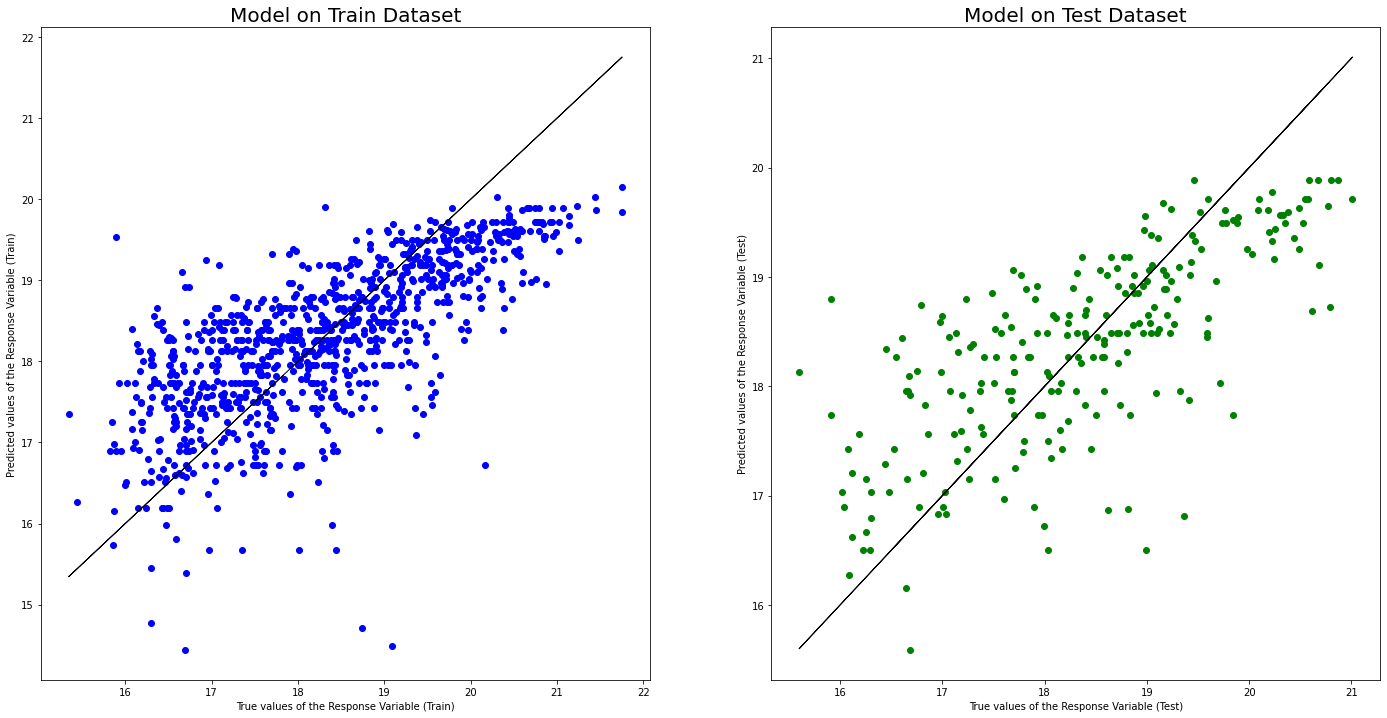

Goodness of Fit of Model 	Train Dataset
Explained Variance (R^2) 	: 0.5126820999982272
Mean Squared Error (MSE) 	: 0.8241724278981848

Goodness of Fit of Model 	Test Dataset
Explained Variance (R^2) 	: 0.5182954158950834
Mean Squared Error (MSE) 	: 0.752188836494445



In [2]:
# Recall the revlog and budlog Dataset
revlog = pd.DataFrame(workDF['RevenueLOG'])   # Response
budlog = pd.DataFrame(workDF['BudgetLOG'])    # Predictor

# Split the Dataset into Train and Test
budlog_train, budlog_test, revlog_train, revlog_test\
= train_test_split(budlog, revlog, test_size = 0.2)

# Linear Regression using Train Data
linrega = LinearRegression()                   # create the linear regression object
linrega.fit(budlog_train, revlog_train)        # train the linear regression model

# Predict RevenueLOG values using BudgetLOG
revlog_train_pred = linrega.predict(budlog_train)
revlog_test_pred = linrega.predict(budlog_test)
# Plot the Predictions vs the True values
f, axes = plt.subplots(1, 2, figsize=(24, 12))
axes[0].set_title('Model on Train Dataset',fontsize=20)
axes[1].set_title('Model on Test Dataset',fontsize=20)
axes[0].scatter(revlog_train, revlog_train_pred, color = "blue")
axes[0].plot(revlog_train, revlog_train, 'w-', linewidth = 1,color='black')
axes[0].set_xlabel("True values of the Response Variable (Train)")
axes[0].set_ylabel("Predicted values of the Response Variable (Train)")
axes[1].scatter(revlog_test, revlog_test_pred, color = "green")
axes[1].plot(revlog_test, revlog_test, 'w-', linewidth = 1,color='black')
axes[1].set_xlabel("True values of the Response Variable (Test)")
axes[1].set_ylabel("Predicted values of the Response Variable (Test)")
plt.show()

# Initialize score tracking lists
score1 = [] #Tracks R^2 for model application to test datasets
score2 = [] #Tracks R^2 for model application to train datasets
scoreM = [] #Tracks MSE for model applications to test datasets

# Store in score_list
score1.append(linrega.score(budlog_test, revlog_test))
score2.append(linrega.score(budlog_train, revlog_train))
scoreM.append(mean_squared_error(revlog_test, revlog_test_pred))


# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print("Explained Variance (R^2) \t:", linrega.score(budlog_train, revlog_train))
print("Mean Squared Error (MSE) \t:", mean_squared_error(revlog_train, revlog_train_pred))
print()

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Explained Variance (R^2) \t:", linrega.score(budlog_test, revlog_test))
print("Mean Squared Error (MSE) \t:", mean_squared_error(revlog_test, revlog_test_pred))
print()


# 2. Multi-Variate Linear Regression

### Next we will now consider all the variables that we have identified as having significant correlation with RevenueLOG as well as interesting categorical variables that we hypothesise does influence the the DV.

### Numerical variables we will consider are the Budget(LOGGED), Director experience and runtime

### Categorical variables considered are Release Months and Genres. Both OneHotEncoded.

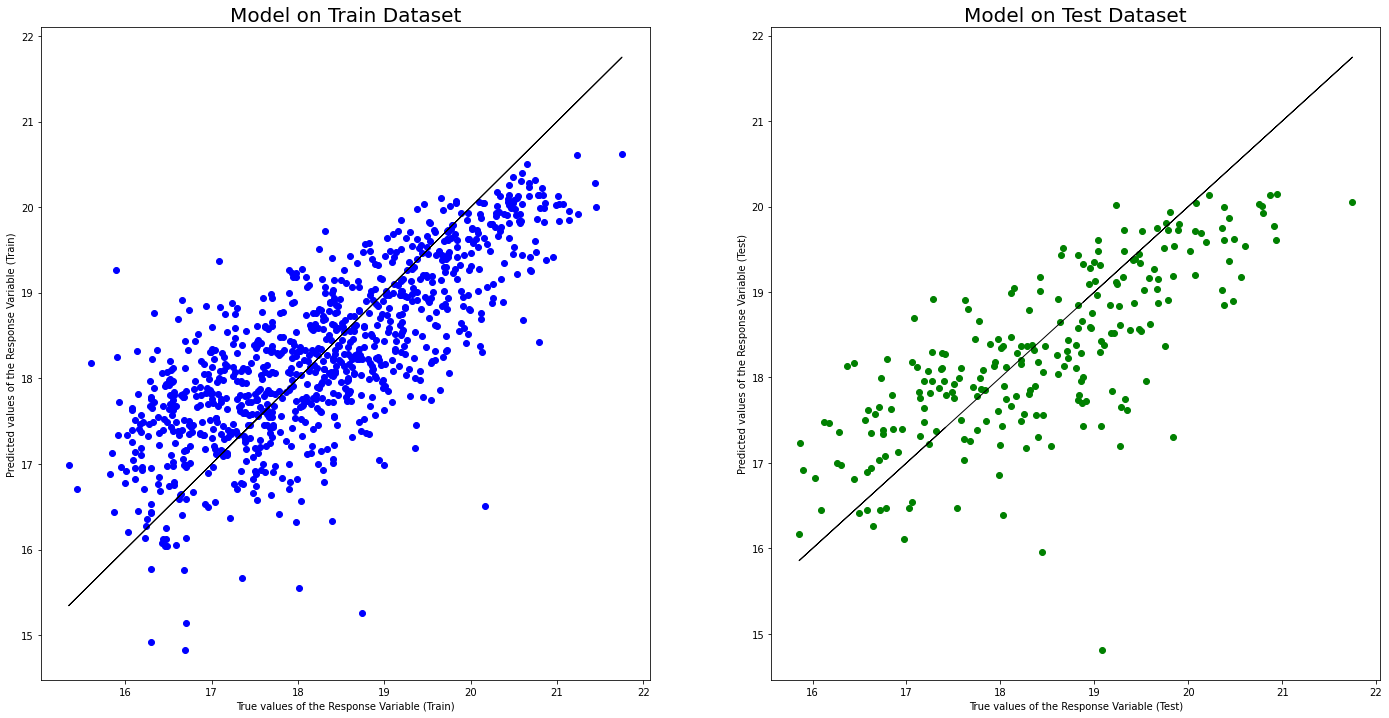

Goodness of Fit of Model 	Train Dataset
Explained Variance (R^2) 	: 0.5773524052112016
Mean Squared Error (MSE) 	: 0.7153214076616436

Goodness of Fit of Model 	Test Dataset
Explained Variance (R^2) 	: 0.5423906232967363
Mean Squared Error (MSE) 	: 0.7077170648099396



In [3]:
# Set Y Variable(DV)
Y=workDF['RevenueLOG']

# Set X Varaiables(IV)
X=movieGenre.iloc[:,3:]
X=X.join(movieMonth)
X=workDF[['BudgetLOG','Director Years Active(int)','Runtime']].join(X)

# Split dataframes into train and sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=101)

# Fit linear regression
linreg = LinearRegression() # Create linreg model
linreg.fit(X_train,y_train)

# Predict the Y value from Predictors
y_train_pred = linreg.predict(X_train)
y_test_pred = linreg.predict(X_test)

# Plot the Predictions vs the True values
f, axes = plt.subplots(1, 2, figsize=(24, 12))
axes[0].set_title('Model on Train Dataset',fontsize=20)
axes[1].set_title('Model on Test Dataset',fontsize=20)
axes[0].scatter(y_train, y_train_pred, color = "blue")
axes[0].plot(y_train, y_train, 'w-', linewidth = 1,color = "black")
axes[0].set_xlabel("True values of the Response Variable (Train)")
axes[0].set_ylabel("Predicted values of the Response Variable (Train)")
axes[1].scatter(y_test, y_test_pred, color = "green")
axes[1].plot(y_test, y_test, 'w-', linewidth = 1,color = "black")
axes[1].set_xlabel("True values of the Response Variable (Test)")
axes[1].set_ylabel("Predicted values of the Response Variable (Test)")
plt.show()

# Store in score_list
score2.append(r2_score(y_train, y_train_pred, sample_weight=None))
score1.append(r2_score(y_test, y_test_pred, sample_weight=None))
scoreM.append(metrics.mean_squared_error(y_test, y_test_pred))

# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print("Explained Variance (R^2) \t:", linreg.score(X_train, y_train))
print("Mean Squared Error (MSE) \t:", mean_squared_error(y_train, y_train_pred))
print()

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Explained Variance (R^2) \t:", linreg.score(X_test, y_test))
print("Mean Squared Error (MSE) \t:", mean_squared_error(y_test, y_test_pred))
print()

# 3.1 CatBoost

### CatBoost is a Machine Learning Algorithm which has the advantage of being able to handle categorical features automatically.

### To make use of this we use the raw ReleaseMonth String rather than the onehotencoded version before processing

### Due to the nature of genre being multilabel, we still relied on the one hot encoded version which catboost can also accept as a parameter

### We made use of CatBoost intuitive gridsearch to optimize hyperparameters when fitting the model

### Finally, we also made use of its internal importance measurement feature to visualize the weight of the IVs on DV

In [4]:
# Set Y DF (DV)
Y=pd.DataFrame(workDF['RevenueLOG'])

# Set X DF (IV)
X=movieGenre.iloc[:,3:]
X=workDF[['BudgetLOG','ReleaseMonth','Director Years Active(int)','Runtime']].join(X)

# Split DF into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=101)

# Identify Categorical Indices
categorical_features_indices = np.where(X.dtypes == np.object)[0]

# Convert to Catboost library models
train_dataset = cb.Pool(X_train, y_train,cat_features=categorical_features_indices) 
test_dataset = cb.Pool(X_test, y_test,cat_features=categorical_features_indices)

# Fit catboost regression
catreg = cb.CatBoostRegressor(loss_function='RMSE') #Create catboost regressor
grid = {'iterations': [100, 150, 200],              #CatBoost Gridsearch for optimal hyperparameters
        'learning_rate': [0.03, 0.1],
        'depth': [2, 4, 6, 8],
        'l2_leaf_reg': [0.2, 0.5, 1, 3]}
catreg.grid_search(grid, train_dataset)

0:	learn: 17.7815238	test: 17.7450988	best: 17.7450988 (0)	total: 136ms	remaining: 13.4s
1:	learn: 17.2502441	test: 17.2139565	best: 17.2139565 (1)	total: 140ms	remaining: 6.85s
2:	learn: 16.7361065	test: 16.7010564	best: 16.7010564 (2)	total: 147ms	remaining: 4.74s
3:	learn: 16.2374477	test: 16.2013866	best: 16.2013866 (3)	total: 151ms	remaining: 3.61s
4:	learn: 15.7537930	test: 15.7182504	best: 15.7182504 (4)	total: 158ms	remaining: 3s
5:	learn: 15.2846947	test: 15.2486356	best: 15.2486356 (5)	total: 165ms	remaining: 2.59s
6:	learn: 14.8288696	test: 14.7932487	best: 14.7932487 (6)	total: 172ms	remaining: 2.29s
7:	learn: 14.3874526	test: 14.3518612	best: 14.3518612 (7)	total: 180ms	remaining: 2.07s
8:	learn: 13.9583800	test: 13.9207508	best: 13.9207508 (8)	total: 188ms	remaining: 1.9s
9:	learn: 13.5433716	test: 13.5057439	best: 13.5057439 (9)	total: 197ms	remaining: 1.77s
10:	learn: 13.1407632	test: 13.1030783	best: 13.1030783 (10)	total: 205ms	remaining: 1.66s
11:	learn: 12.7505300	t

98:	learn: 1.2970197	test: 1.2655049	best: 1.2655049 (98)	total: 878ms	remaining: 8.87ms
99:	learn: 1.2755399	test: 1.2436934	best: 1.2436934 (99)	total: 887ms	remaining: 0us

bestTest = 1.24369339
bestIteration = 99

0:	loss: 1.2436934	best: 1.2436934 (0)	total: 943ms	remaining: 1m 29s
0:	learn: 16.5067312	test: 16.4690635	best: 16.4690635 (0)	total: 4.63ms	remaining: 458ms
1:	learn: 14.8638830	test: 14.8266785	best: 14.8266785 (1)	total: 9.58ms	remaining: 469ms
2:	learn: 13.3898578	test: 13.3562904	best: 13.3562904 (2)	total: 17.8ms	remaining: 577ms
3:	learn: 12.0641608	test: 12.0275981	best: 12.0275981 (3)	total: 22.4ms	remaining: 537ms
4:	learn: 10.8720144	test: 10.8370841	best: 10.8370841 (4)	total: 30.1ms	remaining: 571ms
5:	learn: 9.8001791	test: 9.7639947	best: 9.7639947 (5)	total: 38ms	remaining: 596ms
6:	learn: 8.8325441	test: 8.7979688	best: 8.7979688 (6)	total: 45.7ms	remaining: 607ms
7:	learn: 7.9661956	test: 7.9318985	best: 7.9318985 (7)	total: 54.3ms	remaining: 625ms
8:	

93:	learn: 0.7796828	test: 0.8460768	best: 0.8456717 (92)	total: 709ms	remaining: 45.2ms
94:	learn: 0.7781893	test: 0.8467573	best: 0.8456717 (92)	total: 717ms	remaining: 37.7ms
95:	learn: 0.7768430	test: 0.8469516	best: 0.8456717 (92)	total: 725ms	remaining: 30.2ms
96:	learn: 0.7761807	test: 0.8470866	best: 0.8456717 (92)	total: 732ms	remaining: 22.7ms
97:	learn: 0.7755221	test: 0.8469210	best: 0.8456717 (92)	total: 740ms	remaining: 15.1ms
98:	learn: 0.7751705	test: 0.8461969	best: 0.8456717 (92)	total: 747ms	remaining: 7.55ms
99:	learn: 0.7737958	test: 0.8465444	best: 0.8456717 (92)	total: 755ms	remaining: 0us

bestTest = 0.8456717276
bestIteration = 92

1:	loss: 0.8456717	best: 0.8456717 (1)	total: 1.73s	remaining: 1m 21s
0:	learn: 17.7822759	test: 17.7456295	best: 17.7456295 (0)	total: 4.41ms	remaining: 437ms
1:	learn: 17.2515181	test: 17.2153266	best: 17.2153266 (1)	total: 8.68ms	remaining: 425ms
2:	learn: 16.7380484	test: 16.7038583	best: 16.7038583 (2)	total: 16.4ms	remaining: 5

91:	learn: 1.4621618	test: 1.4232476	best: 1.4232476 (91)	total: 692ms	remaining: 60.1ms
92:	learn: 1.4352932	test: 1.3973217	best: 1.3973217 (92)	total: 701ms	remaining: 52.7ms
93:	learn: 1.4105590	test: 1.3741500	best: 1.3741500 (93)	total: 710ms	remaining: 45.3ms
94:	learn: 1.3842295	test: 1.3478249	best: 1.3478249 (94)	total: 718ms	remaining: 37.8ms
95:	learn: 1.3618877	test: 1.3262964	best: 1.3262964 (95)	total: 727ms	remaining: 30.3ms
96:	learn: 1.3404582	test: 1.3056203	best: 1.3056203 (96)	total: 737ms	remaining: 22.8ms
97:	learn: 1.3200486	test: 1.2860548	best: 1.2860548 (97)	total: 746ms	remaining: 15.2ms
98:	learn: 1.3003712	test: 1.2673702	best: 1.2673702 (98)	total: 755ms	remaining: 7.63ms
99:	learn: 1.2788184	test: 1.2454718	best: 1.2454718 (99)	total: 765ms	remaining: 0us

bestTest = 1.245471821
bestIteration = 99

2:	loss: 1.2454718	best: 0.8456717 (1)	total: 2.52s	remaining: 1m 18s
0:	learn: 16.5092483	test: 16.4708335	best: 16.4708335 (0)	total: 6.34ms	remaining: 628m

84:	learn: 0.7874554	test: 0.8487545	best: 0.8487545 (84)	total: 645ms	remaining: 114ms
85:	learn: 0.7863979	test: 0.8488579	best: 0.8487545 (84)	total: 654ms	remaining: 106ms
86:	learn: 0.7853754	test: 0.8493281	best: 0.8487545 (84)	total: 661ms	remaining: 98.8ms
87:	learn: 0.7847218	test: 0.8491665	best: 0.8487545 (84)	total: 669ms	remaining: 91.3ms
88:	learn: 0.7838812	test: 0.8477701	best: 0.8477701 (88)	total: 677ms	remaining: 83.7ms
89:	learn: 0.7829947	test: 0.8475401	best: 0.8475401 (89)	total: 685ms	remaining: 76.1ms
90:	learn: 0.7820409	test: 0.8462951	best: 0.8462951 (90)	total: 692ms	remaining: 68.5ms
91:	learn: 0.7812974	test: 0.8466029	best: 0.8462951 (90)	total: 700ms	remaining: 60.9ms
92:	learn: 0.7811214	test: 0.8459617	best: 0.8459617 (92)	total: 707ms	remaining: 53.3ms
93:	learn: 0.7797885	test: 0.8454515	best: 0.8454515 (93)	total: 715ms	remaining: 45.6ms
94:	learn: 0.7784692	test: 0.8462504	best: 0.8454515 (93)	total: 722ms	remaining: 38ms
95:	learn: 0.7777764	test

79:	learn: 1.8944039	test: 1.8508305	best: 1.8508305 (79)	total: 607ms	remaining: 152ms
80:	learn: 1.8501545	test: 1.8061319	best: 1.8061319 (80)	total: 616ms	remaining: 144ms
81:	learn: 1.8102340	test: 1.7661079	best: 1.7661079 (81)	total: 624ms	remaining: 137ms
82:	learn: 1.7692649	test: 1.7253642	best: 1.7253642 (82)	total: 631ms	remaining: 129ms
83:	learn: 1.7324913	test: 1.6891682	best: 1.6891682 (83)	total: 639ms	remaining: 122ms
84:	learn: 1.6973007	test: 1.6545958	best: 1.6545958 (84)	total: 647ms	remaining: 114ms
85:	learn: 1.6599591	test: 1.6169567	best: 1.6169567 (85)	total: 654ms	remaining: 106ms
86:	learn: 1.6241813	test: 1.5804620	best: 1.5804620 (86)	total: 661ms	remaining: 98.8ms
87:	learn: 1.5898497	test: 1.5468273	best: 1.5468273 (87)	total: 669ms	remaining: 91.2ms
88:	learn: 1.5593232	test: 1.5174346	best: 1.5174346 (88)	total: 677ms	remaining: 83.6ms
89:	learn: 1.5279322	test: 1.4870692	best: 1.4870692 (89)	total: 684ms	remaining: 76ms
90:	learn: 1.4971913	test: 1.4

74:	learn: 0.7988525	test: 0.8468212	best: 0.8465925 (71)	total: 568ms	remaining: 189ms
75:	learn: 0.7977446	test: 0.8469727	best: 0.8465925 (71)	total: 577ms	remaining: 182ms
76:	learn: 0.7970015	test: 0.8466955	best: 0.8465925 (71)	total: 585ms	remaining: 175ms
77:	learn: 0.7961955	test: 0.8454112	best: 0.8454112 (77)	total: 592ms	remaining: 167ms
78:	learn: 0.7950642	test: 0.8451685	best: 0.8451685 (78)	total: 600ms	remaining: 159ms
79:	learn: 0.7931201	test: 0.8448319	best: 0.8448319 (79)	total: 608ms	remaining: 152ms
80:	learn: 0.7926551	test: 0.8445786	best: 0.8445786 (80)	total: 615ms	remaining: 144ms
81:	learn: 0.7913373	test: 0.8461458	best: 0.8445786 (80)	total: 624ms	remaining: 137ms
82:	learn: 0.7899256	test: 0.8456795	best: 0.8445786 (80)	total: 632ms	remaining: 129ms
83:	learn: 0.7883707	test: 0.8458049	best: 0.8445786 (80)	total: 639ms	remaining: 122ms
84:	learn: 0.7869869	test: 0.8451958	best: 0.8445786 (80)	total: 647ms	remaining: 114ms
85:	learn: 0.7859761	test: 0.844

84:	learn: 1.7280653	test: 1.6836543	best: 1.6836543 (84)	total: 691ms	remaining: 122ms
85:	learn: 1.6900481	test: 1.6453742	best: 1.6453742 (85)	total: 699ms	remaining: 114ms
86:	learn: 1.6536625	test: 1.6081990	best: 1.6081990 (86)	total: 707ms	remaining: 106ms
87:	learn: 1.6185715	test: 1.5737537	best: 1.5737537 (87)	total: 717ms	remaining: 97.8ms
88:	learn: 1.5874424	test: 1.5436050	best: 1.5436050 (88)	total: 725ms	remaining: 89.6ms
89:	learn: 1.5555720	test: 1.5126366	best: 1.5126366 (89)	total: 732ms	remaining: 81.4ms
90:	learn: 1.5241769	test: 1.4810869	best: 1.4810869 (90)	total: 740ms	remaining: 73.2ms
91:	learn: 1.4949475	test: 1.4526418	best: 1.4526418 (91)	total: 747ms	remaining: 65ms
92:	learn: 1.4674009	test: 1.4258900	best: 1.4258900 (92)	total: 755ms	remaining: 56.8ms
93:	learn: 1.4392540	test: 1.3979585	best: 1.3979585 (93)	total: 762ms	remaining: 48.7ms
94:	learn: 1.4121936	test: 1.3707558	best: 1.3707558 (94)	total: 770ms	remaining: 40.5ms
95:	learn: 1.3889489	test:

85:	learn: 0.7932375	test: 0.8482477	best: 0.8482477 (85)	total: 786ms	remaining: 128ms
86:	learn: 0.7916558	test: 0.8477049	best: 0.8477049 (86)	total: 797ms	remaining: 119ms
87:	learn: 0.7901343	test: 0.8476976	best: 0.8476976 (87)	total: 807ms	remaining: 110ms
88:	learn: 0.7895256	test: 0.8470985	best: 0.8470985 (88)	total: 817ms	remaining: 101ms
89:	learn: 0.7889301	test: 0.8476018	best: 0.8470985 (88)	total: 827ms	remaining: 91.8ms
90:	learn: 0.7876803	test: 0.8477071	best: 0.8470985 (88)	total: 836ms	remaining: 82.7ms
91:	learn: 0.7874055	test: 0.8480548	best: 0.8470985 (88)	total: 845ms	remaining: 73.5ms
92:	learn: 0.7870339	test: 0.8476468	best: 0.8470985 (88)	total: 856ms	remaining: 64.4ms
93:	learn: 0.7867048	test: 0.8477333	best: 0.8470985 (88)	total: 865ms	remaining: 55.2ms
94:	learn: 0.7853222	test: 0.8484804	best: 0.8470985 (88)	total: 874ms	remaining: 46ms
95:	learn: 0.7847186	test: 0.8478303	best: 0.8470985 (88)	total: 884ms	remaining: 36.8ms
96:	learn: 0.7838956	test: 

79:	learn: 1.8805417	test: 1.8390272	best: 1.8390272 (79)	total: 756ms	remaining: 661ms
80:	learn: 1.8365953	test: 1.7946678	best: 1.7946678 (80)	total: 766ms	remaining: 652ms
81:	learn: 1.7969482	test: 1.7548932	best: 1.7548932 (81)	total: 776ms	remaining: 643ms
82:	learn: 1.7562743	test: 1.7145205	best: 1.7145205 (82)	total: 785ms	remaining: 634ms
83:	learn: 1.7197710	test: 1.6786136	best: 1.6786136 (83)	total: 795ms	remaining: 625ms
84:	learn: 1.6848400	test: 1.6443557	best: 1.6443557 (84)	total: 805ms	remaining: 616ms
85:	learn: 1.6477934	test: 1.6070198	best: 1.6070198 (85)	total: 814ms	remaining: 606ms
86:	learn: 1.6122575	test: 1.5708067	best: 1.5708067 (86)	total: 824ms	remaining: 597ms
87:	learn: 1.5782865	test: 1.5375674	best: 1.5375674 (87)	total: 834ms	remaining: 588ms
88:	learn: 1.5480384	test: 1.5085178	best: 1.5085178 (88)	total: 843ms	remaining: 578ms
89:	learn: 1.5168384	test: 1.4784076	best: 1.4784076 (89)	total: 853ms	remaining: 569ms
90:	learn: 1.4863954	test: 1.447

36:	learn: 0.9560527	test: 0.9420660	best: 0.9420660 (36)	total: 266ms	remaining: 813ms
37:	learn: 0.9372140	test: 0.9274537	best: 0.9274537 (37)	total: 275ms	remaining: 810ms
38:	learn: 0.9242956	test: 0.9183254	best: 0.9183254 (38)	total: 283ms	remaining: 805ms
39:	learn: 0.9111589	test: 0.9056869	best: 0.9056869 (39)	total: 290ms	remaining: 799ms
40:	learn: 0.9019316	test: 0.8983581	best: 0.8983581 (40)	total: 298ms	remaining: 792ms
41:	learn: 0.8908067	test: 0.8908432	best: 0.8908432 (41)	total: 305ms	remaining: 785ms
42:	learn: 0.8814363	test: 0.8835492	best: 0.8835492 (42)	total: 313ms	remaining: 778ms
43:	learn: 0.8731793	test: 0.8782205	best: 0.8782205 (43)	total: 320ms	remaining: 771ms
44:	learn: 0.8694776	test: 0.8762462	best: 0.8762462 (44)	total: 328ms	remaining: 764ms
45:	learn: 0.8623689	test: 0.8721782	best: 0.8721782 (45)	total: 335ms	remaining: 757ms
46:	learn: 0.8578390	test: 0.8699491	best: 0.8699491 (46)	total: 342ms	remaining: 750ms
47:	learn: 0.8529151	test: 0.867

148:	learn: 0.7433986	test: 0.8404466	best: 0.8402547 (146)	total: 1.18s	remaining: 7.89ms
149:	learn: 0.7430193	test: 0.8406702	best: 0.8402547 (146)	total: 1.19s	remaining: 0us

bestTest = 0.8402546597
bestIteration = 146

9:	loss: 0.8402547	best: 0.8402547 (9)	total: 9.39s	remaining: 1m 20s
0:	learn: 17.7822759	test: 17.7456295	best: 17.7456295 (0)	total: 5.06ms	remaining: 754ms
1:	learn: 17.2515181	test: 17.2153266	best: 17.2153266 (1)	total: 9.9ms	remaining: 733ms
2:	learn: 16.7380484	test: 16.7038583	best: 16.7038583 (2)	total: 18ms	remaining: 881ms
3:	learn: 16.2400998	test: 16.2048081	best: 16.2048081 (3)	total: 22.7ms	remaining: 828ms
4:	learn: 15.7570985	test: 15.7221978	best: 15.7221978 (4)	total: 30.9ms	remaining: 896ms
5:	learn: 15.2886353	test: 15.2532159	best: 15.2532159 (5)	total: 39.8ms	remaining: 956ms
6:	learn: 14.8333773	test: 14.7983590	best: 14.7983590 (6)	total: 47.9ms	remaining: 979ms
7:	learn: 14.3923333	test: 14.3571890	best: 14.3571890 (7)	total: 55.9ms	remai

102:	learn: 1.2197343	test: 1.1891963	best: 1.1891963 (102)	total: 896ms	remaining: 409ms
103:	learn: 1.2015530	test: 1.1717641	best: 1.1717641 (103)	total: 913ms	remaining: 404ms
104:	learn: 1.1842194	test: 1.1549759	best: 1.1549759 (104)	total: 924ms	remaining: 396ms
105:	learn: 1.1673656	test: 1.1381693	best: 1.1381693 (105)	total: 933ms	remaining: 387ms
106:	learn: 1.1507744	test: 1.1224324	best: 1.1224324 (106)	total: 942ms	remaining: 379ms
107:	learn: 1.1351861	test: 1.1088679	best: 1.1088679 (107)	total: 951ms	remaining: 370ms
108:	learn: 1.1203383	test: 1.0946298	best: 1.0946298 (108)	total: 961ms	remaining: 361ms
109:	learn: 1.1070034	test: 1.0824126	best: 1.0824126 (109)	total: 970ms	remaining: 353ms
110:	learn: 1.0932900	test: 1.0696603	best: 1.0696603 (110)	total: 978ms	remaining: 344ms
111:	learn: 1.0824506	test: 1.0599428	best: 1.0599428 (111)	total: 988ms	remaining: 335ms
112:	learn: 1.0696688	test: 1.0480210	best: 1.0480210 (112)	total: 997ms	remaining: 326ms
113:	learn

49:	learn: 0.8481437	test: 0.8670541	best: 0.8658840 (48)	total: 453ms	remaining: 906ms
50:	learn: 0.8448615	test: 0.8652339	best: 0.8652339 (50)	total: 463ms	remaining: 899ms
51:	learn: 0.8396497	test: 0.8642041	best: 0.8642041 (51)	total: 473ms	remaining: 891ms
52:	learn: 0.8351803	test: 0.8607230	best: 0.8607230 (52)	total: 482ms	remaining: 882ms
53:	learn: 0.8334884	test: 0.8599982	best: 0.8599982 (53)	total: 491ms	remaining: 873ms
54:	learn: 0.8313859	test: 0.8596772	best: 0.8596772 (54)	total: 500ms	remaining: 864ms
55:	learn: 0.8274656	test: 0.8589193	best: 0.8589193 (55)	total: 509ms	remaining: 855ms
56:	learn: 0.8253803	test: 0.8580804	best: 0.8580804 (56)	total: 518ms	remaining: 846ms
57:	learn: 0.8232142	test: 0.8576185	best: 0.8576185 (57)	total: 527ms	remaining: 837ms
58:	learn: 0.8200551	test: 0.8574617	best: 0.8574617 (58)	total: 537ms	remaining: 828ms
59:	learn: 0.8186132	test: 0.8569131	best: 0.8569131 (59)	total: 546ms	remaining: 819ms
60:	learn: 0.8176623	test: 0.856

146:	learn: 0.7471647	test: 0.8366958	best: 0.8361691 (141)	total: 1.35s	remaining: 27.5ms
147:	learn: 0.7464999	test: 0.8354782	best: 0.8354782 (147)	total: 1.36s	remaining: 18.4ms
148:	learn: 0.7461713	test: 0.8359296	best: 0.8354782 (147)	total: 1.37s	remaining: 9.19ms
149:	learn: 0.7455801	test: 0.8366019	best: 0.8354782 (147)	total: 1.38s	remaining: 0us

bestTest = 0.8354781947
bestIteration = 147

11:	loss: 0.8354782	best: 0.8354782 (11)	total: 12.2s	remaining: 1m 25s
0:	learn: 17.7834047	test: 17.7464880	best: 17.7464880 (0)	total: 5.41ms	remaining: 806ms
1:	learn: 17.2534556	test: 17.2173159	best: 17.2173159 (1)	total: 10.6ms	remaining: 784ms
2:	learn: 16.7410187	test: 16.7076944	best: 16.7076944 (2)	total: 19.7ms	remaining: 966ms
3:	learn: 16.2442542	test: 16.2096821	best: 16.2096821 (3)	total: 24.7ms	remaining: 903ms
4:	learn: 15.7622776	test: 15.7279495	best: 15.7279495 (4)	total: 33.9ms	remaining: 983ms
5:	learn: 15.2948787	test: 15.2600315	best: 15.2600315 (5)	total: 42.9m

107:	learn: 1.1363256	test: 1.1063114	best: 1.1063114 (107)	total: 874ms	remaining: 340ms
108:	learn: 1.1214596	test: 1.0920652	best: 1.0920652 (108)	total: 883ms	remaining: 332ms
109:	learn: 1.1080538	test: 1.0797644	best: 1.0797644 (109)	total: 890ms	remaining: 324ms
110:	learn: 1.0943582	test: 1.0670437	best: 1.0670437 (110)	total: 898ms	remaining: 316ms
111:	learn: 1.0833917	test: 1.0571665	best: 1.0571665 (111)	total: 905ms	remaining: 307ms
112:	learn: 1.0705844	test: 1.0452544	best: 1.0452544 (112)	total: 913ms	remaining: 299ms
113:	learn: 1.0585264	test: 1.0337333	best: 1.0337333 (113)	total: 920ms	remaining: 291ms
114:	learn: 1.0472206	test: 1.0240153	best: 1.0240153 (114)	total: 928ms	remaining: 282ms
115:	learn: 1.0364797	test: 1.0137233	best: 1.0137233 (115)	total: 935ms	remaining: 274ms
116:	learn: 1.0262637	test: 1.0039815	best: 1.0039815 (116)	total: 942ms	remaining: 266ms
117:	learn: 1.0168187	test: 0.9955432	best: 0.9955432 (117)	total: 949ms	remaining: 257ms
118:	learn

53:	learn: 0.8381398	test: 0.8593625	best: 0.8593625 (53)	total: 410ms	remaining: 728ms
54:	learn: 0.8358501	test: 0.8589482	best: 0.8589482 (54)	total: 418ms	remaining: 722ms
55:	learn: 0.8312667	test: 0.8577091	best: 0.8577091 (55)	total: 425ms	remaining: 714ms
56:	learn: 0.8281746	test: 0.8541365	best: 0.8541365 (56)	total: 433ms	remaining: 707ms
57:	learn: 0.8261731	test: 0.8521691	best: 0.8521691 (57)	total: 441ms	remaining: 699ms
58:	learn: 0.8226928	test: 0.8517988	best: 0.8517988 (58)	total: 448ms	remaining: 691ms
59:	learn: 0.8213044	test: 0.8512771	best: 0.8512771 (59)	total: 456ms	remaining: 684ms
60:	learn: 0.8203746	test: 0.8509237	best: 0.8509237 (60)	total: 465ms	remaining: 678ms
61:	learn: 0.8187792	test: 0.8507760	best: 0.8507760 (61)	total: 472ms	remaining: 670ms
62:	learn: 0.8170986	test: 0.8489981	best: 0.8489981 (62)	total: 480ms	remaining: 663ms
63:	learn: 0.8160625	test: 0.8482690	best: 0.8482690 (63)	total: 487ms	remaining: 655ms
64:	learn: 0.8157861	test: 0.848

147:	learn: 0.7463514	test: 0.8383594	best: 0.8377174 (141)	total: 1.14s	remaining: 15.3ms
148:	learn: 0.7463245	test: 0.8383923	best: 0.8377174 (141)	total: 1.15s	remaining: 7.69ms
149:	learn: 0.7460996	test: 0.8383120	best: 0.8377174 (141)	total: 1.15s	remaining: 0us

bestTest = 0.8377174376
bestIteration = 141

13:	loss: 0.8377174	best: 0.8354782 (11)	total: 14.7s	remaining: 1m 25s
0:	learn: 17.7872532	test: 17.7496914	best: 17.7496914 (0)	total: 5.02ms	remaining: 748ms
1:	learn: 17.2602896	test: 17.2240097	best: 17.2240097 (1)	total: 9.94ms	remaining: 735ms
2:	learn: 16.7516187	test: 16.7196556	best: 16.7196556 (2)	total: 18.3ms	remaining: 899ms
3:	learn: 16.2595355	test: 16.2257725	best: 16.2257725 (3)	total: 23.1ms	remaining: 842ms
4:	learn: 15.7812395	test: 15.7475040	best: 15.7475040 (4)	total: 31.5ms	remaining: 914ms
5:	learn: 15.3180941	test: 15.2838500	best: 15.2838500 (5)	total: 39.9ms	remaining: 957ms
6:	learn: 14.8674453	test: 14.8333260	best: 14.8333260 (6)	total: 48.3ms

104:	learn: 1.2041158	test: 1.1684241	best: 1.1684241 (104)	total: 1.06s	remaining: 456ms
105:	learn: 1.1867566	test: 1.1510898	best: 1.1510898 (105)	total: 1.07s	remaining: 447ms
106:	learn: 1.1695177	test: 1.1347230	best: 1.1347230 (106)	total: 1.09s	remaining: 437ms
107:	learn: 1.1533390	test: 1.1206195	best: 1.1206195 (107)	total: 1.1s	remaining: 427ms
108:	learn: 1.1379176	test: 1.1057897	best: 1.1057897 (108)	total: 1.11s	remaining: 418ms
109:	learn: 1.1240937	test: 1.0930087	best: 1.0930087 (109)	total: 1.12s	remaining: 408ms
110:	learn: 1.1098894	test: 1.0798104	best: 1.0798104 (110)	total: 1.13s	remaining: 398ms
111:	learn: 1.0984865	test: 1.0693824	best: 1.0693824 (111)	total: 1.14s	remaining: 388ms
112:	learn: 1.0851256	test: 1.0569195	best: 1.0569195 (112)	total: 1.15s	remaining: 378ms
113:	learn: 1.0725804	test: 1.0449299	best: 1.0449299 (113)	total: 1.17s	remaining: 368ms
114:	learn: 1.0608422	test: 1.0347607	best: 1.0347607 (114)	total: 1.18s	remaining: 358ms
115:	learn:

56:	learn: 0.8348488	test: 0.8619137	best: 0.8619137 (56)	total: 460ms	remaining: 751ms
57:	learn: 0.8326343	test: 0.8597268	best: 0.8597268 (57)	total: 469ms	remaining: 744ms
58:	learn: 0.8291884	test: 0.8595183	best: 0.8595183 (58)	total: 478ms	remaining: 737ms
59:	learn: 0.8277385	test: 0.8589232	best: 0.8589232 (59)	total: 486ms	remaining: 729ms
60:	learn: 0.8267555	test: 0.8585382	best: 0.8585382 (60)	total: 494ms	remaining: 721ms
61:	learn: 0.8243689	test: 0.8566590	best: 0.8566590 (61)	total: 503ms	remaining: 713ms
62:	learn: 0.8230623	test: 0.8556787	best: 0.8556787 (62)	total: 511ms	remaining: 706ms
63:	learn: 0.8219964	test: 0.8548780	best: 0.8548780 (63)	total: 519ms	remaining: 697ms
64:	learn: 0.8213006	test: 0.8541224	best: 0.8541224 (64)	total: 527ms	remaining: 690ms
65:	learn: 0.8194422	test: 0.8540741	best: 0.8540741 (65)	total: 535ms	remaining: 681ms
66:	learn: 0.8179599	test: 0.8543473	best: 0.8540741 (65)	total: 543ms	remaining: 673ms
67:	learn: 0.8161887	test: 0.854

17:	learn: 10.6453332	test: 10.6092810	best: 10.6092810 (17)	total: 140ms	remaining: 1.41s
18:	learn: 10.3296419	test: 10.2948963	best: 10.2948963 (18)	total: 149ms	remaining: 1.42s
19:	learn: 10.0245201	test: 9.9899231	best: 9.9899231 (19)	total: 157ms	remaining: 1.42s
20:	learn: 9.7271402	test: 9.6924374	best: 9.6924374 (20)	total: 166ms	remaining: 1.41s
21:	learn: 9.4402234	test: 9.4055940	best: 9.4055940 (21)	total: 175ms	remaining: 1.42s
22:	learn: 9.1615797	test: 9.1278430	best: 9.1278430 (22)	total: 183ms	remaining: 1.41s
23:	learn: 8.8919355	test: 8.8580385	best: 8.8580385 (23)	total: 192ms	remaining: 1.41s
24:	learn: 8.6305391	test: 8.5968077	best: 8.5968077 (24)	total: 200ms	remaining: 1.4s
25:	learn: 8.3770159	test: 8.3435247	best: 8.3435247 (25)	total: 208ms	remaining: 1.39s
26:	learn: 8.1291716	test: 8.0934897	best: 8.0934897 (26)	total: 216ms	remaining: 1.38s
27:	learn: 7.8909936	test: 7.8555009	best: 7.8555009 (27)	total: 224ms	remaining: 1.38s
28:	learn: 7.6586747	test:

125:	learn: 0.9590050	test: 0.9653041	best: 0.9653041 (125)	total: 1.04s	remaining: 612ms
126:	learn: 0.9524300	test: 0.9591633	best: 0.9591633 (126)	total: 1.05s	remaining: 604ms
127:	learn: 0.9456695	test: 0.9530601	best: 0.9530601 (127)	total: 1.06s	remaining: 596ms
128:	learn: 0.9400821	test: 0.9484389	best: 0.9484389 (128)	total: 1.07s	remaining: 588ms
129:	learn: 0.9339591	test: 0.9430793	best: 0.9430793 (129)	total: 1.08s	remaining: 579ms
130:	learn: 0.9297550	test: 0.9398070	best: 0.9398070 (130)	total: 1.08s	remaining: 571ms
131:	learn: 0.9241507	test: 0.9347968	best: 0.9347968 (131)	total: 1.09s	remaining: 563ms
132:	learn: 0.9202510	test: 0.9320699	best: 0.9320699 (132)	total: 1.1s	remaining: 554ms
133:	learn: 0.9150683	test: 0.9279241	best: 0.9279241 (133)	total: 1.11s	remaining: 546ms
134:	learn: 0.9102440	test: 0.9240323	best: 0.9240323 (134)	total: 1.12s	remaining: 538ms
135:	learn: 0.9056444	test: 0.9196657	best: 0.9196657 (135)	total: 1.13s	remaining: 530ms
136:	learn:

34:	learn: 1.0147429	test: 1.0175555	best: 1.0175555 (34)	total: 279ms	remaining: 1.31s
35:	learn: 0.9850607	test: 0.9911960	best: 0.9911960 (35)	total: 288ms	remaining: 1.31s
36:	learn: 0.9611913	test: 0.9733663	best: 0.9733663 (36)	total: 297ms	remaining: 1.31s
37:	learn: 0.9409522	test: 0.9551243	best: 0.9551243 (37)	total: 305ms	remaining: 1.3s
38:	learn: 0.9233428	test: 0.9396040	best: 0.9396040 (38)	total: 313ms	remaining: 1.29s
39:	learn: 0.9080051	test: 0.9269551	best: 0.9269551 (39)	total: 322ms	remaining: 1.29s
40:	learn: 0.8951739	test: 0.9162306	best: 0.9162306 (40)	total: 330ms	remaining: 1.28s
41:	learn: 0.8885852	test: 0.9111546	best: 0.9111546 (41)	total: 338ms	remaining: 1.27s
42:	learn: 0.8801158	test: 0.9062785	best: 0.9062785 (42)	total: 346ms	remaining: 1.26s
43:	learn: 0.8721435	test: 0.8991594	best: 0.8991594 (43)	total: 354ms	remaining: 1.25s
44:	learn: 0.8648664	test: 0.8947381	best: 0.8947381 (44)	total: 362ms	remaining: 1.25s
45:	learn: 0.8591194	test: 0.8913

143:	learn: 0.7495988	test: 0.8500348	best: 0.8487610 (138)	total: 1.18s	remaining: 460ms
144:	learn: 0.7489924	test: 0.8496888	best: 0.8487610 (138)	total: 1.19s	remaining: 452ms
145:	learn: 0.7484652	test: 0.8499834	best: 0.8487610 (138)	total: 1.2s	remaining: 444ms
146:	learn: 0.7482381	test: 0.8499826	best: 0.8487610 (138)	total: 1.21s	remaining: 436ms
147:	learn: 0.7474764	test: 0.8502672	best: 0.8487610 (138)	total: 1.22s	remaining: 427ms
148:	learn: 0.7471295	test: 0.8501229	best: 0.8487610 (138)	total: 1.22s	remaining: 419ms
149:	learn: 0.7462069	test: 0.8495788	best: 0.8487610 (138)	total: 1.23s	remaining: 411ms
150:	learn: 0.7455676	test: 0.8496425	best: 0.8487610 (138)	total: 1.24s	remaining: 403ms
151:	learn: 0.7452871	test: 0.8491643	best: 0.8487610 (138)	total: 1.25s	remaining: 394ms
152:	learn: 0.7446684	test: 0.8496897	best: 0.8487610 (138)	total: 1.26s	remaining: 386ms
153:	learn: 0.7445362	test: 0.8496574	best: 0.8487610 (138)	total: 1.26s	remaining: 378ms
154:	learn:

44:	learn: 4.7971871	test: 4.7634132	best: 4.7634132 (44)	total: 425ms	remaining: 1.46s
45:	learn: 4.6601162	test: 4.6265783	best: 4.6265783 (45)	total: 436ms	remaining: 1.46s
46:	learn: 4.5275943	test: 4.4938848	best: 4.4938848 (46)	total: 448ms	remaining: 1.46s
47:	learn: 4.4000173	test: 4.3659955	best: 4.3659955 (47)	total: 458ms	remaining: 1.45s
48:	learn: 4.2769842	test: 4.2427216	best: 4.2427216 (48)	total: 469ms	remaining: 1.45s
49:	learn: 4.1579106	test: 4.1233944	best: 4.1233944 (49)	total: 480ms	remaining: 1.44s
50:	learn: 4.0426791	test: 4.0083589	best: 4.0083589 (50)	total: 492ms	remaining: 1.44s
51:	learn: 3.9278263	test: 3.8935868	best: 3.8935868 (51)	total: 502ms	remaining: 1.43s
52:	learn: 3.8171273	test: 3.7828787	best: 3.7828787 (52)	total: 513ms	remaining: 1.42s
53:	learn: 3.7099593	test: 3.6758428	best: 3.6758428 (53)	total: 523ms	remaining: 1.41s
54:	learn: 3.6056641	test: 3.5713619	best: 3.5713619 (54)	total: 534ms	remaining: 1.41s
55:	learn: 3.5076367	test: 3.473

144:	learn: 0.8752055	test: 0.8949577	best: 0.8949577 (144)	total: 1.51s	remaining: 572ms
145:	learn: 0.8723956	test: 0.8927803	best: 0.8927803 (145)	total: 1.52s	remaining: 563ms
146:	learn: 0.8697911	test: 0.8907628	best: 0.8907628 (146)	total: 1.53s	remaining: 553ms
147:	learn: 0.8669987	test: 0.8888638	best: 0.8888638 (147)	total: 1.54s	remaining: 543ms
148:	learn: 0.8646611	test: 0.8873350	best: 0.8873350 (148)	total: 1.55s	remaining: 532ms
149:	learn: 0.8622342	test: 0.8854361	best: 0.8854361 (149)	total: 1.56s	remaining: 522ms
150:	learn: 0.8609218	test: 0.8845914	best: 0.8845914 (150)	total: 1.57s	remaining: 511ms
151:	learn: 0.8588245	test: 0.8833528	best: 0.8833528 (151)	total: 1.59s	remaining: 501ms
152:	learn: 0.8568779	test: 0.8822249	best: 0.8822249 (152)	total: 1.6s	remaining: 490ms
153:	learn: 0.8549127	test: 0.8810954	best: 0.8810954 (153)	total: 1.61s	remaining: 480ms
154:	learn: 0.8531262	test: 0.8795802	best: 0.8795802 (154)	total: 1.62s	remaining: 470ms
155:	learn:

45:	learn: 0.8597450	test: 0.8916727	best: 0.8916727 (45)	total: 479ms	remaining: 1.6s
46:	learn: 0.8545919	test: 0.8878873	best: 0.8878873 (46)	total: 490ms	remaining: 1.6s
47:	learn: 0.8509730	test: 0.8854272	best: 0.8854272 (47)	total: 502ms	remaining: 1.59s
48:	learn: 0.8463883	test: 0.8823883	best: 0.8823883 (48)	total: 515ms	remaining: 1.59s
49:	learn: 0.8432079	test: 0.8795474	best: 0.8795474 (49)	total: 526ms	remaining: 1.58s
50:	learn: 0.8395233	test: 0.8777861	best: 0.8777861 (50)	total: 538ms	remaining: 1.57s
51:	learn: 0.8358164	test: 0.8733523	best: 0.8733523 (51)	total: 549ms	remaining: 1.56s
52:	learn: 0.8330133	test: 0.8718893	best: 0.8718893 (52)	total: 560ms	remaining: 1.55s
53:	learn: 0.8296977	test: 0.8678277	best: 0.8678277 (53)	total: 571ms	remaining: 1.54s
54:	learn: 0.8252034	test: 0.8659997	best: 0.8659997 (54)	total: 579ms	remaining: 1.53s
55:	learn: 0.8239569	test: 0.8655718	best: 0.8655718 (55)	total: 587ms	remaining: 1.51s
56:	learn: 0.8229127	test: 0.86569

138:	learn: 0.7537128	test: 0.8465434	best: 0.8438299 (124)	total: 1.21s	remaining: 532ms
139:	learn: 0.7527831	test: 0.8468066	best: 0.8438299 (124)	total: 1.22s	remaining: 523ms
140:	learn: 0.7517195	test: 0.8474940	best: 0.8438299 (124)	total: 1.23s	remaining: 514ms
141:	learn: 0.7514339	test: 0.8470161	best: 0.8438299 (124)	total: 1.24s	remaining: 505ms
142:	learn: 0.7512584	test: 0.8465485	best: 0.8438299 (124)	total: 1.24s	remaining: 496ms
143:	learn: 0.7510672	test: 0.8465028	best: 0.8438299 (124)	total: 1.25s	remaining: 487ms
144:	learn: 0.7500342	test: 0.8470228	best: 0.8438299 (124)	total: 1.26s	remaining: 478ms
145:	learn: 0.7493344	test: 0.8475119	best: 0.8438299 (124)	total: 1.27s	remaining: 469ms
146:	learn: 0.7484854	test: 0.8480594	best: 0.8438299 (124)	total: 1.27s	remaining: 460ms
147:	learn: 0.7477024	test: 0.8473624	best: 0.8438299 (124)	total: 1.28s	remaining: 451ms
148:	learn: 0.7474387	test: 0.8470013	best: 0.8438299 (124)	total: 1.29s	remaining: 442ms
149:	learn

32:	learn: 6.8266848	test: 6.7904025	best: 6.7904025 (32)	total: 250ms	remaining: 1.26s
33:	learn: 6.6290647	test: 6.5925225	best: 6.5925225 (33)	total: 258ms	remaining: 1.26s
34:	learn: 6.4376152	test: 6.4009306	best: 6.4009306 (34)	total: 266ms	remaining: 1.25s
35:	learn: 6.2520372	test: 6.2157929	best: 6.2157929 (35)	total: 274ms	remaining: 1.25s
36:	learn: 6.0720338	test: 6.0363943	best: 6.0363943 (36)	total: 282ms	remaining: 1.24s
37:	learn: 5.8971759	test: 5.8612589	best: 5.8612589 (37)	total: 290ms	remaining: 1.23s
38:	learn: 5.7274049	test: 5.6909118	best: 5.6909118 (38)	total: 297ms	remaining: 1.23s
39:	learn: 5.5614539	test: 5.5255965	best: 5.5255965 (39)	total: 305ms	remaining: 1.22s
40:	learn: 5.4002938	test: 5.3627183	best: 5.3627183 (40)	total: 313ms	remaining: 1.21s
41:	learn: 5.2464523	test: 5.2094614	best: 5.2094614 (41)	total: 320ms	remaining: 1.2s
42:	learn: 5.0972243	test: 5.0603483	best: 5.0603483 (42)	total: 328ms	remaining: 1.2s
43:	learn: 4.9525409	test: 4.91663

125:	learn: 0.9617676	test: 0.9657084	best: 0.9657084 (125)	total: 971ms	remaining: 571ms
126:	learn: 0.9551126	test: 0.9595588	best: 0.9595588 (126)	total: 980ms	remaining: 563ms
127:	learn: 0.9481437	test: 0.9533170	best: 0.9533170 (127)	total: 988ms	remaining: 556ms
128:	learn: 0.9423723	test: 0.9485814	best: 0.9485814 (128)	total: 996ms	remaining: 548ms
129:	learn: 0.9361489	test: 0.9432644	best: 0.9432644 (129)	total: 1s	remaining: 540ms
130:	learn: 0.9318384	test: 0.9398784	best: 0.9398784 (130)	total: 1.01s	remaining: 533ms
131:	learn: 0.9266540	test: 0.9350439	best: 0.9350439 (131)	total: 1.02s	remaining: 525ms
132:	learn: 0.9227163	test: 0.9322673	best: 0.9322673 (132)	total: 1.03s	remaining: 517ms
133:	learn: 0.9179283	test: 0.9285774	best: 0.9285774 (133)	total: 1.03s	remaining: 510ms
134:	learn: 0.9128366	test: 0.9244671	best: 0.9244671 (134)	total: 1.04s	remaining: 502ms
135:	learn: 0.9081095	test: 0.9200580	best: 0.9200580 (135)	total: 1.05s	remaining: 494ms
136:	learn: 0

35:	learn: 0.9901783	test: 0.9938727	best: 0.9938727 (35)	total: 303ms	remaining: 1.38s
36:	learn: 0.9658571	test: 0.9759644	best: 0.9759644 (36)	total: 312ms	remaining: 1.38s
37:	learn: 0.9450617	test: 0.9575616	best: 0.9575616 (37)	total: 322ms	remaining: 1.37s
38:	learn: 0.9271857	test: 0.9417796	best: 0.9417796 (38)	total: 330ms	remaining: 1.36s
39:	learn: 0.9114936	test: 0.9290146	best: 0.9290146 (39)	total: 340ms	remaining: 1.36s
40:	learn: 0.8983173	test: 0.9181086	best: 0.9181086 (40)	total: 348ms	remaining: 1.35s
41:	learn: 0.8895159	test: 0.9120655	best: 0.9120655 (41)	total: 356ms	remaining: 1.34s
42:	learn: 0.8812683	test: 0.9071166	best: 0.9071166 (42)	total: 363ms	remaining: 1.33s
43:	learn: 0.8732634	test: 0.9001807	best: 0.9001807 (43)	total: 371ms	remaining: 1.31s
44:	learn: 0.8660664	test: 0.8957649	best: 0.8957649 (44)	total: 379ms	remaining: 1.3s
45:	learn: 0.8603070	test: 0.8924678	best: 0.8924678 (45)	total: 386ms	remaining: 1.29s
46:	learn: 0.8558998	test: 0.8889

128:	learn: 0.7588480	test: 0.8547818	best: 0.8522596 (114)	total: 1.22s	remaining: 671ms
129:	learn: 0.7585169	test: 0.8544679	best: 0.8522596 (114)	total: 1.23s	remaining: 663ms
130:	learn: 0.7578336	test: 0.8545973	best: 0.8522596 (114)	total: 1.24s	remaining: 654ms
131:	learn: 0.7576145	test: 0.8542269	best: 0.8522596 (114)	total: 1.25s	remaining: 645ms
132:	learn: 0.7574834	test: 0.8542249	best: 0.8522596 (114)	total: 1.26s	remaining: 636ms
133:	learn: 0.7573761	test: 0.8543144	best: 0.8522596 (114)	total: 1.27s	remaining: 627ms
134:	learn: 0.7572642	test: 0.8539652	best: 0.8522596 (114)	total: 1.28s	remaining: 618ms
135:	learn: 0.7565492	test: 0.8546506	best: 0.8522596 (114)	total: 1.29s	remaining: 609ms
136:	learn: 0.7555839	test: 0.8543756	best: 0.8522596 (114)	total: 1.3s	remaining: 600ms
137:	learn: 0.7554709	test: 0.8543895	best: 0.8522596 (114)	total: 1.32s	remaining: 591ms
138:	learn: 0.7546717	test: 0.8536076	best: 0.8522596 (114)	total: 1.33s	remaining: 582ms
139:	learn:

26:	learn: 8.2084796	test: 8.1657247	best: 8.1657247 (26)	total: 331ms	remaining: 2.12s
27:	learn: 7.9711222	test: 7.9288558	best: 7.9288558 (27)	total: 344ms	remaining: 2.11s
28:	learn: 7.7394324	test: 7.6978997	best: 7.6978997 (28)	total: 357ms	remaining: 2.11s
29:	learn: 7.5157189	test: 7.4749514	best: 7.4749514 (29)	total: 370ms	remaining: 2.1s
30:	learn: 7.2990196	test: 7.2591962	best: 7.2591962 (30)	total: 383ms	remaining: 2.09s
31:	learn: 7.0885078	test: 7.0483544	best: 7.0483544 (31)	total: 396ms	remaining: 2.08s
32:	learn: 6.8845096	test: 6.8444021	best: 6.8444021 (32)	total: 408ms	remaining: 2.07s
33:	learn: 6.6866435	test: 6.6459550	best: 6.6459550 (33)	total: 421ms	remaining: 2.06s
34:	learn: 6.4951048	test: 6.4539538	best: 6.4539538 (34)	total: 433ms	remaining: 2.04s
35:	learn: 6.3096690	test: 6.2689826	best: 6.2689826 (35)	total: 446ms	remaining: 2.03s
36:	learn: 6.1292020	test: 6.0892500	best: 6.0892500 (36)	total: 458ms	remaining: 2.02s
37:	learn: 5.9541046	test: 5.9138

124:	learn: 0.9862736	test: 0.9812535	best: 0.9812535 (124)	total: 1.59s	remaining: 955ms
125:	learn: 0.9784888	test: 0.9746844	best: 0.9746844 (125)	total: 1.6s	remaining: 943ms
126:	learn: 0.9714964	test: 0.9683000	best: 0.9683000 (126)	total: 1.62s	remaining: 930ms
127:	learn: 0.9641969	test: 0.9617930	best: 0.9617930 (127)	total: 1.63s	remaining: 918ms
128:	learn: 0.9582403	test: 0.9569261	best: 0.9569261 (128)	total: 1.65s	remaining: 905ms
129:	learn: 0.9516106	test: 0.9514246	best: 0.9514246 (129)	total: 1.66s	remaining: 893ms
130:	learn: 0.9471274	test: 0.9478606	best: 0.9478606 (130)	total: 1.67s	remaining: 880ms
131:	learn: 0.9415927	test: 0.9430323	best: 0.9430323 (131)	total: 1.68s	remaining: 867ms
132:	learn: 0.9374980	test: 0.9400928	best: 0.9400928 (132)	total: 1.7s	remaining: 854ms
133:	learn: 0.9325051	test: 0.9362511	best: 0.9362511 (133)	total: 1.71s	remaining: 842ms
134:	learn: 0.9272007	test: 0.9320037	best: 0.9320037 (134)	total: 1.72s	remaining: 829ms
135:	learn: 

24:	learn: 1.7133095	test: 1.6679583	best: 1.6679583 (24)	total: 308ms	remaining: 2.15s
25:	learn: 1.5937941	test: 1.5510219	best: 1.5510219 (25)	total: 321ms	remaining: 2.15s
26:	learn: 1.4902651	test: 1.4496958	best: 1.4496958 (26)	total: 335ms	remaining: 2.15s
27:	learn: 1.4107862	test: 1.3738282	best: 1.3738282 (27)	total: 348ms	remaining: 2.14s
28:	learn: 1.3278853	test: 1.2921941	best: 1.2921941 (28)	total: 361ms	remaining: 2.13s
29:	learn: 1.2620568	test: 1.2309736	best: 1.2309736 (29)	total: 373ms	remaining: 2.11s
30:	learn: 1.2099410	test: 1.1864252	best: 1.1864252 (30)	total: 387ms	remaining: 2.11s
31:	learn: 1.1646933	test: 1.1427040	best: 1.1427040 (31)	total: 407ms	remaining: 2.13s
32:	learn: 1.1153654	test: 1.0973293	best: 1.0973293 (32)	total: 419ms	remaining: 2.12s
33:	learn: 1.0832587	test: 1.0695795	best: 1.0695795 (33)	total: 433ms	remaining: 2.11s
34:	learn: 1.0467322	test: 1.0352039	best: 1.0352039 (34)	total: 446ms	remaining: 2.1s
35:	learn: 1.0154727	test: 1.0080

135:	learn: 0.7685521	test: 0.8538928	best: 0.8538771 (134)	total: 1.57s	remaining: 740ms
136:	learn: 0.7681818	test: 0.8541150	best: 0.8538771 (134)	total: 1.58s	remaining: 727ms
137:	learn: 0.7679898	test: 0.8539553	best: 0.8538771 (134)	total: 1.59s	remaining: 714ms
138:	learn: 0.7669484	test: 0.8538930	best: 0.8538771 (134)	total: 1.6s	remaining: 701ms
139:	learn: 0.7658546	test: 0.8544629	best: 0.8538771 (134)	total: 1.61s	remaining: 688ms
140:	learn: 0.7650445	test: 0.8544852	best: 0.8538771 (134)	total: 1.61s	remaining: 676ms
141:	learn: 0.7646998	test: 0.8542219	best: 0.8538771 (134)	total: 1.62s	remaining: 664ms
142:	learn: 0.7646492	test: 0.8540371	best: 0.8538771 (134)	total: 1.63s	remaining: 651ms
143:	learn: 0.7636740	test: 0.8537626	best: 0.8537626 (143)	total: 1.64s	remaining: 638ms
144:	learn: 0.7629127	test: 0.8538869	best: 0.8537626 (143)	total: 1.65s	remaining: 625ms
145:	learn: 0.7619691	test: 0.8551605	best: 0.8537626 (143)	total: 1.65s	remaining: 612ms
146:	learn:

34:	learn: 6.3995201	test: 6.3747216	best: 6.3747216 (34)	total: 554ms	remaining: 1.03s
35:	learn: 6.2126947	test: 6.1880342	best: 6.1880342 (35)	total: 574ms	remaining: 1.02s
36:	learn: 6.0319539	test: 6.0078944	best: 6.0078944 (36)	total: 592ms	remaining: 1.01s
37:	learn: 5.8566811	test: 5.8334945	best: 5.8334945 (37)	total: 611ms	remaining: 997ms
38:	learn: 5.6867516	test: 5.6644228	best: 5.6644228 (38)	total: 630ms	remaining: 985ms
39:	learn: 5.5217266	test: 5.5008880	best: 5.5008880 (39)	total: 647ms	remaining: 970ms
40:	learn: 5.3620596	test: 5.3420959	best: 5.3420959 (40)	total: 661ms	remaining: 952ms
41:	learn: 5.2075531	test: 5.1877163	best: 5.1877163 (41)	total: 676ms	remaining: 933ms
42:	learn: 5.0561017	test: 5.0345068	best: 5.0345068 (42)	total: 690ms	remaining: 914ms
43:	learn: 4.9109663	test: 4.8892085	best: 4.8892085 (43)	total: 704ms	remaining: 896ms
44:	learn: 4.7703067	test: 4.7486513	best: 4.7486513 (44)	total: 711ms	remaining: 869ms
45:	learn: 4.6340587	test: 4.612

27:	learn: 1.2917691	test: 1.2777509	best: 1.2777509 (27)	total: 388ms	remaining: 997ms
28:	learn: 1.2165467	test: 1.2046044	best: 1.2046044 (28)	total: 403ms	remaining: 987ms
29:	learn: 1.1508855	test: 1.1416689	best: 1.1416689 (29)	total: 417ms	remaining: 974ms
30:	learn: 1.0984618	test: 1.0919173	best: 1.0919173 (30)	total: 432ms	remaining: 961ms
31:	learn: 1.0493387	test: 1.0472045	best: 1.0472045 (31)	total: 446ms	remaining: 947ms
32:	learn: 1.0063717	test: 1.0081586	best: 1.0081586 (32)	total: 460ms	remaining: 934ms
33:	learn: 0.9714467	test: 0.9743081	best: 0.9743081 (33)	total: 475ms	remaining: 923ms
34:	learn: 0.9437580	test: 0.9505474	best: 0.9505474 (34)	total: 490ms	remaining: 910ms
35:	learn: 0.9178728	test: 0.9254610	best: 0.9254610 (35)	total: 505ms	remaining: 897ms
36:	learn: 0.8975505	test: 0.9075021	best: 0.9075021 (36)	total: 519ms	remaining: 884ms
37:	learn: 0.8807351	test: 0.8920622	best: 0.8920622 (37)	total: 533ms	remaining: 870ms
38:	learn: 0.8683938	test: 0.880

25:	learn: 8.3880965	test: 8.3595690	best: 8.3595690 (25)	total: 497ms	remaining: 1.41s
26:	learn: 8.1425032	test: 8.1139780	best: 8.1139780 (26)	total: 518ms	remaining: 1.4s
27:	learn: 7.9035659	test: 7.8755713	best: 7.8755713 (27)	total: 539ms	remaining: 1.38s
28:	learn: 7.6720465	test: 7.6458329	best: 7.6458329 (28)	total: 559ms	remaining: 1.37s
29:	learn: 7.4467052	test: 7.4236613	best: 7.4236613 (29)	total: 579ms	remaining: 1.35s
30:	learn: 7.2291873	test: 7.2064718	best: 7.2064718 (30)	total: 599ms	remaining: 1.33s
31:	learn: 7.0174644	test: 6.9949277	best: 6.9949277 (31)	total: 622ms	remaining: 1.32s
32:	learn: 6.8121982	test: 6.7887680	best: 6.7887680 (32)	total: 642ms	remaining: 1.3s
33:	learn: 6.6130784	test: 6.5895607	best: 6.5895607 (33)	total: 652ms	remaining: 1.26s
34:	learn: 6.4209338	test: 6.3972544	best: 6.3972544 (34)	total: 672ms	remaining: 1.25s
35:	learn: 6.2342080	test: 6.2107583	best: 6.2107583 (35)	total: 694ms	remaining: 1.23s
36:	learn: 6.0533942	test: 6.03050

25:	learn: 1.4883748	test: 1.4695472	best: 1.4695472 (25)	total: 397ms	remaining: 1.13s
26:	learn: 1.3907903	test: 1.3740876	best: 1.3740876 (26)	total: 414ms	remaining: 1.12s
27:	learn: 1.3020603	test: 1.2876245	best: 1.2876245 (27)	total: 430ms	remaining: 1.11s
28:	learn: 1.2260393	test: 1.2135681	best: 1.2135681 (28)	total: 446ms	remaining: 1.09s
29:	learn: 1.1598462	test: 1.1499265	best: 1.1499265 (29)	total: 460ms	remaining: 1.07s
30:	learn: 1.1069666	test: 1.0992903	best: 1.0992903 (30)	total: 474ms	remaining: 1.05s
31:	learn: 1.0574742	test: 1.0542261	best: 1.0542261 (31)	total: 488ms	remaining: 1.04s
32:	learn: 1.0141245	test: 1.0147194	best: 1.0147194 (32)	total: 503ms	remaining: 1.02s
33:	learn: 0.9788557	test: 0.9803783	best: 0.9803783 (33)	total: 516ms	remaining: 1s
34:	learn: 0.9509042	test: 0.9560937	best: 0.9560937 (34)	total: 530ms	remaining: 985ms
35:	learn: 0.9245878	test: 0.9304666	best: 0.9304666 (35)	total: 545ms	remaining: 968ms
36:	learn: 0.9041116	test: 0.912173

17:	learn: 10.6876348	test: 10.6620831	best: 10.6620831 (17)	total: 446ms	remaining: 2.03s
18:	learn: 10.3717785	test: 10.3461438	best: 10.3461438 (18)	total: 461ms	remaining: 1.96s
19:	learn: 10.0650558	test: 10.0392238	best: 10.0392238 (19)	total: 487ms	remaining: 1.95s
20:	learn: 9.7686552	test: 9.7419551	best: 9.7419551 (20)	total: 513ms	remaining: 1.93s
21:	learn: 9.4816004	test: 9.4563403	best: 9.4563403 (21)	total: 539ms	remaining: 1.91s
22:	learn: 9.2027860	test: 9.1752501	best: 9.1752501 (22)	total: 564ms	remaining: 1.89s
23:	learn: 8.9326792	test: 8.9051580	best: 8.9051580 (23)	total: 590ms	remaining: 1.87s
24:	learn: 8.6717615	test: 8.6439304	best: 8.6439304 (24)	total: 616ms	remaining: 1.85s
25:	learn: 8.4184341	test: 8.3908529	best: 8.3908529 (25)	total: 644ms	remaining: 1.83s
26:	learn: 8.1743584	test: 8.1464715	best: 8.1464715 (26)	total: 670ms	remaining: 1.81s
27:	learn: 7.9353987	test: 7.9079826	best: 7.9079826 (27)	total: 696ms	remaining: 1.79s
28:	learn: 7.7040976	te

18:	learn: 2.7020570	test: 2.6827231	best: 2.6827231 (18)	total: 290ms	remaining: 1.24s
19:	learn: 2.4626112	test: 2.4430259	best: 2.4430259 (19)	total: 306ms	remaining: 1.22s
20:	learn: 2.2517497	test: 2.2313050	best: 2.2313050 (20)	total: 321ms	remaining: 1.21s
21:	learn: 2.0623607	test: 2.0411881	best: 2.0411881 (21)	total: 335ms	remaining: 1.19s
22:	learn: 1.8943182	test: 1.8701458	best: 1.8701458 (22)	total: 349ms	remaining: 1.17s
23:	learn: 1.7472192	test: 1.7264338	best: 1.7264338 (23)	total: 364ms	remaining: 1.15s
24:	learn: 1.6183466	test: 1.5985748	best: 1.5985748 (24)	total: 380ms	remaining: 1.14s
25:	learn: 1.5074179	test: 1.4900097	best: 1.4900097 (25)	total: 395ms	remaining: 1.13s
26:	learn: 1.4094390	test: 1.3937971	best: 1.3937971 (26)	total: 414ms	remaining: 1.12s
27:	learn: 1.3196852	test: 1.3058720	best: 1.3058720 (27)	total: 437ms	remaining: 1.12s
28:	learn: 1.2424703	test: 1.2305737	best: 1.2305737 (28)	total: 462ms	remaining: 1.13s
29:	learn: 1.1754796	test: 1.166

15:	learn: 11.4332431	test: 11.4170448	best: 11.4170448 (15)	total: 242ms	remaining: 1.27s
16:	learn: 11.0980885	test: 11.0798876	best: 11.0798876 (16)	total: 257ms	remaining: 1.26s
17:	learn: 10.7780588	test: 10.7593592	best: 10.7593592 (17)	total: 272ms	remaining: 1.24s
18:	learn: 10.4611089	test: 10.4420932	best: 10.4420932 (18)	total: 279ms	remaining: 1.19s
19:	learn: 10.1554701	test: 10.1364350	best: 10.1364350 (19)	total: 294ms	remaining: 1.18s
20:	learn: 9.8604460	test: 9.8404442	best: 9.8404442 (20)	total: 308ms	remaining: 1.16s
21:	learn: 9.5750035	test: 9.5565823	best: 9.5565823 (21)	total: 322ms	remaining: 1.14s
22:	learn: 9.2989275	test: 9.2786094	best: 9.2786094 (22)	total: 340ms	remaining: 1.14s
23:	learn: 9.0314642	test: 9.0107550	best: 9.0107550 (23)	total: 355ms	remaining: 1.12s
24:	learn: 8.7741108	test: 8.7530569	best: 8.7530569 (24)	total: 369ms	remaining: 1.11s
25:	learn: 8.5232152	test: 8.5023882	best: 8.5023882 (25)	total: 384ms	remaining: 1.09s
26:	learn: 8.2801

12:	learn: 4.9526103	test: 4.9565124	best: 4.9565124 (12)	total: 236ms	remaining: 1.58s
13:	learn: 4.4921002	test: 4.4974760	best: 4.4974760 (13)	total: 257ms	remaining: 1.58s
14:	learn: 4.0686792	test: 4.0685495	best: 4.0685495 (14)	total: 273ms	remaining: 1.54s
15:	learn: 3.6977700	test: 3.6972160	best: 3.6972160 (15)	total: 293ms	remaining: 1.54s
16:	learn: 3.3578987	test: 3.3530960	best: 3.3530960 (16)	total: 313ms	remaining: 1.53s
17:	learn: 3.0629617	test: 3.0588546	best: 3.0588546 (17)	total: 337ms	remaining: 1.53s
18:	learn: 2.7937473	test: 2.7892159	best: 2.7892159 (18)	total: 347ms	remaining: 1.48s
19:	learn: 2.5501369	test: 2.5453931	best: 2.5453931 (19)	total: 367ms	remaining: 1.47s
20:	learn: 2.3351525	test: 2.3294305	best: 2.3294305 (20)	total: 388ms	remaining: 1.46s
21:	learn: 2.1432238	test: 2.1376071	best: 2.1376071 (21)	total: 409ms	remaining: 1.45s
22:	learn: 1.9729269	test: 1.9645972	best: 1.9645972 (22)	total: 431ms	remaining: 1.44s
23:	learn: 1.8221793	test: 1.815

10:	learn: 13.1453143	test: 13.1216043	best: 13.1216043 (10)	total: 290ms	remaining: 3.66s
11:	learn: 12.7539665	test: 12.7290214	best: 12.7290214 (11)	total: 323ms	remaining: 3.71s
12:	learn: 12.3745649	test: 12.3489711	best: 12.3489711 (12)	total: 354ms	remaining: 3.73s
13:	learn: 12.0074098	test: 11.9820766	best: 11.9820766 (13)	total: 386ms	remaining: 3.75s
14:	learn: 11.6497400	test: 11.6221432	best: 11.6221432 (14)	total: 408ms	remaining: 3.67s
15:	learn: 11.3047352	test: 11.2776920	best: 11.2776920 (15)	total: 439ms	remaining: 3.68s
16:	learn: 10.9682380	test: 10.9392600	best: 10.9392600 (16)	total: 472ms	remaining: 3.69s
17:	learn: 10.6434796	test: 10.6158399	best: 10.6158399 (17)	total: 505ms	remaining: 3.7s
18:	learn: 10.3282824	test: 10.3006382	best: 10.3006382 (18)	total: 522ms	remaining: 3.6s
19:	learn: 10.0212516	test: 9.9932752	best: 9.9932752 (19)	total: 553ms	remaining: 3.6s
20:	learn: 9.7240586	test: 9.6954276	best: 9.6954276 (20)	total: 581ms	remaining: 3.57s
21:	lea

116:	learn: 0.9781044	test: 0.9867168	best: 0.9867168 (116)	total: 2.19s	remaining: 619ms
117:	learn: 0.9694175	test: 0.9785736	best: 0.9785736 (117)	total: 2.21s	remaining: 599ms
118:	learn: 0.9599941	test: 0.9703786	best: 0.9703786 (118)	total: 2.22s	remaining: 579ms
119:	learn: 0.9513085	test: 0.9626377	best: 0.9626377 (119)	total: 2.24s	remaining: 560ms
120:	learn: 0.9429535	test: 0.9552526	best: 0.9552526 (120)	total: 2.25s	remaining: 540ms
121:	learn: 0.9349787	test: 0.9478534	best: 0.9478534 (121)	total: 2.27s	remaining: 520ms
122:	learn: 0.9271059	test: 0.9409993	best: 0.9409993 (122)	total: 2.28s	remaining: 501ms
123:	learn: 0.9199515	test: 0.9351809	best: 0.9351809 (123)	total: 2.29s	remaining: 481ms
124:	learn: 0.9128486	test: 0.9296212	best: 0.9296212 (124)	total: 2.31s	remaining: 462ms
125:	learn: 0.9059855	test: 0.9238248	best: 0.9238248 (125)	total: 2.33s	remaining: 443ms
126:	learn: 0.8995228	test: 0.9173852	best: 0.9173852 (126)	total: 2.34s	remaining: 424ms
127:	learn

58:	learn: 0.7654350	test: 0.8170002	best: 0.8170002 (58)	total: 977ms	remaining: 1.51s
59:	learn: 0.7637569	test: 0.8186987	best: 0.8170002 (58)	total: 996ms	remaining: 1.49s
60:	learn: 0.7618273	test: 0.8191203	best: 0.8170002 (58)	total: 1.01s	remaining: 1.48s
61:	learn: 0.7603699	test: 0.8196225	best: 0.8170002 (58)	total: 1.03s	remaining: 1.46s
62:	learn: 0.7573362	test: 0.8185146	best: 0.8170002 (58)	total: 1.05s	remaining: 1.45s
63:	learn: 0.7553425	test: 0.8180299	best: 0.8170002 (58)	total: 1.06s	remaining: 1.43s
64:	learn: 0.7541669	test: 0.8191001	best: 0.8170002 (58)	total: 1.08s	remaining: 1.42s
65:	learn: 0.7511115	test: 0.8190451	best: 0.8170002 (58)	total: 1.1s	remaining: 1.4s
66:	learn: 0.7492030	test: 0.8164791	best: 0.8164791 (66)	total: 1.12s	remaining: 1.39s
67:	learn: 0.7464769	test: 0.8172252	best: 0.8164791 (66)	total: 1.14s	remaining: 1.37s
68:	learn: 0.7436429	test: 0.8162444	best: 0.8162444 (68)	total: 1.16s	remaining: 1.36s
69:	learn: 0.7415531	test: 0.81671

9:	learn: 13.5613774	test: 13.5343119	best: 13.5343119 (9)	total: 158ms	remaining: 2.21s
10:	learn: 13.1590369	test: 13.1357304	best: 13.1357304 (10)	total: 181ms	remaining: 2.28s
11:	learn: 12.7689391	test: 12.7448987	best: 12.7448987 (11)	total: 201ms	remaining: 2.31s
12:	learn: 12.3902977	test: 12.3656490	best: 12.3656490 (12)	total: 222ms	remaining: 2.33s
13:	learn: 12.0234422	test: 11.9992190	best: 11.9992190 (13)	total: 242ms	remaining: 2.35s
14:	learn: 11.6658531	test: 11.6394300	best: 11.6394300 (14)	total: 258ms	remaining: 2.32s
15:	learn: 11.3214758	test: 11.2956969	best: 11.2956969 (15)	total: 278ms	remaining: 2.33s
16:	learn: 10.9850948	test: 10.9574045	best: 10.9574045 (16)	total: 298ms	remaining: 2.33s
17:	learn: 10.6608919	test: 10.6342776	best: 10.6342776 (17)	total: 318ms	remaining: 2.33s
18:	learn: 10.3454206	test: 10.3187745	best: 10.3187745 (18)	total: 329ms	remaining: 2.27s
19:	learn: 10.0384914	test: 10.0115700	best: 10.0115700 (19)	total: 351ms	remaining: 2.28s
2

104:	learn: 1.1406666	test: 1.1416055	best: 1.1416055 (104)	total: 2.1s	remaining: 900ms
105:	learn: 1.1234890	test: 1.1243815	best: 1.1243815 (105)	total: 2.13s	remaining: 885ms
106:	learn: 1.1090666	test: 1.1105933	best: 1.1105933 (106)	total: 2.16s	remaining: 869ms
107:	learn: 1.0933016	test: 1.0955786	best: 1.0955786 (107)	total: 2.19s	remaining: 853ms
108:	learn: 1.0784173	test: 1.0816814	best: 1.0816814 (108)	total: 2.22s	remaining: 836ms
109:	learn: 1.0642404	test: 1.0678239	best: 1.0678239 (109)	total: 2.24s	remaining: 815ms
110:	learn: 1.0509876	test: 1.0545680	best: 1.0545680 (110)	total: 2.26s	remaining: 794ms
111:	learn: 1.0380024	test: 1.0427239	best: 1.0427239 (111)	total: 2.28s	remaining: 773ms
112:	learn: 1.0269592	test: 1.0321439	best: 1.0321439 (112)	total: 2.3s	remaining: 753ms
113:	learn: 1.0152726	test: 1.0207779	best: 1.0207779 (113)	total: 2.32s	remaining: 732ms
114:	learn: 1.0043954	test: 1.0111298	best: 1.0111298 (114)	total: 2.34s	remaining: 711ms
115:	learn: 

50:	learn: 0.7911125	test: 0.8196238	best: 0.8196238 (50)	total: 1.07s	remaining: 2.08s
51:	learn: 0.7880040	test: 0.8191038	best: 0.8191038 (51)	total: 1.1s	remaining: 2.07s
52:	learn: 0.7851881	test: 0.8179644	best: 0.8179644 (52)	total: 1.12s	remaining: 2.05s
53:	learn: 0.7835061	test: 0.8173802	best: 0.8173802 (53)	total: 1.15s	remaining: 2.04s
54:	learn: 0.7807494	test: 0.8186273	best: 0.8173802 (53)	total: 1.17s	remaining: 2.02s
55:	learn: 0.7786607	test: 0.8179849	best: 0.8173802 (53)	total: 1.2s	remaining: 2.01s
56:	learn: 0.7739399	test: 0.8191081	best: 0.8173802 (53)	total: 1.22s	remaining: 1.99s
57:	learn: 0.7718328	test: 0.8186403	best: 0.8173802 (53)	total: 1.25s	remaining: 1.98s
58:	learn: 0.7688657	test: 0.8147426	best: 0.8147426 (58)	total: 1.27s	remaining: 1.95s
59:	learn: 0.7672833	test: 0.8161587	best: 0.8147426 (58)	total: 1.29s	remaining: 1.93s
60:	learn: 0.7659738	test: 0.8158652	best: 0.8147426 (58)	total: 1.31s	remaining: 1.91s
61:	learn: 0.7631450	test: 0.81368

143:	learn: 0.6551033	test: 0.8113649	best: 0.8106171 (135)	total: 3.15s	remaining: 131ms
144:	learn: 0.6529898	test: 0.8094369	best: 0.8094369 (144)	total: 3.21s	remaining: 111ms
145:	learn: 0.6524189	test: 0.8096793	best: 0.8094369 (144)	total: 3.25s	remaining: 88.9ms
146:	learn: 0.6517826	test: 0.8093827	best: 0.8093827 (146)	total: 3.28s	remaining: 66.9ms
147:	learn: 0.6502915	test: 0.8083835	best: 0.8083835 (147)	total: 3.31s	remaining: 44.7ms
148:	learn: 0.6489784	test: 0.8082791	best: 0.8082791 (148)	total: 3.34s	remaining: 22.4ms
149:	learn: 0.6480309	test: 0.8084308	best: 0.8082791 (148)	total: 3.38s	remaining: 0us

bestTest = 0.8082790736
bestIteration = 148

35:	loss: 0.8082791	best: 0.8082430 (33)	total: 1m	remaining: 1m 40s
0:	learn: 17.7862286	test: 17.7497545	best: 17.7497545 (0)	total: 21.9ms	remaining: 3.26s
1:	learn: 17.2623439	test: 17.2317963	best: 17.2317963 (1)	total: 38.7ms	remaining: 2.87s
2:	learn: 16.7505659	test: 16.7200670	best: 16.7200670 (2)	total: 51ms	re

85:	learn: 1.6439384	test: 1.6355907	best: 1.6355907 (85)	total: 1.47s	remaining: 1.1s
86:	learn: 1.6078431	test: 1.6004685	best: 1.6004685 (86)	total: 1.5s	remaining: 1.08s
87:	learn: 1.5725803	test: 1.5656183	best: 1.5656183 (87)	total: 1.52s	remaining: 1.07s
88:	learn: 1.5386188	test: 1.5318602	best: 1.5318602 (88)	total: 1.54s	remaining: 1.05s
89:	learn: 1.5063243	test: 1.4996943	best: 1.4996943 (89)	total: 1.56s	remaining: 1.04s
90:	learn: 1.4756018	test: 1.4698057	best: 1.4698057 (90)	total: 1.58s	remaining: 1.02s
91:	learn: 1.4453923	test: 1.4404416	best: 1.4404416 (91)	total: 1.6s	remaining: 1.01s
92:	learn: 1.4165818	test: 1.4119670	best: 1.4119670 (92)	total: 1.62s	remaining: 992ms
93:	learn: 1.3907287	test: 1.3864032	best: 1.3864032 (93)	total: 1.64s	remaining: 976ms
94:	learn: 1.3655701	test: 1.3609530	best: 1.3609530 (94)	total: 1.66s	remaining: 962ms
95:	learn: 1.3395588	test: 1.3349824	best: 1.3349824 (95)	total: 1.68s	remaining: 946ms
96:	learn: 1.3154408	test: 1.311878

33:	learn: 0.9923378	test: 0.9935545	best: 0.9935545 (33)	total: 521ms	remaining: 1.78s
34:	learn: 0.9639766	test: 0.9685686	best: 0.9685686 (34)	total: 545ms	remaining: 1.79s
35:	learn: 0.9370044	test: 0.9422764	best: 0.9422764 (35)	total: 563ms	remaining: 1.78s
36:	learn: 0.9162538	test: 0.9235560	best: 0.9235560 (36)	total: 580ms	remaining: 1.77s
37:	learn: 0.8989266	test: 0.9070139	best: 0.9070139 (37)	total: 598ms	remaining: 1.76s
38:	learn: 0.8857082	test: 0.8942634	best: 0.8942634 (38)	total: 607ms	remaining: 1.73s
39:	learn: 0.8729266	test: 0.8825591	best: 0.8825591 (39)	total: 625ms	remaining: 1.72s
40:	learn: 0.8597136	test: 0.8730026	best: 0.8730026 (40)	total: 643ms	remaining: 1.71s
41:	learn: 0.8486256	test: 0.8647899	best: 0.8647899 (41)	total: 660ms	remaining: 1.7s
42:	learn: 0.8395252	test: 0.8580349	best: 0.8580349 (42)	total: 678ms	remaining: 1.69s
43:	learn: 0.8328934	test: 0.8534404	best: 0.8534404 (43)	total: 695ms	remaining: 1.68s
44:	learn: 0.8245290	test: 0.8451

128:	learn: 0.6857570	test: 0.8254396	best: 0.8210753 (69)	total: 2.06s	remaining: 335ms
129:	learn: 0.6853658	test: 0.8255980	best: 0.8210753 (69)	total: 2.07s	remaining: 319ms
130:	learn: 0.6846561	test: 0.8256592	best: 0.8210753 (69)	total: 2.09s	remaining: 303ms
131:	learn: 0.6845571	test: 0.8254730	best: 0.8210753 (69)	total: 2.1s	remaining: 287ms
132:	learn: 0.6838986	test: 0.8256242	best: 0.8210753 (69)	total: 2.12s	remaining: 271ms
133:	learn: 0.6832807	test: 0.8256214	best: 0.8210753 (69)	total: 2.13s	remaining: 254ms
134:	learn: 0.6828194	test: 0.8254329	best: 0.8210753 (69)	total: 2.15s	remaining: 238ms
135:	learn: 0.6809372	test: 0.8264174	best: 0.8210753 (69)	total: 2.16s	remaining: 222ms
136:	learn: 0.6791423	test: 0.8272614	best: 0.8210753 (69)	total: 2.17s	remaining: 206ms
137:	learn: 0.6788471	test: 0.8275589	best: 0.8210753 (69)	total: 2.19s	remaining: 190ms
138:	learn: 0.6779420	test: 0.8274638	best: 0.8210753 (69)	total: 2.2s	remaining: 174ms
139:	learn: 0.6770901	t

80:	learn: 1.9156228	test: 1.9116984	best: 1.9116984 (80)	total: 1.79s	remaining: 1.52s
81:	learn: 1.8730922	test: 1.8693812	best: 1.8693812 (81)	total: 1.8s	remaining: 1.5s
82:	learn: 1.8307799	test: 1.8268381	best: 1.8268381 (82)	total: 1.82s	remaining: 1.47s
83:	learn: 1.7914402	test: 1.7877748	best: 1.7877748 (83)	total: 1.84s	remaining: 1.44s
84:	learn: 1.7532929	test: 1.7497052	best: 1.7497052 (84)	total: 1.85s	remaining: 1.42s
85:	learn: 1.7151263	test: 1.7118932	best: 1.7118932 (85)	total: 1.87s	remaining: 1.39s
86:	learn: 1.6781287	test: 1.6760310	best: 1.6760310 (86)	total: 1.89s	remaining: 1.37s
87:	learn: 1.6420458	test: 1.6402708	best: 1.6402708 (87)	total: 1.9s	remaining: 1.34s
88:	learn: 1.6067991	test: 1.6054150	best: 1.6054150 (88)	total: 1.92s	remaining: 1.31s
89:	learn: 1.5737037	test: 1.5722761	best: 1.5722761 (89)	total: 1.94s	remaining: 1.29s
90:	learn: 1.5422204	test: 1.5416252	best: 1.5416252 (90)	total: 1.95s	remaining: 1.26s
91:	learn: 1.5108512	test: 1.511285

26:	learn: 1.4770550	test: 1.4751072	best: 1.4751072 (26)	total: 815ms	remaining: 3.71s
27:	learn: 1.3837825	test: 1.3832060	best: 1.3832060 (27)	total: 841ms	remaining: 3.66s
28:	learn: 1.3030046	test: 1.3046295	best: 1.3046295 (28)	total: 859ms	remaining: 3.58s
29:	learn: 1.2336530	test: 1.2379329	best: 1.2379329 (29)	total: 874ms	remaining: 3.49s
30:	learn: 1.1760635	test: 1.1806783	best: 1.1806783 (30)	total: 882ms	remaining: 3.38s
31:	learn: 1.1253108	test: 1.1307545	best: 1.1307545 (31)	total: 893ms	remaining: 3.29s
32:	learn: 1.0811988	test: 1.0875305	best: 1.0875305 (32)	total: 907ms	remaining: 3.22s
33:	learn: 1.0415666	test: 1.0517931	best: 1.0517931 (33)	total: 923ms	remaining: 3.15s
34:	learn: 1.0089735	test: 1.0200468	best: 1.0200468 (34)	total: 937ms	remaining: 3.08s
35:	learn: 0.9837454	test: 0.9954538	best: 0.9954538 (35)	total: 952ms	remaining: 3.01s
36:	learn: 0.9620926	test: 0.9735238	best: 0.9735238 (36)	total: 966ms	remaining: 2.95s
37:	learn: 0.9437434	test: 0.955

125:	learn: 0.7161687	test: 0.8245173	best: 0.8245173 (125)	total: 2.57s	remaining: 489ms
126:	learn: 0.7141621	test: 0.8251337	best: 0.8245173 (125)	total: 2.59s	remaining: 469ms
127:	learn: 0.7132045	test: 0.8250385	best: 0.8245173 (125)	total: 2.61s	remaining: 449ms
128:	learn: 0.7118003	test: 0.8254444	best: 0.8245173 (125)	total: 2.63s	remaining: 428ms
129:	learn: 0.7115039	test: 0.8256838	best: 0.8245173 (125)	total: 2.65s	remaining: 408ms
130:	learn: 0.7092654	test: 0.8269830	best: 0.8245173 (125)	total: 2.67s	remaining: 387ms
131:	learn: 0.7092079	test: 0.8269752	best: 0.8245173 (125)	total: 2.69s	remaining: 367ms
132:	learn: 0.7075289	test: 0.8273114	best: 0.8245173 (125)	total: 2.72s	remaining: 347ms
133:	learn: 0.7071622	test: 0.8269129	best: 0.8245173 (125)	total: 2.74s	remaining: 327ms
134:	learn: 0.7064734	test: 0.8270559	best: 0.8245173 (125)	total: 2.76s	remaining: 307ms
135:	learn: 0.7051527	test: 0.8272526	best: 0.8245173 (125)	total: 2.78s	remaining: 286ms
136:	learn

72:	learn: 2.1975374	test: 2.1896107	best: 2.1896107 (72)	total: 1.36s	remaining: 2.38s
73:	learn: 2.1411735	test: 2.1330284	best: 2.1330284 (73)	total: 1.38s	remaining: 2.35s
74:	learn: 2.0876476	test: 2.0803959	best: 2.0803959 (74)	total: 1.4s	remaining: 2.33s
75:	learn: 2.0355811	test: 2.0289356	best: 2.0289356 (75)	total: 1.41s	remaining: 2.3s
76:	learn: 1.9867632	test: 1.9803559	best: 1.9803559 (76)	total: 1.43s	remaining: 2.28s
77:	learn: 1.9381094	test: 1.9308002	best: 1.9308002 (77)	total: 1.44s	remaining: 2.25s
78:	learn: 1.8931309	test: 1.8861357	best: 1.8861357 (78)	total: 1.45s	remaining: 2.21s
79:	learn: 1.8477758	test: 1.8401027	best: 1.8401027 (79)	total: 1.46s	remaining: 2.19s
80:	learn: 1.8040114	test: 1.7956917	best: 1.7956917 (80)	total: 1.47s	remaining: 2.16s
81:	learn: 1.7621855	test: 1.7542674	best: 1.7542674 (81)	total: 1.49s	remaining: 2.14s
82:	learn: 1.7210919	test: 1.7132196	best: 1.7132196 (82)	total: 1.5s	remaining: 2.12s
83:	learn: 1.6837372	test: 1.676242

166:	learn: 0.7999900	test: 0.8424471	best: 0.8424471 (166)	total: 3.13s	remaining: 619ms
167:	learn: 0.7989131	test: 0.8423334	best: 0.8423334 (167)	total: 3.16s	remaining: 601ms
168:	learn: 0.7977490	test: 0.8413038	best: 0.8413038 (168)	total: 3.19s	remaining: 585ms
169:	learn: 0.7972930	test: 0.8410592	best: 0.8410592 (169)	total: 3.22s	remaining: 569ms
170:	learn: 0.7960604	test: 0.8408563	best: 0.8408563 (170)	total: 3.25s	remaining: 552ms
171:	learn: 0.7946929	test: 0.8399295	best: 0.8399295 (171)	total: 3.28s	remaining: 535ms
172:	learn: 0.7940865	test: 0.8396203	best: 0.8396203 (172)	total: 3.31s	remaining: 517ms
173:	learn: 0.7929834	test: 0.8390262	best: 0.8390262 (173)	total: 3.34s	remaining: 499ms
174:	learn: 0.7922325	test: 0.8388462	best: 0.8388462 (174)	total: 3.36s	remaining: 480ms
175:	learn: 0.7908042	test: 0.8385795	best: 0.8385795 (175)	total: 3.37s	remaining: 460ms
176:	learn: 0.7898427	test: 0.8384396	best: 0.8384396 (176)	total: 3.39s	remaining: 440ms
177:	learn

59:	learn: 0.7702243	test: 0.8805383	best: 0.8805383 (59)	total: 950ms	remaining: 2.22s
60:	learn: 0.7683711	test: 0.8781261	best: 0.8781261 (60)	total: 970ms	remaining: 2.21s
61:	learn: 0.7663102	test: 0.8771463	best: 0.8771463 (61)	total: 988ms	remaining: 2.2s
62:	learn: 0.7637354	test: 0.8771521	best: 0.8771463 (61)	total: 1.01s	remaining: 2.19s
63:	learn: 0.7615963	test: 0.8767261	best: 0.8767261 (63)	total: 1.03s	remaining: 2.18s
64:	learn: 0.7591599	test: 0.8730877	best: 0.8730877 (64)	total: 1.04s	remaining: 2.17s
65:	learn: 0.7566791	test: 0.8732183	best: 0.8730877 (64)	total: 1.06s	remaining: 2.16s
66:	learn: 0.7557219	test: 0.8727032	best: 0.8727032 (66)	total: 1.08s	remaining: 2.14s
67:	learn: 0.7542309	test: 0.8733362	best: 0.8727032 (66)	total: 1.09s	remaining: 2.13s
68:	learn: 0.7517313	test: 0.8738686	best: 0.8727032 (66)	total: 1.11s	remaining: 2.11s
69:	learn: 0.7484370	test: 0.8716765	best: 0.8716765 (69)	total: 1.13s	remaining: 2.09s
70:	learn: 0.7477795	test: 0.8713

160:	learn: 0.6334966	test: 0.8593100	best: 0.8564324 (134)	total: 2.65s	remaining: 643ms
161:	learn: 0.6332597	test: 0.8596099	best: 0.8564324 (134)	total: 2.67s	remaining: 626ms
162:	learn: 0.6320534	test: 0.8599092	best: 0.8564324 (134)	total: 2.68s	remaining: 609ms
163:	learn: 0.6318333	test: 0.8598087	best: 0.8564324 (134)	total: 2.7s	remaining: 593ms
164:	learn: 0.6311868	test: 0.8597070	best: 0.8564324 (134)	total: 2.71s	remaining: 576ms
165:	learn: 0.6297704	test: 0.8601757	best: 0.8564324 (134)	total: 2.73s	remaining: 559ms
166:	learn: 0.6294297	test: 0.8597211	best: 0.8564324 (134)	total: 2.75s	remaining: 543ms
167:	learn: 0.6283353	test: 0.8595810	best: 0.8564324 (134)	total: 2.76s	remaining: 526ms
168:	learn: 0.6277411	test: 0.8592644	best: 0.8564324 (134)	total: 2.78s	remaining: 509ms
169:	learn: 0.6264642	test: 0.8594727	best: 0.8564324 (134)	total: 2.79s	remaining: 493ms
170:	learn: 0.6258510	test: 0.8593758	best: 0.8564324 (134)	total: 2.81s	remaining: 476ms
171:	learn:

58:	learn: 3.2106383	test: 3.2017388	best: 3.2017388 (58)	total: 882ms	remaining: 2.11s
59:	learn: 3.1215388	test: 3.1119394	best: 3.1119394 (59)	total: 900ms	remaining: 2.1s
60:	learn: 3.0372832	test: 3.0283887	best: 3.0283887 (60)	total: 916ms	remaining: 2.09s
61:	learn: 2.9557690	test: 2.9468979	best: 2.9468979 (61)	total: 934ms	remaining: 2.08s
62:	learn: 2.8764828	test: 2.8676894	best: 2.8676894 (62)	total: 950ms	remaining: 2.07s
63:	learn: 2.7997372	test: 2.7915806	best: 2.7915806 (63)	total: 966ms	remaining: 2.05s
64:	learn: 2.7256900	test: 2.7181279	best: 2.7181279 (64)	total: 982ms	remaining: 2.04s
65:	learn: 2.6542873	test: 2.6471716	best: 2.6471716 (65)	total: 998ms	remaining: 2.03s
66:	learn: 2.5850676	test: 2.5785572	best: 2.5785572 (66)	total: 1.01s	remaining: 2.01s
67:	learn: 2.5165394	test: 2.5092867	best: 2.5092867 (67)	total: 1.03s	remaining: 2s
68:	learn: 2.4499937	test: 2.4432269	best: 2.4432269 (68)	total: 1.05s	remaining: 1.99s
69:	learn: 2.3854930	test: 2.3790161

161:	learn: 0.8053280	test: 0.8457213	best: 0.8457213 (161)	total: 2.57s	remaining: 604ms
162:	learn: 0.8033618	test: 0.8456197	best: 0.8456197 (162)	total: 2.59s	remaining: 588ms
163:	learn: 0.8027247	test: 0.8451329	best: 0.8451329 (163)	total: 2.6s	remaining: 570ms
164:	learn: 0.8014909	test: 0.8448081	best: 0.8448081 (164)	total: 2.61s	remaining: 554ms
165:	learn: 0.8005260	test: 0.8440047	best: 0.8440047 (165)	total: 2.63s	remaining: 538ms
166:	learn: 0.7994250	test: 0.8428380	best: 0.8428380 (166)	total: 2.64s	remaining: 522ms
167:	learn: 0.7977454	test: 0.8420957	best: 0.8420957 (167)	total: 2.65s	remaining: 506ms
168:	learn: 0.7971993	test: 0.8416841	best: 0.8416841 (168)	total: 2.67s	remaining: 489ms
169:	learn: 0.7960599	test: 0.8413864	best: 0.8413864 (169)	total: 2.68s	remaining: 473ms
170:	learn: 0.7955238	test: 0.8411644	best: 0.8411644 (170)	total: 2.69s	remaining: 457ms
171:	learn: 0.7941334	test: 0.8406174	best: 0.8406174 (171)	total: 2.71s	remaining: 441ms
172:	learn:

63:	learn: 0.7692881	test: 0.8757770	best: 0.8757770 (63)	total: 1.15s	remaining: 2.45s
64:	learn: 0.7656198	test: 0.8776201	best: 0.8757770 (63)	total: 1.17s	remaining: 2.43s
65:	learn: 0.7636043	test: 0.8781095	best: 0.8757770 (63)	total: 1.18s	remaining: 2.4s
66:	learn: 0.7611834	test: 0.8790716	best: 0.8757770 (63)	total: 1.2s	remaining: 2.38s
67:	learn: 0.7579514	test: 0.8769155	best: 0.8757770 (63)	total: 1.21s	remaining: 2.35s
68:	learn: 0.7565870	test: 0.8748050	best: 0.8748050 (68)	total: 1.23s	remaining: 2.33s
69:	learn: 0.7544387	test: 0.8742211	best: 0.8742211 (69)	total: 1.24s	remaining: 2.3s
70:	learn: 0.7526544	test: 0.8743756	best: 0.8742211 (69)	total: 1.25s	remaining: 2.28s
71:	learn: 0.7492682	test: 0.8750508	best: 0.8742211 (69)	total: 1.27s	remaining: 2.26s
72:	learn: 0.7484558	test: 0.8750258	best: 0.8742211 (69)	total: 1.28s	remaining: 2.23s
73:	learn: 0.7475596	test: 0.8739837	best: 0.8739837 (73)	total: 1.3s	remaining: 2.21s
74:	learn: 0.7453710	test: 0.8733523

162:	learn: 0.6395712	test: 0.8694985	best: 0.8655651 (125)	total: 2.73s	remaining: 620ms
163:	learn: 0.6388230	test: 0.8690300	best: 0.8655651 (125)	total: 2.75s	remaining: 604ms
164:	learn: 0.6382798	test: 0.8693702	best: 0.8655651 (125)	total: 2.77s	remaining: 588ms
165:	learn: 0.6380891	test: 0.8687624	best: 0.8655651 (125)	total: 2.79s	remaining: 572ms
166:	learn: 0.6375793	test: 0.8684853	best: 0.8655651 (125)	total: 2.83s	remaining: 559ms
167:	learn: 0.6366374	test: 0.8686069	best: 0.8655651 (125)	total: 2.86s	remaining: 544ms
168:	learn: 0.6355518	test: 0.8705094	best: 0.8655651 (125)	total: 2.89s	remaining: 530ms
169:	learn: 0.6342607	test: 0.8708267	best: 0.8655651 (125)	total: 2.92s	remaining: 516ms
170:	learn: 0.6335715	test: 0.8709732	best: 0.8655651 (125)	total: 2.96s	remaining: 501ms
171:	learn: 0.6324583	test: 0.8710541	best: 0.8655651 (125)	total: 2.99s	remaining: 486ms
172:	learn: 0.6321436	test: 0.8708698	best: 0.8655651 (125)	total: 3.02s	remaining: 471ms
173:	learn

53:	learn: 3.7241124	test: 3.7203667	best: 3.7203667 (53)	total: 801ms	remaining: 2.17s
54:	learn: 3.6197789	test: 3.6164344	best: 3.6164344 (54)	total: 819ms	remaining: 2.16s
55:	learn: 3.5200850	test: 3.5166367	best: 3.5166367 (55)	total: 836ms	remaining: 2.15s
56:	learn: 3.4219543	test: 3.4170642	best: 3.4170642 (56)	total: 852ms	remaining: 2.14s
57:	learn: 3.3277227	test: 3.3221971	best: 3.3221971 (57)	total: 867ms	remaining: 2.12s
58:	learn: 3.2370888	test: 3.2318804	best: 3.2318804 (58)	total: 879ms	remaining: 2.1s
59:	learn: 3.1475735	test: 3.1416948	best: 3.1416948 (59)	total: 896ms	remaining: 2.09s
60:	learn: 3.0628566	test: 3.0575956	best: 3.0575956 (60)	total: 912ms	remaining: 2.08s
61:	learn: 2.9809727	test: 2.9756259	best: 2.9756259 (61)	total: 927ms	remaining: 2.06s
62:	learn: 2.9013169	test: 2.8961296	best: 2.8961296 (62)	total: 943ms	remaining: 2.05s
63:	learn: 2.8244273	test: 2.8198575	best: 2.8198575 (63)	total: 959ms	remaining: 2.04s
64:	learn: 2.7502393	test: 2.7462

154:	learn: 0.8212799	test: 0.8562950	best: 0.8562950 (154)	total: 2.34s	remaining: 680ms
155:	learn: 0.8201607	test: 0.8554008	best: 0.8554008 (155)	total: 2.36s	remaining: 665ms
156:	learn: 0.8188233	test: 0.8551500	best: 0.8551500 (156)	total: 2.37s	remaining: 649ms
157:	learn: 0.8167174	test: 0.8545966	best: 0.8545966 (157)	total: 2.38s	remaining: 634ms
158:	learn: 0.8151498	test: 0.8532200	best: 0.8532200 (158)	total: 2.4s	remaining: 619ms
159:	learn: 0.8132110	test: 0.8517650	best: 0.8517650 (159)	total: 2.41s	remaining: 604ms
160:	learn: 0.8113124	test: 0.8509084	best: 0.8509084 (160)	total: 2.43s	remaining: 589ms
161:	learn: 0.8091657	test: 0.8501274	best: 0.8501274 (161)	total: 2.45s	remaining: 575ms
162:	learn: 0.8076545	test: 0.8495604	best: 0.8495604 (162)	total: 2.47s	remaining: 561ms
163:	learn: 0.8063783	test: 0.8492019	best: 0.8492019 (163)	total: 2.49s	remaining: 547ms
164:	learn: 0.8051315	test: 0.8487868	best: 0.8487868 (164)	total: 2.51s	remaining: 533ms
165:	learn:

54:	learn: 0.7912027	test: 0.8910020	best: 0.8910020 (54)	total: 969ms	remaining: 2.56s
55:	learn: 0.7883013	test: 0.8912677	best: 0.8910020 (54)	total: 985ms	remaining: 2.53s
56:	learn: 0.7863149	test: 0.8894076	best: 0.8894076 (56)	total: 1s	remaining: 2.51s
57:	learn: 0.7832331	test: 0.8904847	best: 0.8894076 (56)	total: 1.01s	remaining: 2.48s
58:	learn: 0.7812323	test: 0.8884916	best: 0.8884916 (58)	total: 1.03s	remaining: 2.46s
59:	learn: 0.7786768	test: 0.8877436	best: 0.8877436 (59)	total: 1.04s	remaining: 2.44s
60:	learn: 0.7764380	test: 0.8885461	best: 0.8877436 (59)	total: 1.06s	remaining: 2.42s
61:	learn: 0.7740259	test: 0.8884781	best: 0.8877436 (59)	total: 1.07s	remaining: 2.39s
62:	learn: 0.7720415	test: 0.8874195	best: 0.8874195 (62)	total: 1.09s	remaining: 2.37s
63:	learn: 0.7695946	test: 0.8865267	best: 0.8865267 (63)	total: 1.1s	remaining: 2.35s
64:	learn: 0.7682714	test: 0.8868302	best: 0.8865267 (63)	total: 1.12s	remaining: 2.33s
65:	learn: 0.7666141	test: 0.8863554

147:	learn: 0.6598310	test: 0.8819430	best: 0.8808547 (114)	total: 2.52s	remaining: 887ms
148:	learn: 0.6583298	test: 0.8811157	best: 0.8808547 (114)	total: 2.55s	remaining: 872ms
149:	learn: 0.6570782	test: 0.8797729	best: 0.8797729 (149)	total: 2.57s	remaining: 857ms
150:	learn: 0.6568617	test: 0.8795221	best: 0.8795221 (150)	total: 2.59s	remaining: 841ms
151:	learn: 0.6564739	test: 0.8792379	best: 0.8792379 (151)	total: 2.61s	remaining: 826ms
152:	learn: 0.6555646	test: 0.8791823	best: 0.8791823 (152)	total: 2.63s	remaining: 810ms
153:	learn: 0.6549043	test: 0.8788740	best: 0.8788740 (153)	total: 2.66s	remaining: 794ms
154:	learn: 0.6544785	test: 0.8788848	best: 0.8788740 (153)	total: 2.68s	remaining: 777ms
155:	learn: 0.6541483	test: 0.8794452	best: 0.8788740 (153)	total: 2.7s	remaining: 761ms
156:	learn: 0.6536105	test: 0.8794346	best: 0.8788740 (153)	total: 2.72s	remaining: 746ms
157:	learn: 0.6518549	test: 0.8777375	best: 0.8777375 (157)	total: 2.75s	remaining: 730ms
158:	learn:

40:	learn: 5.5287940	test: 5.5365446	best: 5.5365446 (40)	total: 648ms	remaining: 2.51s
41:	learn: 5.3739804	test: 5.3828363	best: 5.3828363 (41)	total: 668ms	remaining: 2.51s
42:	learn: 5.2212652	test: 5.2298773	best: 5.2298773 (42)	total: 681ms	remaining: 2.49s
43:	learn: 5.0760062	test: 5.0848645	best: 5.0848645 (43)	total: 699ms	remaining: 2.48s
44:	learn: 4.9338411	test: 4.9422538	best: 4.9422538 (44)	total: 717ms	remaining: 2.47s
45:	learn: 4.7942840	test: 4.8024794	best: 4.8024794 (45)	total: 734ms	remaining: 2.46s
46:	learn: 4.6601241	test: 4.6690882	best: 4.6690882 (46)	total: 752ms	remaining: 2.45s
47:	learn: 4.5292027	test: 4.5382583	best: 4.5382583 (47)	total: 766ms	remaining: 2.42s
48:	learn: 4.4032624	test: 4.4122430	best: 4.4122430 (48)	total: 784ms	remaining: 2.42s
49:	learn: 4.2812821	test: 4.2906360	best: 4.2906360 (49)	total: 802ms	remaining: 2.4s
50:	learn: 4.1625964	test: 4.1724495	best: 4.1724495 (50)	total: 820ms	remaining: 2.39s
51:	learn: 4.0475448	test: 4.0576

133:	learn: 0.9123276	test: 0.9385132	best: 0.9385132 (133)	total: 2.16s	remaining: 1.06s
134:	learn: 0.9074674	test: 0.9338719	best: 0.9338719 (134)	total: 2.18s	remaining: 1.05s
135:	learn: 0.9025762	test: 0.9298607	best: 0.9298607 (135)	total: 2.19s	remaining: 1.03s
136:	learn: 0.8978010	test: 0.9258105	best: 0.9258105 (136)	total: 2.21s	remaining: 1.02s
137:	learn: 0.8936939	test: 0.9219521	best: 0.9219521 (137)	total: 2.22s	remaining: 999ms
138:	learn: 0.8897447	test: 0.9183994	best: 0.9183994 (138)	total: 2.23s	remaining: 979ms
139:	learn: 0.8865569	test: 0.9157563	best: 0.9157563 (139)	total: 2.25s	remaining: 962ms
140:	learn: 0.8825950	test: 0.9122270	best: 0.9122270 (140)	total: 2.26s	remaining: 946ms
141:	learn: 0.8798001	test: 0.9096421	best: 0.9096421 (141)	total: 2.27s	remaining: 929ms
142:	learn: 0.8765159	test: 0.9065608	best: 0.9065608 (142)	total: 2.29s	remaining: 912ms
143:	learn: 0.8728004	test: 0.9040682	best: 0.9040682 (143)	total: 2.3s	remaining: 896ms
144:	learn:

30:	learn: 1.1838601	test: 1.2457626	best: 1.2457626 (30)	total: 650ms	remaining: 3.54s
31:	learn: 1.1320382	test: 1.1953310	best: 1.1953310 (31)	total: 676ms	remaining: 3.55s
32:	learn: 1.0862131	test: 1.1501788	best: 1.1501788 (32)	total: 701ms	remaining: 3.55s
33:	learn: 1.0471010	test: 1.1121249	best: 1.1121249 (33)	total: 729ms	remaining: 3.56s
34:	learn: 1.0162050	test: 1.0812506	best: 1.0812506 (34)	total: 748ms	remaining: 3.52s
35:	learn: 0.9903029	test: 1.0557994	best: 1.0557994 (35)	total: 760ms	remaining: 3.46s
36:	learn: 0.9646955	test: 1.0347019	best: 1.0347019 (36)	total: 784ms	remaining: 3.45s
37:	learn: 0.9455603	test: 1.0184137	best: 1.0184137 (37)	total: 808ms	remaining: 3.44s
38:	learn: 0.9266942	test: 1.0036240	best: 1.0036240 (38)	total: 834ms	remaining: 3.44s
39:	learn: 0.9108983	test: 0.9899175	best: 0.9899175 (39)	total: 860ms	remaining: 3.44s
40:	learn: 0.8965451	test: 0.9793785	best: 0.9793785 (40)	total: 885ms	remaining: 3.43s
41:	learn: 0.8850060	test: 0.970

128:	learn: 0.7130608	test: 0.8776070	best: 0.8774131 (116)	total: 2.74s	remaining: 1.51s
129:	learn: 0.7124736	test: 0.8768926	best: 0.8768926 (129)	total: 2.76s	remaining: 1.49s
130:	learn: 0.7124013	test: 0.8766185	best: 0.8766185 (130)	total: 2.79s	remaining: 1.47s
131:	learn: 0.7104964	test: 0.8768487	best: 0.8766185 (130)	total: 2.81s	remaining: 1.45s
132:	learn: 0.7092094	test: 0.8767743	best: 0.8766185 (130)	total: 2.83s	remaining: 1.43s
133:	learn: 0.7087627	test: 0.8763500	best: 0.8763500 (133)	total: 2.85s	remaining: 1.41s
134:	learn: 0.7078992	test: 0.8758669	best: 0.8758669 (134)	total: 2.88s	remaining: 1.39s
135:	learn: 0.7062424	test: 0.8773206	best: 0.8758669 (134)	total: 2.9s	remaining: 1.37s
136:	learn: 0.7047961	test: 0.8769838	best: 0.8758669 (134)	total: 2.93s	remaining: 1.35s
137:	learn: 0.7041373	test: 0.8762841	best: 0.8758669 (134)	total: 2.95s	remaining: 1.33s
138:	learn: 0.7039272	test: 0.8760324	best: 0.8758669 (134)	total: 2.98s	remaining: 1.31s
139:	learn:

20:	learn: 9.7293636	test: 9.7144850	best: 9.7144850 (20)	total: 405ms	remaining: 1.52s
21:	learn: 9.4408704	test: 9.4236294	best: 9.4236294 (21)	total: 429ms	remaining: 1.52s
22:	learn: 9.1612793	test: 9.1435499	best: 9.1435499 (22)	total: 438ms	remaining: 1.46s
23:	learn: 8.8907181	test: 8.8724061	best: 8.8724061 (23)	total: 461ms	remaining: 1.46s
24:	learn: 8.6283408	test: 8.6149158	best: 8.6149158 (24)	total: 485ms	remaining: 1.46s
25:	learn: 8.3744518	test: 8.3608601	best: 8.3608601 (25)	total: 510ms	remaining: 1.45s
26:	learn: 8.1290341	test: 8.1157943	best: 8.1157943 (26)	total: 538ms	remaining: 1.45s
27:	learn: 7.8893110	test: 7.8756496	best: 7.8756496 (27)	total: 559ms	remaining: 1.44s
28:	learn: 7.6574125	test: 7.6460205	best: 7.6460205 (28)	total: 589ms	remaining: 1.44s
29:	learn: 7.4319747	test: 7.4209355	best: 7.4209355 (29)	total: 619ms	remaining: 1.44s
30:	learn: 7.2141477	test: 7.2039146	best: 7.2039146 (30)	total: 645ms	remaining: 1.44s
31:	learn: 7.0031818	test: 6.993

14:	learn: 3.9105620	test: 3.8969195	best: 3.8969195 (14)	total: 285ms	remaining: 1.61s
15:	learn: 3.5399317	test: 3.5291528	best: 3.5291528 (15)	total: 311ms	remaining: 1.63s
16:	learn: 3.2095497	test: 3.2011922	best: 3.2011922 (16)	total: 340ms	remaining: 1.66s
17:	learn: 2.9117699	test: 2.9035218	best: 2.9035218 (17)	total: 363ms	remaining: 1.65s
18:	learn: 2.6469405	test: 2.6423742	best: 2.6423742 (18)	total: 389ms	remaining: 1.66s
19:	learn: 2.4102634	test: 2.4040342	best: 2.4040342 (19)	total: 415ms	remaining: 1.66s
20:	learn: 2.1987038	test: 2.1945200	best: 2.1945200 (20)	total: 442ms	remaining: 1.66s
21:	learn: 2.0104544	test: 2.0069145	best: 2.0069145 (21)	total: 474ms	remaining: 1.68s
22:	learn: 1.8471086	test: 1.8449343	best: 1.8449343 (22)	total: 486ms	remaining: 1.63s
23:	learn: 1.6997724	test: 1.7028067	best: 1.7028067 (23)	total: 528ms	remaining: 1.67s
24:	learn: 1.5703008	test: 1.5807558	best: 1.5807558 (24)	total: 554ms	remaining: 1.66s
25:	learn: 1.4559916	test: 1.470

7:	learn: 14.4049332	test: 14.3785346	best: 14.3785346 (7)	total: 263ms	remaining: 3.02s
8:	learn: 13.9796273	test: 13.9567385	best: 13.9567385 (8)	total: 290ms	remaining: 2.93s
9:	learn: 13.5648999	test: 13.5424781	best: 13.5424781 (9)	total: 312ms	remaining: 2.81s
10:	learn: 13.1619359	test: 13.1394636	best: 13.1394636 (10)	total: 320ms	remaining: 2.59s
11:	learn: 12.7711516	test: 12.7486340	best: 12.7486340 (11)	total: 327ms	remaining: 2.4s
12:	learn: 12.3921164	test: 12.3683740	best: 12.3683740 (12)	total: 362ms	remaining: 2.42s
13:	learn: 12.0270948	test: 12.0077033	best: 12.0077033 (13)	total: 384ms	remaining: 2.36s
14:	learn: 11.6717354	test: 11.6522024	best: 11.6522024 (14)	total: 407ms	remaining: 2.3s
15:	learn: 11.3270399	test: 11.3083586	best: 11.3083586 (15)	total: 434ms	remaining: 2.28s
16:	learn: 10.9932409	test: 10.9750721	best: 10.9750721 (16)	total: 461ms	remaining: 2.25s
17:	learn: 10.6679344	test: 10.6492927	best: 10.6492927 (17)	total: 487ms	remaining: 2.22s
18:	lea

7:	learn: 7.9976142	test: 7.9749830	best: 7.9749830 (7)	total: 137ms	remaining: 1.58s
8:	learn: 7.2206645	test: 7.2059720	best: 7.2059720 (8)	total: 164ms	remaining: 1.65s
9:	learn: 6.5152081	test: 6.4944217	best: 6.4944217 (9)	total: 188ms	remaining: 1.69s
10:	learn: 5.8841130	test: 5.8638809	best: 5.8638809 (10)	total: 199ms	remaining: 1.61s
11:	learn: 5.3181294	test: 5.2985175	best: 5.2985175 (11)	total: 207ms	remaining: 1.52s
12:	learn: 4.8038737	test: 4.7815336	best: 4.7815336 (12)	total: 231ms	remaining: 1.54s
13:	learn: 4.3451560	test: 4.3298717	best: 4.3298717 (13)	total: 255ms	remaining: 1.56s
14:	learn: 3.9351380	test: 3.9206945	best: 3.9206945 (14)	total: 279ms	remaining: 1.58s
15:	learn: 3.5640098	test: 3.5528758	best: 3.5528758 (15)	total: 302ms	remaining: 1.58s
16:	learn: 3.2333811	test: 3.2240195	best: 3.2240195 (16)	total: 326ms	remaining: 1.59s
17:	learn: 2.9345509	test: 2.9258805	best: 2.9258805 (17)	total: 347ms	remaining: 1.58s
18:	learn: 2.6695667	test: 2.6644325	b

1:	learn: 17.2587137	test: 17.2226262	best: 17.2226262 (1)	total: 42.1ms	remaining: 2.06s
2:	learn: 16.7468488	test: 16.7139420	best: 16.7139420 (2)	total: 59.9ms	remaining: 1.94s
3:	learn: 16.2493582	test: 16.2155907	best: 16.2155907 (3)	total: 68.8ms	remaining: 1.65s
4:	learn: 15.7723739	test: 15.7389816	best: 15.7389816 (4)	total: 92.6ms	remaining: 1.76s
5:	learn: 15.3060267	test: 15.2706867	best: 15.2706867 (5)	total: 109ms	remaining: 1.7s
6:	learn: 14.8512571	test: 14.8157650	best: 14.8157650 (6)	total: 114ms	remaining: 1.51s
7:	learn: 14.4199030	test: 14.3894722	best: 14.3894722 (7)	total: 139ms	remaining: 1.6s
8:	learn: 13.9968629	test: 13.9730370	best: 13.9730370 (8)	total: 163ms	remaining: 1.65s
9:	learn: 13.5878562	test: 13.5695248	best: 13.5695248 (9)	total: 187ms	remaining: 1.68s
10:	learn: 13.1914170	test: 13.1744745	best: 13.1744745 (10)	total: 210ms	remaining: 1.7s
11:	learn: 12.8071800	test: 12.7899885	best: 12.7899885 (11)	total: 234ms	remaining: 1.72s
12:	learn: 12.43

1:	learn: 14.8907544	test: 14.8542738	best: 14.8542738 (1)	total: 75.3ms	remaining: 3.69s
2:	learn: 13.4219238	test: 13.3953329	best: 13.3953329 (2)	total: 107ms	remaining: 3.46s
3:	learn: 12.0977609	test: 12.0692191	best: 12.0692191 (3)	total: 124ms	remaining: 2.98s
4:	learn: 10.9183397	test: 10.8912738	best: 10.8912738 (4)	total: 171ms	remaining: 3.24s
5:	learn: 9.8664779	test: 9.8441529	best: 9.8441529 (5)	total: 217ms	remaining: 3.4s
6:	learn: 8.9104041	test: 8.8849290	best: 8.8849290 (6)	total: 276ms	remaining: 3.67s
7:	learn: 8.0366892	test: 8.0113830	best: 8.0113830 (7)	total: 278ms	remaining: 3.19s
8:	learn: 7.2624312	test: 7.2455551	best: 7.2455551 (8)	total: 324ms	remaining: 3.27s
9:	learn: 6.5586483	test: 6.5437732	best: 6.5437732 (9)	total: 371ms	remaining: 3.34s
10:	learn: 5.9249714	test: 5.9106221	best: 5.9106221 (10)	total: 386ms	remaining: 3.12s
11:	learn: 5.3566596	test: 5.3429120	best: 5.3429120 (11)	total: 402ms	remaining: 2.95s
12:	learn: 4.8416957	test: 4.8244072	b

95:	learn: 0.6541315	test: 0.8743154	best: 0.8735618 (92)	total: 2.61s	remaining: 109ms
96:	learn: 0.6523520	test: 0.8738299	best: 0.8735618 (92)	total: 2.64s	remaining: 81.6ms
97:	learn: 0.6472521	test: 0.8728309	best: 0.8728309 (97)	total: 2.66s	remaining: 54.4ms
98:	learn: 0.6451086	test: 0.8724653	best: 0.8724653 (98)	total: 2.69s	remaining: 27.1ms
99:	learn: 0.6430773	test: 0.8731637	best: 0.8724653 (98)	total: 2.71s	remaining: 0us

bestTest = 0.8724653434
bestIteration = 98

53:	loss: 0.8724653	best: 0.8082430 (33)	total: 1m 56s	remaining: 1m 30s
0:	learn: 17.7936254	test: 17.7566258	best: 17.7566258 (0)	total: 24.8ms	remaining: 2.45s
1:	learn: 17.2716201	test: 17.2348895	best: 17.2348895 (1)	total: 42.8ms	remaining: 2.1s
2:	learn: 16.7639730	test: 16.7298616	best: 16.7298616 (2)	total: 59.7ms	remaining: 1.93s
3:	learn: 16.2693291	test: 16.2333679	best: 16.2333679 (3)	total: 68ms	remaining: 1.63s
4:	learn: 15.8036239	test: 15.7679586	best: 15.7679586 (4)	total: 92ms	remaining: 1.

94:	learn: 1.4732511	test: 1.5235732	best: 1.5235732 (94)	total: 2.25s	remaining: 119ms
95:	learn: 1.4465783	test: 1.4976703	best: 1.4976703 (95)	total: 2.28s	remaining: 94.9ms
96:	learn: 1.4204354	test: 1.4724317	best: 1.4724317 (96)	total: 2.3s	remaining: 71.2ms
97:	learn: 1.3953519	test: 1.4480316	best: 1.4480316 (97)	total: 2.31s	remaining: 47.1ms
98:	learn: 1.3719947	test: 1.4253383	best: 1.4253383 (98)	total: 2.33s	remaining: 23.6ms
99:	learn: 1.3493230	test: 1.4031142	best: 1.4031142 (99)	total: 2.35s	remaining: 0us

bestTest = 1.403114186
bestIteration = 99

54:	loss: 1.4031142	best: 0.8082430 (33)	total: 1m 59s	remaining: 1m 28s
0:	learn: 16.5473996	test: 16.5077746	best: 16.5077746 (0)	total: 25.3ms	remaining: 2.51s
1:	learn: 14.9312228	test: 14.8925153	best: 14.8925153 (1)	total: 41.4ms	remaining: 2.03s
2:	learn: 13.4721322	test: 13.4418985	best: 13.4418985 (2)	total: 57.1ms	remaining: 1.85s
3:	learn: 12.1525323	test: 12.1179423	best: 12.1179423 (3)	total: 65.5ms	remaining: 

87:	learn: 0.7233667	test: 0.8960905	best: 0.8960905 (87)	total: 2.12s	remaining: 289ms
88:	learn: 0.7201107	test: 0.8950865	best: 0.8950865 (88)	total: 2.14s	remaining: 264ms
89:	learn: 0.7192456	test: 0.8946310	best: 0.8946310 (89)	total: 2.16s	remaining: 240ms
90:	learn: 0.7176276	test: 0.8934648	best: 0.8934648 (90)	total: 2.18s	remaining: 216ms
91:	learn: 0.7164803	test: 0.8931938	best: 0.8931938 (91)	total: 2.2s	remaining: 192ms
92:	learn: 0.7153881	test: 0.8920287	best: 0.8920287 (92)	total: 2.22s	remaining: 167ms
93:	learn: 0.7128984	test: 0.8915592	best: 0.8915592 (93)	total: 2.25s	remaining: 143ms
94:	learn: 0.7108358	test: 0.8923994	best: 0.8915592 (93)	total: 2.27s	remaining: 119ms
95:	learn: 0.7089761	test: 0.8916880	best: 0.8915592 (93)	total: 2.3s	remaining: 95.9ms
96:	learn: 0.7064245	test: 0.8917790	best: 0.8915592 (93)	total: 2.33s	remaining: 72ms
97:	learn: 0.7025503	test: 0.8902046	best: 0.8902046 (97)	total: 2.36s	remaining: 48.1ms
98:	learn: 0.7016810	test: 0.8897

83:	learn: 1.6643244	test: 1.6781620	best: 1.6781620 (83)	total: 2.14s	remaining: 1.68s
84:	learn: 1.6276389	test: 1.6420681	best: 1.6420681 (84)	total: 2.15s	remaining: 1.64s
85:	learn: 1.5904463	test: 1.6072145	best: 1.6072145 (85)	total: 2.18s	remaining: 1.62s
86:	learn: 1.5549163	test: 1.5728355	best: 1.5728355 (86)	total: 2.2s	remaining: 1.6s
87:	learn: 1.5210471	test: 1.5399908	best: 1.5399908 (87)	total: 2.25s	remaining: 1.58s
88:	learn: 1.4878829	test: 1.5075421	best: 1.5075421 (88)	total: 2.27s	remaining: 1.56s
89:	learn: 1.4564989	test: 1.4763595	best: 1.4763595 (89)	total: 2.29s	remaining: 1.52s
90:	learn: 1.4263944	test: 1.4482376	best: 1.4482376 (90)	total: 2.31s	remaining: 1.5s
91:	learn: 1.3969521	test: 1.4198716	best: 1.4198716 (91)	total: 2.34s	remaining: 1.48s
92:	learn: 1.3682566	test: 1.3919263	best: 1.3919263 (92)	total: 2.37s	remaining: 1.45s
93:	learn: 1.3401680	test: 1.3655784	best: 1.3655784 (93)	total: 2.4s	remaining: 1.43s
94:	learn: 1.3147978	test: 1.3416764

26:	learn: 1.3564443	test: 1.3769426	best: 1.3769426 (26)	total: 930ms	remaining: 4.24s
27:	learn: 1.2663652	test: 1.2910335	best: 1.2910335 (27)	total: 978ms	remaining: 4.26s
28:	learn: 1.1897212	test: 1.2182365	best: 1.2182365 (28)	total: 1.02s	remaining: 4.27s
29:	learn: 1.1247582	test: 1.1583595	best: 1.1583595 (29)	total: 1.07s	remaining: 4.28s
30:	learn: 1.0706838	test: 1.1087074	best: 1.1087074 (30)	total: 1.12s	remaining: 4.29s
31:	learn: 1.0192437	test: 1.0641727	best: 1.0641727 (31)	total: 1.17s	remaining: 4.3s
32:	learn: 0.9768041	test: 1.0268668	best: 1.0268668 (32)	total: 1.21s	remaining: 4.29s
33:	learn: 0.9402665	test: 0.9956981	best: 0.9956981 (33)	total: 1.26s	remaining: 4.29s
34:	learn: 0.9098549	test: 0.9693895	best: 0.9693895 (34)	total: 1.31s	remaining: 4.3s
35:	learn: 0.8823788	test: 0.9463630	best: 0.9463630 (35)	total: 1.36s	remaining: 4.33s
36:	learn: 0.8618585	test: 0.9288484	best: 0.9288484 (36)	total: 1.41s	remaining: 4.32s
37:	learn: 0.8428771	test: 0.91704

121:	learn: 0.5631312	test: 0.8645607	best: 0.8604710 (53)	total: 3.69s	remaining: 846ms
122:	learn: 0.5622773	test: 0.8641043	best: 0.8604710 (53)	total: 3.71s	remaining: 815ms
123:	learn: 0.5607586	test: 0.8661741	best: 0.8604710 (53)	total: 3.74s	remaining: 784ms
124:	learn: 0.5586571	test: 0.8664360	best: 0.8604710 (53)	total: 3.77s	remaining: 753ms
125:	learn: 0.5579394	test: 0.8663786	best: 0.8604710 (53)	total: 3.79s	remaining: 722ms
126:	learn: 0.5560979	test: 0.8664145	best: 0.8604710 (53)	total: 3.82s	remaining: 692ms
127:	learn: 0.5533224	test: 0.8651688	best: 0.8604710 (53)	total: 3.85s	remaining: 661ms
128:	learn: 0.5526204	test: 0.8649230	best: 0.8604710 (53)	total: 3.88s	remaining: 631ms
129:	learn: 0.5524570	test: 0.8647282	best: 0.8604710 (53)	total: 3.9s	remaining: 600ms
130:	learn: 0.5499687	test: 0.8648365	best: 0.8604710 (53)	total: 3.92s	remaining: 569ms
131:	learn: 0.5489946	test: 0.8649248	best: 0.8604710 (53)	total: 3.94s	remaining: 538ms
132:	learn: 0.5479660	

63:	learn: 2.8041806	test: 2.8087363	best: 2.8087363 (63)	total: 1.74s	remaining: 2.34s
64:	learn: 2.7296521	test: 2.7352888	best: 2.7352888 (64)	total: 1.76s	remaining: 2.31s
65:	learn: 2.6566201	test: 2.6622880	best: 2.6622880 (65)	total: 1.79s	remaining: 2.28s
66:	learn: 2.5864844	test: 2.5925025	best: 2.5925025 (66)	total: 1.81s	remaining: 2.24s
67:	learn: 2.5179843	test: 2.5244880	best: 2.5244880 (67)	total: 1.83s	remaining: 2.21s
68:	learn: 2.4511034	test: 2.4573534	best: 2.4573534 (68)	total: 1.85s	remaining: 2.17s
69:	learn: 2.3873341	test: 2.3942585	best: 2.3942585 (69)	total: 1.87s	remaining: 2.14s
70:	learn: 2.3245591	test: 2.3319702	best: 2.3319702 (70)	total: 1.89s	remaining: 2.1s
71:	learn: 2.2649118	test: 2.2723829	best: 2.2723829 (71)	total: 1.91s	remaining: 2.07s
72:	learn: 2.2072736	test: 2.2162418	best: 2.2162418 (72)	total: 1.93s	remaining: 2.04s
73:	learn: 2.1505312	test: 2.1594579	best: 2.1594579 (73)	total: 1.95s	remaining: 2s
74:	learn: 2.0974562	test: 2.1080450

5:	learn: 9.8305201	test: 9.8102914	best: 9.8102914 (5)	total: 104ms	remaining: 2.5s
6:	learn: 8.8679253	test: 8.8450503	best: 8.8450503 (6)	total: 127ms	remaining: 2.59s
7:	learn: 7.9976142	test: 7.9749830	best: 7.9749830 (7)	total: 127ms	remaining: 2.26s
8:	learn: 7.2206645	test: 7.2059720	best: 7.2059720 (8)	total: 149ms	remaining: 2.33s
9:	learn: 6.5152081	test: 6.4944217	best: 6.4944217 (9)	total: 171ms	remaining: 2.39s
10:	learn: 5.8841130	test: 5.8638809	best: 5.8638809 (10)	total: 178ms	remaining: 2.25s
11:	learn: 5.3181294	test: 5.2985175	best: 5.2985175 (11)	total: 185ms	remaining: 2.13s
12:	learn: 4.8038737	test: 4.7815336	best: 4.7815336 (12)	total: 207ms	remaining: 2.18s
13:	learn: 4.3451560	test: 4.3298717	best: 4.3298717 (13)	total: 229ms	remaining: 2.22s
14:	learn: 3.9351380	test: 3.9206945	best: 3.9206945 (14)	total: 251ms	remaining: 2.26s
15:	learn: 3.5640098	test: 3.5528758	best: 3.5528758 (15)	total: 272ms	remaining: 2.28s
16:	learn: 3.2333811	test: 3.2240195	best: 

103:	learn: 0.6005402	test: 0.8695122	best: 0.8679918 (94)	total: 2.71s	remaining: 1.2s
104:	learn: 0.5989954	test: 0.8690710	best: 0.8679918 (94)	total: 2.73s	remaining: 1.17s
105:	learn: 0.5981354	test: 0.8681588	best: 0.8679918 (94)	total: 2.75s	remaining: 1.14s
106:	learn: 0.5971656	test: 0.8686376	best: 0.8679918 (94)	total: 2.77s	remaining: 1.11s
107:	learn: 0.5962296	test: 0.8679162	best: 0.8679162 (107)	total: 2.79s	remaining: 1.09s
108:	learn: 0.5957042	test: 0.8680975	best: 0.8679162 (107)	total: 2.82s	remaining: 1.06s
109:	learn: 0.5941641	test: 0.8678786	best: 0.8678786 (109)	total: 2.84s	remaining: 1.03s
110:	learn: 0.5924170	test: 0.8689348	best: 0.8678786 (109)	total: 2.86s	remaining: 1s
111:	learn: 0.5917203	test: 0.8687721	best: 0.8678786 (109)	total: 2.89s	remaining: 979ms
112:	learn: 0.5903173	test: 0.8689384	best: 0.8678786 (109)	total: 2.91s	remaining: 953ms
113:	learn: 0.5889021	test: 0.8684390	best: 0.8678786 (109)	total: 2.93s	remaining: 926ms
114:	learn: 0.5875

47:	learn: 4.4509664	test: 4.4461739	best: 4.4461739 (47)	total: 1.43s	remaining: 3.04s
48:	learn: 4.3250891	test: 4.3226025	best: 4.3226025 (48)	total: 1.48s	remaining: 3.04s
49:	learn: 4.2026206	test: 4.2006210	best: 4.2006210 (49)	total: 1.51s	remaining: 3.02s
50:	learn: 4.0861904	test: 4.0857909	best: 4.0857909 (50)	total: 1.55s	remaining: 3.02s
51:	learn: 3.9724728	test: 3.9742777	best: 3.9742777 (51)	total: 1.6s	remaining: 3.01s
52:	learn: 3.8610229	test: 3.8618022	best: 3.8618022 (52)	total: 1.65s	remaining: 3.02s
53:	learn: 3.7531593	test: 3.7558418	best: 3.7558418 (53)	total: 1.7s	remaining: 3.01s
54:	learn: 3.6490183	test: 3.6547842	best: 3.6547842 (54)	total: 1.75s	remaining: 3.01s
55:	learn: 3.5482904	test: 3.5543133	best: 3.5543133 (55)	total: 1.78s	remaining: 2.99s
56:	learn: 3.4499189	test: 3.4565572	best: 3.4565572 (56)	total: 1.83s	remaining: 2.99s
57:	learn: 3.3549471	test: 3.3618174	best: 3.3618174 (57)	total: 1.86s	remaining: 2.95s
58:	learn: 3.2635983	test: 3.27124

144:	learn: 0.8177971	test: 0.8978003	best: 0.8978003 (144)	total: 4.29s	remaining: 148ms
145:	learn: 0.8146936	test: 0.8951103	best: 0.8951103 (145)	total: 4.35s	remaining: 119ms
146:	learn: 0.8119744	test: 0.8931500	best: 0.8931500 (146)	total: 4.4s	remaining: 89.7ms
147:	learn: 0.8096502	test: 0.8912173	best: 0.8912173 (147)	total: 4.44s	remaining: 60.1ms
148:	learn: 0.8066617	test: 0.8887101	best: 0.8887101 (148)	total: 4.49s	remaining: 30.2ms
149:	learn: 0.8037276	test: 0.8868247	best: 0.8868247 (149)	total: 4.54s	remaining: 0us

bestTest = 0.8868247318
bestIteration = 149

60:	loss: 0.8868247	best: 0.8082430 (33)	total: 2m 22s	remaining: 1m 21s
0:	learn: 16.5225136	test: 16.4846701	best: 16.4846701 (0)	total: 32.4ms	remaining: 4.82s
1:	learn: 14.8907544	test: 14.8542738	best: 14.8542738 (1)	total: 62.4ms	remaining: 4.61s
2:	learn: 13.4219238	test: 13.3953329	best: 13.3953329 (2)	total: 93.2ms	remaining: 4.57s
3:	learn: 12.0977609	test: 12.0692191	best: 12.0692191 (3)	total: 112ms

88:	learn: 0.6667659	test: 0.8753659	best: 0.8746405 (65)	total: 2.58s	remaining: 1.76s
89:	learn: 0.6640711	test: 0.8747941	best: 0.8746405 (65)	total: 2.63s	remaining: 1.75s
90:	learn: 0.6623282	test: 0.8740853	best: 0.8740853 (90)	total: 2.67s	remaining: 1.73s
91:	learn: 0.6615259	test: 0.8741302	best: 0.8740853 (90)	total: 2.72s	remaining: 1.72s
92:	learn: 0.6590035	test: 0.8735618	best: 0.8735618 (92)	total: 2.77s	remaining: 1.7s
93:	learn: 0.6568064	test: 0.8742547	best: 0.8735618 (92)	total: 2.82s	remaining: 1.68s
94:	learn: 0.6545041	test: 0.8748268	best: 0.8735618 (92)	total: 2.87s	remaining: 1.66s
95:	learn: 0.6541315	test: 0.8743154	best: 0.8735618 (92)	total: 2.92s	remaining: 1.64s
96:	learn: 0.6523520	test: 0.8738299	best: 0.8735618 (92)	total: 2.95s	remaining: 1.61s
97:	learn: 0.6472521	test: 0.8728309	best: 0.8728309 (97)	total: 2.97s	remaining: 1.58s
98:	learn: 0.6451086	test: 0.8724653	best: 0.8724653 (98)	total: 3s	remaining: 1.54s
99:	learn: 0.6430773	test: 0.8731637

29:	learn: 7.6882515	test: 7.6926780	best: 7.6926780 (29)	total: 655ms	remaining: 2.62s
30:	learn: 7.4749120	test: 7.4802601	best: 7.4802601 (30)	total: 685ms	remaining: 2.63s
31:	learn: 7.2616054	test: 7.2654538	best: 7.2654538 (31)	total: 704ms	remaining: 2.6s
32:	learn: 7.0527502	test: 7.0560352	best: 7.0560352 (32)	total: 719ms	remaining: 2.55s
33:	learn: 6.8576165	test: 6.8630397	best: 6.8630397 (33)	total: 744ms	remaining: 2.54s
34:	learn: 6.6602105	test: 6.6653634	best: 6.6653634 (34)	total: 756ms	remaining: 2.48s
35:	learn: 6.4810177	test: 6.4875482	best: 6.4875482 (35)	total: 779ms	remaining: 2.46s
36:	learn: 6.3043039	test: 6.3100717	best: 6.3100717 (36)	total: 804ms	remaining: 2.46s
37:	learn: 6.1266868	test: 6.1301821	best: 6.1301821 (37)	total: 831ms	remaining: 2.45s
38:	learn: 5.9527404	test: 5.9555034	best: 5.9555034 (38)	total: 851ms	remaining: 2.42s
39:	learn: 5.7841177	test: 5.7848284	best: 5.7848284 (39)	total: 883ms	remaining: 2.43s
40:	learn: 5.6207294	test: 5.6227

125:	learn: 0.9803332	test: 1.0607939	best: 1.0607939 (125)	total: 3.11s	remaining: 592ms
126:	learn: 0.9725185	test: 1.0538409	best: 1.0538409 (126)	total: 3.14s	remaining: 568ms
127:	learn: 0.9657013	test: 1.0480751	best: 1.0480751 (127)	total: 3.17s	remaining: 544ms
128:	learn: 0.9581833	test: 1.0417568	best: 1.0417568 (128)	total: 3.2s	remaining: 520ms
129:	learn: 0.9518718	test: 1.0357316	best: 1.0357316 (129)	total: 3.21s	remaining: 493ms
130:	learn: 0.9447203	test: 1.0301149	best: 1.0301149 (130)	total: 3.23s	remaining: 469ms
131:	learn: 0.9389411	test: 1.0245040	best: 1.0245040 (131)	total: 3.25s	remaining: 444ms
132:	learn: 0.9334670	test: 1.0191872	best: 1.0191872 (132)	total: 3.26s	remaining: 417ms
133:	learn: 0.9274622	test: 1.0137893	best: 1.0137893 (133)	total: 3.28s	remaining: 392ms
134:	learn: 0.9219230	test: 1.0088043	best: 1.0088043 (134)	total: 3.31s	remaining: 368ms
135:	learn: 0.9165039	test: 1.0044815	best: 1.0044815 (135)	total: 3.33s	remaining: 343ms
136:	learn:

68:	learn: 0.7592414	test: 0.9092856	best: 0.9092856 (68)	total: 1.69s	remaining: 1.98s
69:	learn: 0.7573229	test: 0.9083725	best: 0.9083725 (69)	total: 1.71s	remaining: 1.95s
70:	learn: 0.7559342	test: 0.9065536	best: 0.9065536 (70)	total: 1.73s	remaining: 1.93s
71:	learn: 0.7539691	test: 0.9066991	best: 0.9065536 (70)	total: 1.75s	remaining: 1.9s
72:	learn: 0.7499966	test: 0.9043444	best: 0.9043444 (72)	total: 1.77s	remaining: 1.87s
73:	learn: 0.7483047	test: 0.9041962	best: 0.9041962 (73)	total: 1.8s	remaining: 1.85s
74:	learn: 0.7462616	test: 0.9032899	best: 0.9032899 (74)	total: 1.82s	remaining: 1.82s
75:	learn: 0.7444264	test: 0.9013307	best: 0.9013307 (75)	total: 1.84s	remaining: 1.79s
76:	learn: 0.7432394	test: 0.9002545	best: 0.9002545 (76)	total: 1.86s	remaining: 1.77s
77:	learn: 0.7422751	test: 0.8988362	best: 0.8988362 (77)	total: 1.89s	remaining: 1.74s
78:	learn: 0.7404317	test: 0.8989118	best: 0.8988362 (77)	total: 1.91s	remaining: 1.72s
79:	learn: 0.7385693	test: 0.89834

16:	learn: 10.9768234	test: 10.9722252	best: 10.9722252 (16)	total: 359ms	remaining: 3.87s
17:	learn: 10.6522140	test: 10.6470824	best: 10.6470824 (17)	total: 384ms	remaining: 3.89s
18:	learn: 10.3366606	test: 10.3320572	best: 10.3320572 (18)	total: 408ms	remaining: 3.88s
19:	learn: 10.0309788	test: 10.0269364	best: 10.0269364 (19)	total: 437ms	remaining: 3.93s
20:	learn: 9.7340905	test: 9.7318163	best: 9.7318163 (20)	total: 462ms	remaining: 3.94s
21:	learn: 9.4467540	test: 9.4449130	best: 9.4449130 (21)	total: 485ms	remaining: 3.92s
22:	learn: 9.1668649	test: 9.1644498	best: 9.1644498 (22)	total: 507ms	remaining: 3.9s
23:	learn: 8.8966032	test: 8.8958217	best: 8.8958217 (23)	total: 530ms	remaining: 3.88s
24:	learn: 8.6338068	test: 8.6343042	best: 8.6343042 (24)	total: 552ms	remaining: 3.86s
25:	learn: 8.3800737	test: 8.3873357	best: 8.3873357 (25)	total: 576ms	remaining: 3.86s
26:	learn: 8.1332481	test: 8.1419662	best: 8.1419662 (26)	total: 600ms	remaining: 3.84s
27:	learn: 7.8943128	

113:	learn: 0.9907182	test: 1.0477740	best: 1.0477740 (113)	total: 2.38s	remaining: 1.79s
114:	learn: 0.9805823	test: 1.0385248	best: 1.0385248 (114)	total: 2.4s	remaining: 1.77s
115:	learn: 0.9711340	test: 1.0295036	best: 1.0295036 (115)	total: 2.4s	remaining: 1.74s
116:	learn: 0.9600860	test: 1.0200978	best: 1.0200978 (116)	total: 2.45s	remaining: 1.74s
117:	learn: 0.9502348	test: 1.0116752	best: 1.0116752 (117)	total: 2.48s	remaining: 1.72s
118:	learn: 0.9420337	test: 1.0040450	best: 1.0040450 (118)	total: 2.49s	remaining: 1.7s
119:	learn: 0.9338244	test: 0.9973129	best: 0.9973129 (119)	total: 2.52s	remaining: 1.68s
120:	learn: 0.9251110	test: 0.9894828	best: 0.9894828 (120)	total: 2.54s	remaining: 1.66s
121:	learn: 0.9167952	test: 0.9816789	best: 0.9816789 (121)	total: 2.56s	remaining: 1.64s
122:	learn: 0.9098609	test: 0.9753461	best: 0.9753461 (122)	total: 2.59s	remaining: 1.62s
123:	learn: 0.9024402	test: 0.9681139	best: 0.9681139 (123)	total: 2.61s	remaining: 1.6s
124:	learn: 0.

3:	learn: 12.0741237	test: 12.0305066	best: 12.0305066 (3)	total: 114ms	remaining: 5.57s
4:	learn: 10.8834962	test: 10.8488421	best: 10.8488421 (4)	total: 141ms	remaining: 5.5s
5:	learn: 9.8081386	test: 9.7899773	best: 9.7899773 (5)	total: 169ms	remaining: 5.45s
6:	learn: 8.8428961	test: 8.8474652	best: 8.8474652 (6)	total: 197ms	remaining: 5.42s
7:	learn: 7.9739630	test: 7.9863287	best: 7.9863287 (7)	total: 224ms	remaining: 5.38s
8:	learn: 7.1904897	test: 7.2021673	best: 7.2021673 (8)	total: 247ms	remaining: 5.24s
9:	learn: 6.4853254	test: 6.5025005	best: 6.5025005 (9)	total: 269ms	remaining: 5.11s
10:	learn: 5.8534622	test: 5.8824851	best: 5.8824851 (10)	total: 288ms	remaining: 4.95s
11:	learn: 5.2847471	test: 5.3127183	best: 5.3127183 (11)	total: 313ms	remaining: 4.91s
12:	learn: 4.7752033	test: 4.8050768	best: 4.8050768 (12)	total: 333ms	remaining: 4.79s
13:	learn: 4.3179535	test: 4.3533334	best: 4.3533334 (13)	total: 355ms	remaining: 4.72s
14:	learn: 3.9078733	test: 3.9449895	best

98:	learn: 0.6115387	test: 0.8666827	best: 0.8666827 (98)	total: 3.18s	remaining: 3.25s
99:	learn: 0.6088331	test: 0.8666524	best: 0.8666524 (99)	total: 3.23s	remaining: 3.23s
100:	learn: 0.6070860	test: 0.8676702	best: 0.8666524 (99)	total: 3.27s	remaining: 3.2s
101:	learn: 0.6040088	test: 0.8695190	best: 0.8666524 (99)	total: 3.29s	remaining: 3.16s
102:	learn: 0.6022726	test: 0.8705372	best: 0.8666524 (99)	total: 3.32s	remaining: 3.12s
103:	learn: 0.6015987	test: 0.8703638	best: 0.8666524 (99)	total: 3.36s	remaining: 3.1s
104:	learn: 0.6004360	test: 0.8721040	best: 0.8666524 (99)	total: 3.38s	remaining: 3.06s
105:	learn: 0.5993289	test: 0.8727565	best: 0.8666524 (99)	total: 3.41s	remaining: 3.02s
106:	learn: 0.5978103	test: 0.8743188	best: 0.8666524 (99)	total: 3.43s	remaining: 2.98s
107:	learn: 0.5971297	test: 0.8744858	best: 0.8666524 (99)	total: 3.46s	remaining: 2.94s
108:	learn: 0.5950855	test: 0.8743453	best: 0.8666524 (99)	total: 3.48s	remaining: 2.9s
109:	learn: 0.5931600	test

194:	learn: 0.4615111	test: 0.8806484	best: 0.8666524 (99)	total: 5.62s	remaining: 144ms
195:	learn: 0.4598516	test: 0.8812670	best: 0.8666524 (99)	total: 5.65s	remaining: 115ms
196:	learn: 0.4576958	test: 0.8811615	best: 0.8666524 (99)	total: 5.68s	remaining: 86.6ms
197:	learn: 0.4538467	test: 0.8801440	best: 0.8666524 (99)	total: 5.71s	remaining: 57.6ms
198:	learn: 0.4524456	test: 0.8806466	best: 0.8666524 (99)	total: 5.73s	remaining: 28.8ms
199:	learn: 0.4521980	test: 0.8804250	best: 0.8666524 (99)	total: 5.75s	remaining: 0us

bestTest = 0.8666524304
bestIteration = 99

65:	loss: 0.8666524	best: 0.8082430 (33)	total: 2m 45s	remaining: 1m 15s
0:	learn: 17.7855543	test: 17.7462367	best: 17.7462367 (0)	total: 45.5ms	remaining: 9.05s
1:	learn: 17.2604995	test: 17.2236560	best: 17.2236560 (1)	total: 66.9ms	remaining: 6.63s
2:	learn: 16.7513879	test: 16.7149369	best: 16.7149369 (2)	total: 95.5ms	remaining: 6.27s
3:	learn: 16.2566026	test: 16.2197618	best: 16.2197618 (3)	total: 122ms	remai

88:	learn: 1.5122737	test: 1.5565168	best: 1.5565168 (88)	total: 2.5s	remaining: 3.12s
89:	learn: 1.4810258	test: 1.5265933	best: 1.5265933 (89)	total: 2.53s	remaining: 3.09s
90:	learn: 1.4513686	test: 1.4974540	best: 1.4974540 (90)	total: 2.56s	remaining: 3.06s
91:	learn: 1.4227917	test: 1.4697727	best: 1.4697727 (91)	total: 2.6s	remaining: 3.05s
92:	learn: 1.3955166	test: 1.4430030	best: 1.4430030 (92)	total: 2.61s	remaining: 3s
93:	learn: 1.3677392	test: 1.4164812	best: 1.4164812 (93)	total: 2.64s	remaining: 2.98s
94:	learn: 1.3410397	test: 1.3901290	best: 1.3901290 (94)	total: 2.66s	remaining: 2.94s
95:	learn: 1.3162251	test: 1.3657437	best: 1.3657437 (95)	total: 2.69s	remaining: 2.91s
96:	learn: 1.2913130	test: 1.3412332	best: 1.3412332 (96)	total: 2.71s	remaining: 2.88s
97:	learn: 1.2688792	test: 1.3200004	best: 1.3200004 (97)	total: 2.73s	remaining: 2.84s
98:	learn: 1.2458613	test: 1.2976498	best: 1.2976498 (98)	total: 2.75s	remaining: 2.81s
99:	learn: 1.2254676	test: 1.2777494	

181:	learn: 0.7467359	test: 0.8564286	best: 0.8564286 (181)	total: 4.55s	remaining: 450ms
182:	learn: 0.7456526	test: 0.8560108	best: 0.8560108 (182)	total: 4.58s	remaining: 425ms
183:	learn: 0.7439569	test: 0.8551087	best: 0.8551087 (183)	total: 4.6s	remaining: 400ms
184:	learn: 0.7427022	test: 0.8548511	best: 0.8548511 (184)	total: 4.62s	remaining: 375ms
185:	learn: 0.7420356	test: 0.8545269	best: 0.8545269 (185)	total: 4.65s	remaining: 350ms
186:	learn: 0.7406456	test: 0.8541686	best: 0.8541686 (186)	total: 4.68s	remaining: 325ms
187:	learn: 0.7391885	test: 0.8538259	best: 0.8538259 (187)	total: 4.7s	remaining: 300ms
188:	learn: 0.7376593	test: 0.8529945	best: 0.8529945 (188)	total: 4.73s	remaining: 275ms
189:	learn: 0.7362313	test: 0.8526025	best: 0.8526025 (189)	total: 4.76s	remaining: 251ms
190:	learn: 0.7350203	test: 0.8528437	best: 0.8526025 (189)	total: 4.79s	remaining: 225ms
191:	learn: 0.7336609	test: 0.8522198	best: 0.8522198 (191)	total: 4.81s	remaining: 200ms
192:	learn: 

77:	learn: 0.6780629	test: 0.8904949	best: 0.8896837 (59)	total: 2.15s	remaining: 3.36s
78:	learn: 0.6761264	test: 0.8901995	best: 0.8896837 (59)	total: 2.17s	remaining: 3.32s
79:	learn: 0.6742565	test: 0.8906266	best: 0.8896837 (59)	total: 2.19s	remaining: 3.29s
80:	learn: 0.6728461	test: 0.8903737	best: 0.8896837 (59)	total: 2.21s	remaining: 3.25s
81:	learn: 0.6709975	test: 0.8907505	best: 0.8896837 (59)	total: 2.25s	remaining: 3.24s
82:	learn: 0.6686180	test: 0.8910574	best: 0.8896837 (59)	total: 2.27s	remaining: 3.2s
83:	learn: 0.6644615	test: 0.8915590	best: 0.8896837 (59)	total: 2.29s	remaining: 3.17s
84:	learn: 0.6614963	test: 0.8916005	best: 0.8896837 (59)	total: 2.32s	remaining: 3.14s
85:	learn: 0.6595873	test: 0.8918191	best: 0.8896837 (59)	total: 2.34s	remaining: 3.11s
86:	learn: 0.6582120	test: 0.8902237	best: 0.8896837 (59)	total: 2.37s	remaining: 3.08s
87:	learn: 0.6562875	test: 0.8904706	best: 0.8896837 (59)	total: 2.39s	remaining: 3.04s
88:	learn: 0.6525518	test: 0.8901

171:	learn: 0.5170237	test: 0.9017393	best: 0.8896837 (59)	total: 4.97s	remaining: 809ms
172:	learn: 0.5148120	test: 0.9029347	best: 0.8896837 (59)	total: 4.99s	remaining: 779ms
173:	learn: 0.5134747	test: 0.9039125	best: 0.8896837 (59)	total: 5.01s	remaining: 749ms
174:	learn: 0.5130704	test: 0.9045292	best: 0.8896837 (59)	total: 5.04s	remaining: 720ms
175:	learn: 0.5113325	test: 0.9038283	best: 0.8896837 (59)	total: 5.06s	remaining: 690ms
176:	learn: 0.5104166	test: 0.9033948	best: 0.8896837 (59)	total: 5.08s	remaining: 661ms
177:	learn: 0.5090992	test: 0.9030422	best: 0.8896837 (59)	total: 5.11s	remaining: 631ms
178:	learn: 0.5083613	test: 0.9033531	best: 0.8896837 (59)	total: 5.13s	remaining: 602ms
179:	learn: 0.5074421	test: 0.9031581	best: 0.8896837 (59)	total: 5.15s	remaining: 572ms
180:	learn: 0.5059492	test: 0.9030371	best: 0.8896837 (59)	total: 5.17s	remaining: 543ms
181:	learn: 0.5049924	test: 0.9033297	best: 0.8896837 (59)	total: 5.2s	remaining: 514ms
182:	learn: 0.5035591	

63:	learn: 2.8553250	test: 2.8909275	best: 2.8909275 (63)	total: 1.7s	remaining: 3.62s
64:	learn: 2.7804290	test: 2.8157671	best: 2.8157671 (64)	total: 1.73s	remaining: 3.59s
65:	learn: 2.7066854	test: 2.7428375	best: 2.7428375 (65)	total: 1.75s	remaining: 3.56s
66:	learn: 2.6356216	test: 2.6711963	best: 2.6711963 (66)	total: 1.79s	remaining: 3.55s
67:	learn: 2.5685470	test: 2.6056681	best: 2.6056681 (67)	total: 1.81s	remaining: 3.52s
68:	learn: 2.5014767	test: 2.5410005	best: 2.5410005 (68)	total: 1.84s	remaining: 3.5s
69:	learn: 2.4376662	test: 2.4772765	best: 2.4772765 (69)	total: 1.87s	remaining: 3.47s
70:	learn: 2.3735932	test: 2.4124062	best: 2.4124062 (70)	total: 1.88s	remaining: 3.42s
71:	learn: 2.3131635	test: 2.3522953	best: 2.3522953 (71)	total: 1.9s	remaining: 3.38s
72:	learn: 2.2532863	test: 2.2919208	best: 2.2919208 (72)	total: 1.91s	remaining: 3.33s
73:	learn: 2.1955605	test: 2.2338151	best: 2.2338151 (73)	total: 1.94s	remaining: 3.29s
74:	learn: 2.1411821	test: 2.179898

162:	learn: 0.7834371	test: 0.8806182	best: 0.8806182 (162)	total: 3.98s	remaining: 904ms
163:	learn: 0.7814882	test: 0.8792976	best: 0.8792976 (163)	total: 4.01s	remaining: 880ms
164:	learn: 0.7798018	test: 0.8776150	best: 0.8776150 (164)	total: 4.04s	remaining: 857ms
165:	learn: 0.7779475	test: 0.8762621	best: 0.8762621 (165)	total: 4.07s	remaining: 833ms
166:	learn: 0.7763153	test: 0.8753625	best: 0.8753625 (166)	total: 4.1s	remaining: 809ms
167:	learn: 0.7744949	test: 0.8742552	best: 0.8742552 (167)	total: 4.12s	remaining: 786ms
168:	learn: 0.7727789	test: 0.8734122	best: 0.8734122 (168)	total: 4.15s	remaining: 762ms
169:	learn: 0.7709267	test: 0.8725250	best: 0.8725250 (169)	total: 4.18s	remaining: 738ms
170:	learn: 0.7695325	test: 0.8723262	best: 0.8723262 (170)	total: 4.21s	remaining: 714ms
171:	learn: 0.7689268	test: 0.8716052	best: 0.8716052 (171)	total: 4.22s	remaining: 688ms
172:	learn: 0.7677648	test: 0.8707958	best: 0.8707958 (172)	total: 4.25s	remaining: 663ms
173:	learn:

58:	learn: 0.7485809	test: 0.9221709	best: 0.9212959 (56)	total: 1.59s	remaining: 3.8s
59:	learn: 0.7455286	test: 0.9228425	best: 0.9212959 (56)	total: 1.61s	remaining: 3.77s
60:	learn: 0.7420908	test: 0.9205821	best: 0.9205821 (60)	total: 1.64s	remaining: 3.74s
61:	learn: 0.7417610	test: 0.9194475	best: 0.9194475 (61)	total: 1.65s	remaining: 3.67s
62:	learn: 0.7376697	test: 0.9183863	best: 0.9183863 (62)	total: 1.68s	remaining: 3.64s
63:	learn: 0.7333998	test: 0.9175913	best: 0.9175913 (63)	total: 1.7s	remaining: 3.61s
64:	learn: 0.7315154	test: 0.9166740	best: 0.9166740 (64)	total: 1.73s	remaining: 3.58s
65:	learn: 0.7291604	test: 0.9174037	best: 0.9166740 (64)	total: 1.75s	remaining: 3.54s
66:	learn: 0.7255664	test: 0.9185185	best: 0.9166740 (64)	total: 1.77s	remaining: 3.52s
67:	learn: 0.7240162	test: 0.9185973	best: 0.9166740 (64)	total: 1.8s	remaining: 3.49s
68:	learn: 0.7187883	test: 0.9179679	best: 0.9166740 (64)	total: 1.82s	remaining: 3.46s
69:	learn: 0.7176218	test: 0.917693

155:	learn: 0.5670623	test: 0.9127196	best: 0.9120783 (150)	total: 4.4s	remaining: 1.24s
156:	learn: 0.5660534	test: 0.9126954	best: 0.9120783 (150)	total: 4.42s	remaining: 1.21s
157:	learn: 0.5631355	test: 0.9117657	best: 0.9117657 (157)	total: 4.44s	remaining: 1.18s
158:	learn: 0.5613305	test: 0.9119136	best: 0.9117657 (157)	total: 4.47s	remaining: 1.15s
159:	learn: 0.5604403	test: 0.9118131	best: 0.9117657 (157)	total: 4.49s	remaining: 1.12s
160:	learn: 0.5586863	test: 0.9106719	best: 0.9106719 (160)	total: 4.51s	remaining: 1.09s
161:	learn: 0.5577718	test: 0.9102602	best: 0.9102602 (161)	total: 4.53s	remaining: 1.06s
162:	learn: 0.5569421	test: 0.9104860	best: 0.9102602 (161)	total: 4.55s	remaining: 1.03s
163:	learn: 0.5546883	test: 0.9108821	best: 0.9102602 (161)	total: 4.58s	remaining: 1s
164:	learn: 0.5540513	test: 0.9112539	best: 0.9102602 (161)	total: 4.61s	remaining: 978ms
165:	learn: 0.5525777	test: 0.9120160	best: 0.9102602 (161)	total: 4.66s	remaining: 955ms
166:	learn: 0.

52:	learn: 4.0625169	test: 4.1017160	best: 4.1017160 (52)	total: 1.58s	remaining: 4.4s
53:	learn: 3.9517865	test: 3.9918288	best: 3.9918288 (53)	total: 1.61s	remaining: 4.35s
54:	learn: 3.8503677	test: 3.8909188	best: 3.8909188 (54)	total: 1.64s	remaining: 4.32s
55:	learn: 3.7485048	test: 3.7901466	best: 3.7901466 (55)	total: 1.67s	remaining: 4.28s
56:	learn: 3.6505780	test: 3.6927494	best: 3.6927494 (56)	total: 1.69s	remaining: 4.25s
57:	learn: 3.5490485	test: 3.5902341	best: 3.5902341 (57)	total: 1.7s	remaining: 4.17s
58:	learn: 3.4537738	test: 3.4951968	best: 3.4951968 (58)	total: 1.73s	remaining: 4.14s
59:	learn: 3.3633227	test: 3.4040910	best: 3.4040910 (59)	total: 1.76s	remaining: 4.1s
60:	learn: 3.2736295	test: 3.3143249	best: 3.3143249 (60)	total: 1.78s	remaining: 4.05s
61:	learn: 3.1862245	test: 3.2267460	best: 3.2267460 (61)	total: 1.79s	remaining: 3.99s
62:	learn: 3.1067564	test: 3.1482617	best: 3.1482617 (62)	total: 1.82s	remaining: 3.96s
63:	learn: 3.0259503	test: 3.067328

146:	learn: 0.8908021	test: 0.9797117	best: 0.9797117 (146)	total: 3.62s	remaining: 1.3s
147:	learn: 0.8873901	test: 0.9774727	best: 0.9774727 (147)	total: 3.64s	remaining: 1.28s
148:	learn: 0.8844385	test: 0.9751753	best: 0.9751753 (148)	total: 3.67s	remaining: 1.25s
149:	learn: 0.8808527	test: 0.9719770	best: 0.9719770 (149)	total: 3.69s	remaining: 1.23s
150:	learn: 0.8789031	test: 0.9699565	best: 0.9699565 (150)	total: 3.69s	remaining: 1.2s
151:	learn: 0.8757097	test: 0.9672333	best: 0.9672333 (151)	total: 3.71s	remaining: 1.17s
152:	learn: 0.8727579	test: 0.9644006	best: 0.9644006 (152)	total: 3.73s	remaining: 1.15s
153:	learn: 0.8707183	test: 0.9624386	best: 0.9624386 (153)	total: 3.74s	remaining: 1.12s
154:	learn: 0.8677949	test: 0.9610248	best: 0.9610248 (154)	total: 3.76s	remaining: 1.09s
155:	learn: 0.8653161	test: 0.9585145	best: 0.9585145 (155)	total: 3.77s	remaining: 1.06s
156:	learn: 0.8626770	test: 0.9566535	best: 0.9566535 (156)	total: 3.79s	remaining: 1.04s
157:	learn: 

39:	learn: 0.9445995	test: 1.1117203	best: 1.1117203 (39)	total: 1.57s	remaining: 6.28s
40:	learn: 0.9308993	test: 1.0987480	best: 1.0987480 (40)	total: 1.61s	remaining: 6.23s
41:	learn: 0.9176294	test: 1.0896200	best: 1.0896200 (41)	total: 1.65s	remaining: 6.21s
42:	learn: 0.9068543	test: 1.0768752	best: 1.0768752 (42)	total: 1.68s	remaining: 6.12s
43:	learn: 0.8959698	test: 1.0645231	best: 1.0645231 (43)	total: 1.7s	remaining: 6.03s
44:	learn: 0.8880394	test: 1.0547955	best: 1.0547955 (44)	total: 1.71s	remaining: 5.9s
45:	learn: 0.8799093	test: 1.0475369	best: 1.0475369 (45)	total: 1.74s	remaining: 5.82s
46:	learn: 0.8705344	test: 1.0392501	best: 1.0392501 (46)	total: 1.77s	remaining: 5.76s
47:	learn: 0.8622519	test: 1.0323092	best: 1.0323092 (47)	total: 1.81s	remaining: 5.72s
48:	learn: 0.8572557	test: 1.0252815	best: 1.0252815 (48)	total: 1.84s	remaining: 5.68s
49:	learn: 0.8526465	test: 1.0216319	best: 1.0216319 (49)	total: 1.87s	remaining: 5.6s
50:	learn: 0.8469612	test: 1.015628

133:	learn: 0.6619752	test: 0.9374572	best: 0.9374572 (133)	total: 4.5s	remaining: 2.22s
134:	learn: 0.6593045	test: 0.9362180	best: 0.9362180 (134)	total: 4.54s	remaining: 2.18s
135:	learn: 0.6585519	test: 0.9361140	best: 0.9361140 (135)	total: 4.57s	remaining: 2.15s
136:	learn: 0.6583263	test: 0.9351582	best: 0.9351582 (136)	total: 4.59s	remaining: 2.11s
137:	learn: 0.6557992	test: 0.9358825	best: 0.9351582 (136)	total: 4.63s	remaining: 2.08s
138:	learn: 0.6548348	test: 0.9350337	best: 0.9350337 (138)	total: 4.66s	remaining: 2.04s
139:	learn: 0.6539978	test: 0.9348883	best: 0.9348883 (139)	total: 4.69s	remaining: 2.01s
140:	learn: 0.6532171	test: 0.9350952	best: 0.9348883 (139)	total: 4.72s	remaining: 1.97s
141:	learn: 0.6523943	test: 0.9347246	best: 0.9347246 (141)	total: 4.74s	remaining: 1.94s
142:	learn: 0.6521330	test: 0.9338411	best: 0.9338411 (142)	total: 4.76s	remaining: 1.9s
143:	learn: 0.6490335	test: 0.9340287	best: 0.9338411 (142)	total: 4.79s	remaining: 1.86s
144:	learn: 

24:	learn: 8.6373945	test: 8.6565381	best: 8.6565381 (24)	total: 978ms	remaining: 2.93s
25:	learn: 8.3844132	test: 8.4097847	best: 8.4097847 (25)	total: 1.04s	remaining: 2.97s
26:	learn: 8.1372509	test: 8.1634839	best: 8.1634839 (26)	total: 1.11s	remaining: 2.99s
27:	learn: 7.8989358	test: 7.9300313	best: 7.9300313 (27)	total: 1.19s	remaining: 3.05s
28:	learn: 7.6665104	test: 7.6981893	best: 7.6981893 (28)	total: 1.22s	remaining: 3s
29:	learn: 7.4409759	test: 7.4728481	best: 7.4728481 (29)	total: 1.24s	remaining: 2.9s
30:	learn: 7.2232880	test: 7.2582846	best: 7.2582846 (30)	total: 1.3s	remaining: 2.9s
31:	learn: 7.0116147	test: 7.0480975	best: 7.0480975 (31)	total: 1.36s	remaining: 2.89s
32:	learn: 6.8060403	test: 6.8460832	best: 6.8460832 (32)	total: 1.43s	remaining: 2.9s
33:	learn: 6.6069730	test: 6.6484581	best: 6.6484581 (33)	total: 1.47s	remaining: 2.84s
34:	learn: 6.4138877	test: 6.4565439	best: 6.4565439 (34)	total: 1.51s	remaining: 2.81s
35:	learn: 6.2272247	test: 6.2725249	be

20:	learn: 2.2070810	test: 2.2723431	best: 2.2723431 (20)	total: 611ms	remaining: 2.3s
21:	learn: 2.0191381	test: 2.0862744	best: 2.0862744 (21)	total: 630ms	remaining: 2.23s
22:	learn: 1.8562815	test: 1.9265071	best: 1.9265071 (22)	total: 661ms	remaining: 2.21s
23:	learn: 1.7125782	test: 1.7890098	best: 1.7890098 (23)	total: 700ms	remaining: 2.21s
24:	learn: 1.5796897	test: 1.6588337	best: 1.6588337 (24)	total: 752ms	remaining: 2.25s
25:	learn: 1.4635762	test: 1.5498866	best: 1.5498866 (25)	total: 811ms	remaining: 2.31s
26:	learn: 1.3605073	test: 1.4497007	best: 1.4497007 (26)	total: 848ms	remaining: 2.29s
27:	learn: 1.2686452	test: 1.3606450	best: 1.3606450 (27)	total: 886ms	remaining: 2.28s
28:	learn: 1.1953802	test: 1.2917583	best: 1.2917583 (28)	total: 917ms	remaining: 2.25s
29:	learn: 1.1280216	test: 1.2254623	best: 1.2254623 (29)	total: 930ms	remaining: 2.17s
30:	learn: 1.0676557	test: 1.1731845	best: 1.1731845 (30)	total: 982ms	remaining: 2.19s
31:	learn: 1.0149997	test: 1.1238

15:	learn: 11.3499704	test: 11.3468900	best: 11.3468900 (15)	total: 486ms	remaining: 2.55s
16:	learn: 11.0168388	test: 11.0164797	best: 11.0164797 (16)	total: 526ms	remaining: 2.57s
17:	learn: 10.6898727	test: 10.6890415	best: 10.6890415 (17)	total: 541ms	remaining: 2.46s
18:	learn: 10.3743597	test: 10.3732221	best: 10.3732221 (18)	total: 604ms	remaining: 2.58s
19:	learn: 10.0718026	test: 10.0783846	best: 10.0783846 (19)	total: 678ms	remaining: 2.71s
20:	learn: 9.7811028	test: 9.7964721	best: 9.7964721 (20)	total: 754ms	remaining: 2.83s
21:	learn: 9.4913078	test: 9.5059970	best: 9.5059970 (21)	total: 775ms	remaining: 2.75s
22:	learn: 9.2112518	test: 9.2260638	best: 9.2260638 (22)	total: 793ms	remaining: 2.65s
23:	learn: 8.9418407	test: 8.9590362	best: 8.9590362 (23)	total: 829ms	remaining: 2.62s
24:	learn: 8.6814816	test: 8.7008861	best: 8.7008861 (24)	total: 866ms	remaining: 2.6s
25:	learn: 8.4311768	test: 8.4568419	best: 8.4568419 (25)	total: 903ms	remaining: 2.57s
26:	learn: 8.18470

11:	learn: 5.3381716	test: 5.3613444	best: 5.3613444 (11)	total: 303ms	remaining: 2.22s
12:	learn: 4.8295722	test: 4.8628193	best: 4.8628193 (12)	total: 338ms	remaining: 2.26s
13:	learn: 4.3665290	test: 4.4012701	best: 4.4012701 (13)	total: 363ms	remaining: 2.23s
14:	learn: 3.9507845	test: 3.9884208	best: 3.9884208 (14)	total: 387ms	remaining: 2.19s
15:	learn: 3.5813670	test: 3.6217083	best: 3.6217083 (15)	total: 419ms	remaining: 2.2s
16:	learn: 3.2505102	test: 3.2968740	best: 3.2968740 (16)	total: 453ms	remaining: 2.21s
17:	learn: 2.9523537	test: 2.9997349	best: 2.9997349 (17)	total: 462ms	remaining: 2.1s
18:	learn: 2.6878224	test: 2.7368639	best: 2.7368639 (18)	total: 487ms	remaining: 2.07s
19:	learn: 2.4523993	test: 2.5137161	best: 2.5137161 (19)	total: 524ms	remaining: 2.1s
20:	learn: 2.2379406	test: 2.2982010	best: 2.2982010 (20)	total: 541ms	remaining: 2.04s
21:	learn: 2.0473313	test: 2.1109883	best: 2.1109883 (21)	total: 557ms	remaining: 1.97s
22:	learn: 1.8826770	test: 1.952055

9:	learn: 13.6072544	test: 13.5886970	best: 13.5886970 (9)	total: 262ms	remaining: 2.36s
10:	learn: 13.2158239	test: 13.1996986	best: 13.1996986 (10)	total: 359ms	remaining: 2.9s
11:	learn: 12.8317301	test: 12.8144769	best: 12.8144769 (11)	total: 407ms	remaining: 2.98s
12:	learn: 12.4599246	test: 12.4495920	best: 12.4495920 (12)	total: 453ms	remaining: 3.03s
13:	learn: 12.0950736	test: 12.0880917	best: 12.0880917 (13)	total: 477ms	remaining: 2.93s
14:	learn: 11.7391704	test: 11.7323071	best: 11.7323071 (14)	total: 502ms	remaining: 2.85s
15:	learn: 11.4015634	test: 11.4001624	best: 11.4001624 (15)	total: 535ms	remaining: 2.81s
16:	learn: 11.0708096	test: 11.0711844	best: 11.0711844 (16)	total: 568ms	remaining: 2.77s
17:	learn: 10.7427129	test: 10.7426111	best: 10.7426111 (17)	total: 576ms	remaining: 2.63s
18:	learn: 10.4274843	test: 10.4272159	best: 10.4272159 (18)	total: 599ms	remaining: 2.55s
19:	learn: 10.1284703	test: 10.1359022	best: 10.1359022 (19)	total: 636ms	remaining: 2.54s
20

4:	learn: 10.9345373	test: 10.9076270	best: 10.9076270 (4)	total: 184ms	remaining: 3.5s
5:	learn: 9.8636596	test: 9.8335896	best: 9.8335896 (5)	total: 203ms	remaining: 3.18s
6:	learn: 8.8955813	test: 8.8673058	best: 8.8673058 (6)	total: 228ms	remaining: 3.02s
7:	learn: 8.0433040	test: 8.0191027	best: 8.0191027 (7)	total: 270ms	remaining: 3.1s
8:	learn: 7.2713478	test: 7.2564157	best: 7.2564157 (8)	total: 314ms	remaining: 3.18s
9:	learn: 6.5893160	test: 6.5927542	best: 6.5927542 (9)	total: 346ms	remaining: 3.11s
10:	learn: 5.9673135	test: 5.9736360	best: 5.9736360 (10)	total: 379ms	remaining: 3.07s
11:	learn: 5.4002946	test: 5.4044870	best: 5.4044870 (11)	total: 414ms	remaining: 3.03s
12:	learn: 4.8931527	test: 4.9085432	best: 4.9085432 (12)	total: 453ms	remaining: 3.03s
13:	learn: 4.4289495	test: 4.4495421	best: 4.4495421 (13)	total: 479ms	remaining: 2.94s
14:	learn: 4.0103673	test: 4.0337565	best: 4.0337565 (14)	total: 504ms	remaining: 2.85s
15:	learn: 3.6420419	test: 3.6697299	best: 

3:	learn: 16.2693291	test: 16.2333679	best: 16.2333679 (3)	total: 56.5ms	remaining: 1.35s
4:	learn: 15.8177624	test: 15.7839525	best: 15.7839525 (4)	total: 97.3ms	remaining: 1.85s
5:	learn: 15.3578100	test: 15.3237145	best: 15.3237145 (5)	total: 124ms	remaining: 1.94s
6:	learn: 14.9103274	test: 14.8778902	best: 14.8778902 (6)	total: 148ms	remaining: 1.97s
7:	learn: 14.4921196	test: 14.4584587	best: 14.4584587 (7)	total: 195ms	remaining: 2.25s
8:	learn: 14.0837681	test: 14.0539336	best: 14.0539336 (8)	total: 231ms	remaining: 2.33s
9:	learn: 13.6884603	test: 13.6566936	best: 13.6566936 (9)	total: 265ms	remaining: 2.39s
10:	learn: 13.3083205	test: 13.2805558	best: 13.2805558 (10)	total: 301ms	remaining: 2.43s
11:	learn: 12.9231874	test: 12.8936007	best: 12.8936007 (11)	total: 333ms	remaining: 2.44s
12:	learn: 12.5608827	test: 12.5378359	best: 12.5378359 (12)	total: 365ms	remaining: 2.44s
13:	learn: 12.2019193	test: 12.1847181	best: 12.1847181 (13)	total: 389ms	remaining: 2.39s
14:	learn: 

1:	learn: 14.9312228	test: 14.8925153	best: 14.8925153 (1)	total: 36.8ms	remaining: 1.8s
2:	learn: 13.4721322	test: 13.4418985	best: 13.4418985 (2)	total: 58.7ms	remaining: 1.9s
3:	learn: 12.1525323	test: 12.1179423	best: 12.1179423 (3)	total: 68.3ms	remaining: 1.64s
4:	learn: 11.0324310	test: 11.0033585	best: 11.0033585 (4)	total: 109ms	remaining: 2.07s
5:	learn: 9.9723910	test: 9.9387677	best: 9.9387677 (5)	total: 125ms	remaining: 1.96s
6:	learn: 9.0098166	test: 8.9794868	best: 8.9794868 (6)	total: 149ms	remaining: 1.98s
7:	learn: 8.1794299	test: 8.1481192	best: 8.1481192 (7)	total: 182ms	remaining: 2.09s
8:	learn: 7.4239453	test: 7.4022901	best: 7.4022901 (8)	total: 214ms	remaining: 2.17s
9:	learn: 6.7420705	test: 6.7167597	best: 6.7167597 (9)	total: 244ms	remaining: 2.19s
10:	learn: 6.1322985	test: 6.1136582	best: 6.1136582 (10)	total: 283ms	remaining: 2.29s
11:	learn: 5.5554854	test: 5.5338539	best: 5.5338539 (11)	total: 308ms	remaining: 2.26s
12:	learn: 5.0523149	test: 5.0392990	

95:	learn: 0.6570781	test: 0.9084109	best: 0.9077469 (94)	total: 3.28s	remaining: 137ms
96:	learn: 0.6549090	test: 0.9093565	best: 0.9077469 (94)	total: 3.35s	remaining: 104ms
97:	learn: 0.6527198	test: 0.9097447	best: 0.9077469 (94)	total: 3.42s	remaining: 69.8ms
98:	learn: 0.6513365	test: 0.9094533	best: 0.9077469 (94)	total: 3.46s	remaining: 35ms
99:	learn: 0.6489016	test: 0.9091128	best: 0.9077469 (94)	total: 3.5s	remaining: 0us

bestTest = 0.9077468731
bestIteration = 94

79:	loss: 0.9077469	best: 0.8082430 (33)	total: 3m 47s	remaining: 45.5s
0:	learn: 17.7822011	test: 17.7460150	best: 17.7460150 (0)	total: 16.6ms	remaining: 2.48s
1:	learn: 17.2521127	test: 17.2165414	best: 17.2165414 (1)	total: 33.6ms	remaining: 2.49s
2:	learn: 16.7381672	test: 16.7056930	best: 16.7056930 (2)	total: 49ms	remaining: 2.4s
3:	learn: 16.2394519	test: 16.2065571	best: 16.2065571 (3)	total: 57.3ms	remaining: 2.09s
4:	learn: 15.7578678	test: 15.7249092	best: 15.7249092 (4)	total: 100ms	remaining: 2.91s


93:	learn: 1.3293737	test: 1.4568462	best: 1.4568462 (93)	total: 2.72s	remaining: 1.62s
94:	learn: 1.3026533	test: 1.4312130	best: 1.4312130 (94)	total: 2.76s	remaining: 1.6s
95:	learn: 1.2770307	test: 1.4062090	best: 1.4062090 (95)	total: 2.79s	remaining: 1.57s
96:	learn: 1.2525279	test: 1.3821117	best: 1.3821117 (96)	total: 2.82s	remaining: 1.54s
97:	learn: 1.2290491	test: 1.3605278	best: 1.3605278 (97)	total: 2.86s	remaining: 1.52s
98:	learn: 1.2076068	test: 1.3395918	best: 1.3395918 (98)	total: 2.88s	remaining: 1.48s
99:	learn: 1.1857809	test: 1.3192371	best: 1.3192371 (99)	total: 2.91s	remaining: 1.45s
100:	learn: 1.1645720	test: 1.3008294	best: 1.3008294 (100)	total: 2.94s	remaining: 1.43s
101:	learn: 1.1443619	test: 1.2802067	best: 1.2802067 (101)	total: 2.98s	remaining: 1.4s
102:	learn: 1.1251188	test: 1.2616450	best: 1.2616450 (102)	total: 3.02s	remaining: 1.38s
103:	learn: 1.1068351	test: 1.2444493	best: 1.2444493 (103)	total: 3.06s	remaining: 1.35s
104:	learn: 1.0887368	test

34:	learn: 0.9047490	test: 1.0249532	best: 1.0249532 (34)	total: 1.11s	remaining: 3.65s
35:	learn: 0.8784977	test: 1.0033152	best: 1.0033152 (35)	total: 1.14s	remaining: 3.62s
36:	learn: 0.8586560	test: 0.9846358	best: 0.9846358 (36)	total: 1.16s	remaining: 3.54s
37:	learn: 0.8374047	test: 0.9680241	best: 0.9680241 (37)	total: 1.19s	remaining: 3.51s
38:	learn: 0.8132604	test: 0.9508813	best: 0.9508813 (38)	total: 1.23s	remaining: 3.49s
39:	learn: 0.7963518	test: 0.9405947	best: 0.9405947 (39)	total: 1.26s	remaining: 3.46s
40:	learn: 0.7781460	test: 0.9278173	best: 0.9278173 (40)	total: 1.3s	remaining: 3.45s
41:	learn: 0.7632452	test: 0.9190289	best: 0.9190289 (41)	total: 1.35s	remaining: 3.46s
42:	learn: 0.7539725	test: 0.9107604	best: 0.9107604 (42)	total: 1.38s	remaining: 3.44s
43:	learn: 0.7487562	test: 0.9057109	best: 0.9057109 (43)	total: 1.39s	remaining: 3.35s
44:	learn: 0.7363121	test: 0.9012652	best: 0.9012652 (44)	total: 1.45s	remaining: 3.38s
45:	learn: 0.7320266	test: 0.8977

129:	learn: 0.4128766	test: 0.8702611	best: 0.8674993 (116)	total: 6.21s	remaining: 956ms
130:	learn: 0.4091871	test: 0.8711012	best: 0.8674993 (116)	total: 6.3s	remaining: 914ms
131:	learn: 0.4076219	test: 0.8714599	best: 0.8674993 (116)	total: 6.39s	remaining: 871ms
132:	learn: 0.4059761	test: 0.8720149	best: 0.8674993 (116)	total: 6.47s	remaining: 827ms
133:	learn: 0.4052531	test: 0.8723657	best: 0.8674993 (116)	total: 6.51s	remaining: 778ms
134:	learn: 0.4038346	test: 0.8730746	best: 0.8674993 (116)	total: 6.55s	remaining: 728ms
135:	learn: 0.4018298	test: 0.8730556	best: 0.8674993 (116)	total: 6.59s	remaining: 678ms
136:	learn: 0.3994436	test: 0.8727902	best: 0.8674993 (116)	total: 6.63s	remaining: 629ms
137:	learn: 0.3985668	test: 0.8727117	best: 0.8674993 (116)	total: 6.67s	remaining: 580ms
138:	learn: 0.3953377	test: 0.8734897	best: 0.8674993 (116)	total: 6.7s	remaining: 531ms
139:	learn: 0.3932644	test: 0.8734907	best: 0.8674993 (116)	total: 6.74s	remaining: 482ms
140:	learn: 

75:	learn: 2.0512143	test: 2.1558355	best: 2.1558355 (75)	total: 2.71s	remaining: 2.64s
76:	learn: 1.9993191	test: 2.1051018	best: 2.1051018 (76)	total: 2.76s	remaining: 2.62s
77:	learn: 1.9497416	test: 2.0568093	best: 2.0568093 (77)	total: 2.81s	remaining: 2.6s
78:	learn: 1.9026254	test: 2.0104411	best: 2.0104411 (78)	total: 2.86s	remaining: 2.57s
79:	learn: 1.8571769	test: 1.9663862	best: 1.9663862 (79)	total: 2.89s	remaining: 2.53s
80:	learn: 1.8118580	test: 1.9213054	best: 1.9213054 (80)	total: 2.91s	remaining: 2.48s
81:	learn: 1.7685355	test: 1.8788419	best: 1.8788419 (81)	total: 2.98s	remaining: 2.47s
82:	learn: 1.7262612	test: 1.8388331	best: 1.8388331 (82)	total: 3.04s	remaining: 2.46s
83:	learn: 1.6859617	test: 1.8000528	best: 1.8000528 (83)	total: 3.11s	remaining: 2.44s
84:	learn: 1.6478729	test: 1.7632306	best: 1.7632306 (84)	total: 3.18s	remaining: 2.44s
85:	learn: 1.6097748	test: 1.7260939	best: 1.7260939 (85)	total: 3.24s	remaining: 2.41s
86:	learn: 1.5735151	test: 1.6921

19:	learn: 2.4523993	test: 2.5137161	best: 2.5137161 (19)	total: 843ms	remaining: 5.48s
20:	learn: 2.2379406	test: 2.2982010	best: 2.2982010 (20)	total: 880ms	remaining: 5.41s
21:	learn: 2.0473313	test: 2.1109883	best: 2.1109883 (21)	total: 914ms	remaining: 5.32s
22:	learn: 1.8826770	test: 1.9520558	best: 1.9520558 (22)	total: 953ms	remaining: 5.26s
23:	learn: 1.7378054	test: 1.8103920	best: 1.8103920 (23)	total: 983ms	remaining: 5.16s
24:	learn: 1.6073028	test: 1.6846043	best: 1.6846043 (24)	total: 1.04s	remaining: 5.2s
25:	learn: 1.4895375	test: 1.5722151	best: 1.5722151 (25)	total: 1.13s	remaining: 5.4s
26:	learn: 1.3844422	test: 1.4768870	best: 1.4768870 (26)	total: 1.19s	remaining: 5.42s
27:	learn: 1.2940245	test: 1.3888470	best: 1.3888470 (27)	total: 1.21s	remaining: 5.29s
28:	learn: 1.2154108	test: 1.3131694	best: 1.3131694 (28)	total: 1.24s	remaining: 5.19s
29:	learn: 1.1500838	test: 1.2531985	best: 1.2531985 (29)	total: 1.27s	remaining: 5.09s
30:	learn: 1.0934112	test: 1.20371

114:	learn: 0.4806399	test: 0.9114988	best: 0.9114589 (113)	total: 5.62s	remaining: 1.71s
115:	learn: 0.4794759	test: 0.9103970	best: 0.9103970 (115)	total: 5.67s	remaining: 1.66s
116:	learn: 0.4743118	test: 0.9107933	best: 0.9103970 (115)	total: 5.72s	remaining: 1.61s
117:	learn: 0.4730084	test: 0.9114153	best: 0.9103970 (115)	total: 5.78s	remaining: 1.57s
118:	learn: 0.4713056	test: 0.9112351	best: 0.9103970 (115)	total: 5.83s	remaining: 1.52s
119:	learn: 0.4691546	test: 0.9112403	best: 0.9103970 (115)	total: 5.88s	remaining: 1.47s
120:	learn: 0.4658464	test: 0.9107789	best: 0.9103970 (115)	total: 5.94s	remaining: 1.42s
121:	learn: 0.4652109	test: 0.9106130	best: 0.9103970 (115)	total: 5.99s	remaining: 1.37s
122:	learn: 0.4634637	test: 0.9119792	best: 0.9103970 (115)	total: 6.04s	remaining: 1.33s
123:	learn: 0.4610956	test: 0.9116107	best: 0.9103970 (115)	total: 6.09s	remaining: 1.28s
124:	learn: 0.4595781	test: 0.9101290	best: 0.9101290 (124)	total: 6.15s	remaining: 1.23s
125:	learn

56:	learn: 3.4789465	test: 3.5360402	best: 3.5360402 (56)	total: 2.04s	remaining: 3.33s
57:	learn: 3.3846282	test: 3.4430269	best: 3.4430269 (57)	total: 2.07s	remaining: 3.28s
58:	learn: 3.2914496	test: 3.3505565	best: 3.3505565 (58)	total: 2.08s	remaining: 3.21s
59:	learn: 3.2027434	test: 3.2665000	best: 3.2665000 (59)	total: 2.12s	remaining: 3.18s
60:	learn: 3.1175839	test: 3.1833097	best: 3.1833097 (60)	total: 2.16s	remaining: 3.15s
61:	learn: 3.0331192	test: 3.0994652	best: 3.0994652 (61)	total: 2.19s	remaining: 3.11s
62:	learn: 2.9542577	test: 3.0245545	best: 3.0245545 (62)	total: 2.23s	remaining: 3.08s
63:	learn: 2.8748435	test: 2.9456200	best: 2.9456200 (63)	total: 2.26s	remaining: 3.04s
64:	learn: 2.7994250	test: 2.8714179	best: 2.8714179 (64)	total: 2.3s	remaining: 3.01s
65:	learn: 2.7264883	test: 2.8006914	best: 2.8006914 (65)	total: 2.34s	remaining: 2.97s
66:	learn: 2.6535816	test: 2.7276260	best: 2.7276260 (66)	total: 2.36s	remaining: 2.93s
67:	learn: 2.5839832	test: 2.6589

149:	learn: 0.7761568	test: 0.9523161	best: 0.9523161 (149)	total: 5.75s	remaining: 0us

bestTest = 0.9523160515
bestIteration = 149

84:	loss: 0.9523161	best: 0.8082430 (33)	total: 4m 18s	remaining: 33.5s
0:	learn: 16.5225136	test: 16.4846701	best: 16.4846701 (0)	total: 38.7ms	remaining: 5.76s
1:	learn: 14.8907544	test: 14.8542738	best: 14.8542738 (1)	total: 74ms	remaining: 5.48s
2:	learn: 13.4219238	test: 13.3953329	best: 13.3953329 (2)	total: 111ms	remaining: 5.45s
3:	learn: 12.0977609	test: 12.0692191	best: 12.0692191 (3)	total: 130ms	remaining: 4.74s
4:	learn: 10.9345373	test: 10.9076270	best: 10.9076270 (4)	total: 205ms	remaining: 5.94s
5:	learn: 9.8636596	test: 9.8335896	best: 9.8335896 (5)	total: 254ms	remaining: 6.1s
6:	learn: 8.8955813	test: 8.8673058	best: 8.8673058 (6)	total: 307ms	remaining: 6.27s
7:	learn: 8.0433040	test: 8.0191027	best: 8.0191027 (7)	total: 395ms	remaining: 7.01s
8:	learn: 7.2713478	test: 7.2564157	best: 7.2564157 (8)	total: 486ms	remaining: 7.61s
9:	lea

94:	learn: 0.5641861	test: 0.9026034	best: 0.9026034 (94)	total: 5.35s	remaining: 3.1s
95:	learn: 0.5610422	test: 0.9007523	best: 0.9007523 (95)	total: 5.43s	remaining: 3.05s
96:	learn: 0.5571812	test: 0.8999317	best: 0.8999317 (96)	total: 5.48s	remaining: 3s
97:	learn: 0.5522951	test: 0.8986417	best: 0.8986417 (97)	total: 5.54s	remaining: 2.94s
98:	learn: 0.5509010	test: 0.8976116	best: 0.8976116 (98)	total: 5.6s	remaining: 2.88s
99:	learn: 0.5499681	test: 0.8977543	best: 0.8976116 (98)	total: 5.65s	remaining: 2.83s
100:	learn: 0.5448209	test: 0.8976616	best: 0.8976116 (98)	total: 5.71s	remaining: 2.77s
101:	learn: 0.5429691	test: 0.8971925	best: 0.8971925 (101)	total: 5.77s	remaining: 2.71s
102:	learn: 0.5385354	test: 0.8967071	best: 0.8967071 (102)	total: 5.84s	remaining: 2.67s
103:	learn: 0.5376826	test: 0.8959868	best: 0.8959868 (103)	total: 5.9s	remaining: 2.61s
104:	learn: 0.5363872	test: 0.8963166	best: 0.8959868 (103)	total: 5.97s	remaining: 2.56s
105:	learn: 0.5358169	test: 0

37:	learn: 6.1545689	test: 6.1777879	best: 6.1777879 (37)	total: 1.54s	remaining: 4.53s
38:	learn: 5.9965758	test: 6.0189389	best: 6.0189389 (38)	total: 1.59s	remaining: 4.53s
39:	learn: 5.8298213	test: 5.8531965	best: 5.8531965 (39)	total: 1.64s	remaining: 4.52s
40:	learn: 5.6634693	test: 5.6883965	best: 5.6883965 (40)	total: 1.67s	remaining: 4.45s
41:	learn: 5.5154386	test: 5.5441291	best: 5.5441291 (41)	total: 1.75s	remaining: 4.49s
42:	learn: 5.3611505	test: 5.3888799	best: 5.3888799 (42)	total: 1.79s	remaining: 4.45s
43:	learn: 5.2080788	test: 5.2366076	best: 5.2366076 (43)	total: 1.8s	remaining: 4.34s
44:	learn: 5.0699978	test: 5.1028508	best: 5.1028508 (44)	total: 1.87s	remaining: 4.36s
45:	learn: 4.9270657	test: 4.9613902	best: 4.9613902 (45)	total: 1.9s	remaining: 4.3s
46:	learn: 4.7886967	test: 4.8240666	best: 4.8240666 (46)	total: 1.95s	remaining: 4.27s
47:	learn: 4.6629079	test: 4.6999330	best: 4.6999330 (47)	total: 2.01s	remaining: 4.27s
48:	learn: 4.5368423	test: 4.572319

134:	learn: 0.9291848	test: 1.0872043	best: 1.0872043 (134)	total: 5.46s	remaining: 606ms
135:	learn: 0.9236546	test: 1.0821678	best: 1.0821678 (135)	total: 5.49s	remaining: 565ms
136:	learn: 0.9177201	test: 1.0771491	best: 1.0771491 (136)	total: 5.52s	remaining: 524ms
137:	learn: 0.9122879	test: 1.0716235	best: 1.0716235 (137)	total: 5.54s	remaining: 482ms
138:	learn: 0.9074387	test: 1.0670266	best: 1.0670266 (138)	total: 5.57s	remaining: 441ms
139:	learn: 0.9024020	test: 1.0636882	best: 1.0636882 (139)	total: 5.61s	remaining: 400ms
140:	learn: 0.8978314	test: 1.0591014	best: 1.0591014 (140)	total: 5.66s	remaining: 361ms
141:	learn: 0.8930646	test: 1.0554406	best: 1.0554406 (141)	total: 5.74s	remaining: 323ms
142:	learn: 0.8881868	test: 1.0522784	best: 1.0522784 (142)	total: 5.79s	remaining: 283ms
143:	learn: 0.8832456	test: 1.0486642	best: 1.0486642 (143)	total: 5.84s	remaining: 243ms
144:	learn: 0.8791678	test: 1.0444527	best: 1.0444527 (144)	total: 5.85s	remaining: 202ms
145:	learn

78:	learn: 0.7081711	test: 0.9227244	best: 0.9218222 (77)	total: 2.68s	remaining: 2.41s
79:	learn: 0.7060199	test: 0.9227450	best: 0.9218222 (77)	total: 2.72s	remaining: 2.38s
80:	learn: 0.7045987	test: 0.9218158	best: 0.9218158 (80)	total: 2.76s	remaining: 2.35s
81:	learn: 0.7000288	test: 0.9209748	best: 0.9209748 (81)	total: 2.81s	remaining: 2.33s
82:	learn: 0.6975936	test: 0.9192486	best: 0.9192486 (82)	total: 2.85s	remaining: 2.3s
83:	learn: 0.6939128	test: 0.9181480	best: 0.9181480 (83)	total: 2.89s	remaining: 2.27s
84:	learn: 0.6914800	test: 0.9170359	best: 0.9170359 (84)	total: 2.94s	remaining: 2.25s
85:	learn: 0.6873088	test: 0.9153007	best: 0.9153007 (85)	total: 2.98s	remaining: 2.22s
86:	learn: 0.6855249	test: 0.9138833	best: 0.9138833 (86)	total: 3.01s	remaining: 2.18s
87:	learn: 0.6835014	test: 0.9125551	best: 0.9125551 (87)	total: 3.05s	remaining: 2.15s
88:	learn: 0.6789991	test: 0.9133679	best: 0.9125551 (87)	total: 3.09s	remaining: 2.12s
89:	learn: 0.6751649	test: 0.9123

25:	learn: 8.3936949	test: 8.4294268	best: 8.4294268 (25)	total: 785ms	remaining: 5.25s
26:	learn: 8.1475920	test: 8.1845687	best: 8.1845687 (26)	total: 828ms	remaining: 5.31s
27:	learn: 7.9081365	test: 7.9501196	best: 7.9501196 (27)	total: 874ms	remaining: 5.37s
28:	learn: 7.6768009	test: 7.7247372	best: 7.7247372 (28)	total: 908ms	remaining: 5.35s
29:	learn: 7.4515875	test: 7.5002715	best: 7.5002715 (29)	total: 932ms	remaining: 5.28s
30:	learn: 7.2329157	test: 7.2842765	best: 7.2842765 (30)	total: 969ms	remaining: 5.28s
31:	learn: 7.0209222	test: 7.0726616	best: 7.0726616 (31)	total: 985ms	remaining: 5.17s
32:	learn: 6.8152329	test: 6.8670274	best: 6.8670274 (32)	total: 993ms	remaining: 5.03s
33:	learn: 6.6161745	test: 6.6668309	best: 6.6668309 (33)	total: 1.03s	remaining: 5.04s
34:	learn: 6.4228338	test: 6.4738592	best: 6.4738592 (34)	total: 1.05s	remaining: 4.94s
35:	learn: 6.2353176	test: 6.2870824	best: 6.2870824 (35)	total: 1.09s	remaining: 4.96s
36:	learn: 6.0536126	test: 6.105

121:	learn: 0.8991884	test: 1.0488794	best: 1.0488794 (121)	total: 3.67s	remaining: 2.35s
122:	learn: 0.8917135	test: 1.0420845	best: 1.0420845 (122)	total: 3.69s	remaining: 2.31s
123:	learn: 0.8831282	test: 1.0357306	best: 1.0357306 (123)	total: 3.72s	remaining: 2.28s
124:	learn: 0.8754184	test: 1.0286884	best: 1.0286884 (124)	total: 3.77s	remaining: 2.26s
125:	learn: 0.8672018	test: 1.0228346	best: 1.0228346 (125)	total: 3.81s	remaining: 2.23s
126:	learn: 0.8596422	test: 1.0176082	best: 1.0176082 (126)	total: 3.84s	remaining: 2.21s
127:	learn: 0.8522571	test: 1.0126615	best: 1.0126615 (127)	total: 3.88s	remaining: 2.18s
128:	learn: 0.8461802	test: 1.0072003	best: 1.0072003 (128)	total: 3.93s	remaining: 2.16s
129:	learn: 0.8413278	test: 1.0025783	best: 1.0025783 (129)	total: 3.94s	remaining: 2.12s
130:	learn: 0.8348019	test: 0.9969042	best: 0.9969042 (130)	total: 3.98s	remaining: 2.09s
131:	learn: 0.8273685	test: 0.9924024	best: 0.9924024 (131)	total: 4.01s	remaining: 2.07s
132:	learn

13:	learn: 4.3298347	test: 4.4676927	best: 4.4676927 (13)	total: 567ms	remaining: 7.53s
14:	learn: 3.9170793	test: 4.0607336	best: 4.0607336 (14)	total: 583ms	remaining: 7.2s
15:	learn: 3.5448691	test: 3.6968361	best: 3.6968361 (15)	total: 634ms	remaining: 7.29s
16:	learn: 3.2141326	test: 3.3715501	best: 3.3715501 (16)	total: 650ms	remaining: 7s
17:	learn: 2.9196194	test: 3.0866372	best: 3.0866372 (17)	total: 699ms	remaining: 7.07s
18:	learn: 2.6568096	test: 2.8377289	best: 2.8377289 (18)	total: 734ms	remaining: 6.99s
19:	learn: 2.4218718	test: 2.6091525	best: 2.6091525 (19)	total: 745ms	remaining: 6.7s
20:	learn: 2.2112300	test: 2.4088028	best: 2.4088028 (20)	total: 784ms	remaining: 6.68s
21:	learn: 2.0248051	test: 2.2301710	best: 2.2301710 (21)	total: 811ms	remaining: 6.56s
22:	learn: 1.8610489	test: 2.0733187	best: 2.0733187 (22)	total: 843ms	remaining: 6.49s
23:	learn: 1.7169755	test: 1.9360301	best: 1.9360301 (23)	total: 847ms	remaining: 6.21s
24:	learn: 1.5824794	test: 1.8138523	

111:	learn: 0.4409038	test: 1.0468301	best: 1.0444793 (88)	total: 4.45s	remaining: 3.5s
112:	learn: 0.4356453	test: 1.0486079	best: 1.0444793 (88)	total: 4.49s	remaining: 3.46s
113:	learn: 0.4333806	test: 1.0480191	best: 1.0444793 (88)	total: 4.53s	remaining: 3.42s
114:	learn: 0.4315956	test: 1.0477061	best: 1.0444793 (88)	total: 4.57s	remaining: 3.38s
115:	learn: 0.4285651	test: 1.0496227	best: 1.0444793 (88)	total: 4.62s	remaining: 3.34s
116:	learn: 0.4261134	test: 1.0492790	best: 1.0444793 (88)	total: 4.65s	remaining: 3.3s
117:	learn: 0.4236546	test: 1.0492469	best: 1.0444793 (88)	total: 4.69s	remaining: 3.26s
118:	learn: 0.4216438	test: 1.0492254	best: 1.0444793 (88)	total: 4.72s	remaining: 3.22s
119:	learn: 0.4186295	test: 1.0482862	best: 1.0444793 (88)	total: 4.76s	remaining: 3.17s
120:	learn: 0.4151096	test: 1.0467877	best: 1.0444793 (88)	total: 4.8s	remaining: 3.13s
121:	learn: 0.4133904	test: 1.0467282	best: 1.0444793 (88)	total: 4.86s	remaining: 3.11s
122:	learn: 0.4113201	te

5:	learn: 15.3321978	test: 15.3300038	best: 15.3300038 (5)	total: 229ms	remaining: 7.4s
6:	learn: 14.8805189	test: 14.8806283	best: 14.8806283 (6)	total: 261ms	remaining: 7.19s
7:	learn: 14.4466232	test: 14.4525435	best: 14.4525435 (7)	total: 298ms	remaining: 7.15s
8:	learn: 14.0189049	test: 14.0249293	best: 14.0249293 (8)	total: 325ms	remaining: 6.9s
9:	learn: 13.6126532	test: 13.6328239	best: 13.6328239 (9)	total: 385ms	remaining: 7.32s
10:	learn: 13.2118290	test: 13.2360734	best: 13.2360734 (10)	total: 449ms	remaining: 7.71s
11:	learn: 12.8198106	test: 12.8424449	best: 12.8424449 (11)	total: 498ms	remaining: 7.8s
12:	learn: 12.4386425	test: 12.4613348	best: 12.4613348 (12)	total: 506ms	remaining: 7.28s
13:	learn: 12.0823801	test: 12.1062330	best: 12.1062330 (13)	total: 583ms	remaining: 7.74s
14:	learn: 11.7240476	test: 11.7480973	best: 11.7480973 (14)	total: 623ms	remaining: 7.68s
15:	learn: 11.3779937	test: 11.4022250	best: 11.4022250 (15)	total: 709ms	remaining: 8.15s
16:	learn: 1

98:	learn: 1.2595677	test: 1.3685164	best: 1.3685164 (98)	total: 3.17s	remaining: 3.23s
99:	learn: 1.2364115	test: 1.3469407	best: 1.3469407 (99)	total: 3.2s	remaining: 3.2s
100:	learn: 1.2142957	test: 1.3272248	best: 1.3272248 (100)	total: 3.26s	remaining: 3.19s
101:	learn: 1.1933397	test: 1.3077839	best: 1.3077839 (101)	total: 3.29s	remaining: 3.17s
102:	learn: 1.1734046	test: 1.2894071	best: 1.2894071 (102)	total: 3.33s	remaining: 3.14s
103:	learn: 1.1537921	test: 1.2720214	best: 1.2720214 (103)	total: 3.38s	remaining: 3.12s
104:	learn: 1.1357505	test: 1.2543131	best: 1.2543131 (104)	total: 3.4s	remaining: 3.07s
105:	learn: 1.1200253	test: 1.2393877	best: 1.2393877 (105)	total: 3.41s	remaining: 3.02s
106:	learn: 1.1028125	test: 1.2237223	best: 1.2237223 (106)	total: 3.44s	remaining: 2.99s
107:	learn: 1.0866709	test: 1.2079251	best: 1.2079251 (107)	total: 3.46s	remaining: 2.95s
108:	learn: 1.0706364	test: 1.1936715	best: 1.1936715 (108)	total: 3.5s	remaining: 2.92s
109:	learn: 1.0555

191:	learn: 0.6956436	test: 0.9177147	best: 0.9177147 (191)	total: 6.58s	remaining: 274ms
192:	learn: 0.6953102	test: 0.9173768	best: 0.9173768 (192)	total: 6.62s	remaining: 240ms
193:	learn: 0.6929179	test: 0.9175117	best: 0.9173768 (192)	total: 6.68s	remaining: 207ms
194:	learn: 0.6900431	test: 0.9174951	best: 0.9173768 (192)	total: 6.76s	remaining: 173ms
195:	learn: 0.6884131	test: 0.9174371	best: 0.9173768 (192)	total: 6.84s	remaining: 140ms
196:	learn: 0.6864694	test: 0.9168577	best: 0.9168577 (196)	total: 6.91s	remaining: 105ms
197:	learn: 0.6847489	test: 0.9170239	best: 0.9168577 (196)	total: 6.99s	remaining: 70.6ms
198:	learn: 0.6828087	test: 0.9165033	best: 0.9165033 (198)	total: 7.07s	remaining: 35.5ms
199:	learn: 0.6801569	test: 0.9166453	best: 0.9165033 (198)	total: 7.16s	remaining: 0us

bestTest = 0.9165032756
bestIteration = 198

90:	loss: 0.9165033	best: 0.8082430 (33)	total: 5m 1s	remaining: 16.5s
0:	learn: 16.5377936	test: 16.4978706	best: 16.4978706 (0)	total: 79.2ms	

86:	learn: 0.5446739	test: 1.0505998	best: 1.0505998 (86)	total: 3.35s	remaining: 4.35s
87:	learn: 0.5409507	test: 1.0500276	best: 1.0500276 (87)	total: 3.39s	remaining: 4.32s
88:	learn: 0.5373091	test: 1.0497708	best: 1.0497708 (88)	total: 3.44s	remaining: 4.29s
89:	learn: 0.5340411	test: 1.0500956	best: 1.0497708 (88)	total: 3.48s	remaining: 4.25s
90:	learn: 0.5324288	test: 1.0501584	best: 1.0497708 (88)	total: 3.51s	remaining: 4.21s
91:	learn: 0.5295934	test: 1.0502391	best: 1.0497708 (88)	total: 3.54s	remaining: 4.16s
92:	learn: 0.5274798	test: 1.0509774	best: 1.0497708 (88)	total: 3.59s	remaining: 4.13s
93:	learn: 0.5255551	test: 1.0506861	best: 1.0497708 (88)	total: 3.62s	remaining: 4.08s
94:	learn: 0.5233059	test: 1.0498119	best: 1.0497708 (88)	total: 3.67s	remaining: 4.06s
95:	learn: 0.5205576	test: 1.0495357	best: 1.0495357 (95)	total: 3.72s	remaining: 4.03s
96:	learn: 0.5176873	test: 1.0490054	best: 1.0490054 (96)	total: 3.76s	remaining: 3.99s
97:	learn: 0.5156538	test: 1.047

179:	learn: 0.3408560	test: 1.0448206	best: 1.0400285 (117)	total: 7.42s	remaining: 824ms
180:	learn: 0.3391855	test: 1.0444211	best: 1.0400285 (117)	total: 7.47s	remaining: 784ms
181:	learn: 0.3375921	test: 1.0445010	best: 1.0400285 (117)	total: 7.51s	remaining: 743ms
182:	learn: 0.3348886	test: 1.0442902	best: 1.0400285 (117)	total: 7.55s	remaining: 701ms
183:	learn: 0.3325330	test: 1.0445608	best: 1.0400285 (117)	total: 7.59s	remaining: 660ms
184:	learn: 0.3316279	test: 1.0440999	best: 1.0400285 (117)	total: 7.62s	remaining: 618ms
185:	learn: 0.3295457	test: 1.0445967	best: 1.0400285 (117)	total: 7.66s	remaining: 577ms
186:	learn: 0.3281293	test: 1.0451832	best: 1.0400285 (117)	total: 7.72s	remaining: 537ms
187:	learn: 0.3257757	test: 1.0446847	best: 1.0400285 (117)	total: 7.76s	remaining: 495ms
188:	learn: 0.3239267	test: 1.0442734	best: 1.0400285 (117)	total: 7.79s	remaining: 454ms
189:	learn: 0.3223718	test: 1.0438757	best: 1.0400285 (117)	total: 7.83s	remaining: 412ms
190:	learn

72:	learn: 2.2797655	test: 2.3580400	best: 2.3580400 (72)	total: 2.3s	remaining: 4s
73:	learn: 2.2225174	test: 2.3009338	best: 2.3009338 (73)	total: 2.36s	remaining: 4.02s
74:	learn: 2.1670661	test: 2.2472948	best: 2.2472948 (74)	total: 2.41s	remaining: 4.01s
75:	learn: 2.1151383	test: 2.1973512	best: 2.1973512 (75)	total: 2.45s	remaining: 4s
76:	learn: 2.0640683	test: 2.1473372	best: 2.1473372 (76)	total: 2.48s	remaining: 3.96s
77:	learn: 2.0136549	test: 2.0972685	best: 2.0972685 (77)	total: 2.51s	remaining: 3.93s
78:	learn: 1.9647620	test: 2.0497357	best: 2.0497357 (78)	total: 2.55s	remaining: 3.9s
79:	learn: 1.9185825	test: 2.0044086	best: 2.0044086 (79)	total: 2.56s	remaining: 3.83s
80:	learn: 1.8729331	test: 1.9601373	best: 1.9601373 (80)	total: 2.57s	remaining: 3.78s
81:	learn: 1.8312086	test: 1.9207204	best: 1.9207204 (81)	total: 2.61s	remaining: 3.76s
82:	learn: 1.7911051	test: 1.8834046	best: 1.8834046 (82)	total: 2.65s	remaining: 3.73s
83:	learn: 1.7512275	test: 1.8444046	bes

171:	learn: 0.7311226	test: 0.9451316	best: 0.9451316 (171)	total: 5.84s	remaining: 950ms
172:	learn: 0.7284958	test: 0.9444019	best: 0.9444019 (172)	total: 5.88s	remaining: 917ms
173:	learn: 0.7255690	test: 0.9436747	best: 0.9436747 (173)	total: 5.91s	remaining: 884ms
174:	learn: 0.7247412	test: 0.9426506	best: 0.9426506 (174)	total: 5.93s	remaining: 847ms
175:	learn: 0.7235676	test: 0.9423346	best: 0.9423346 (175)	total: 5.95s	remaining: 812ms
176:	learn: 0.7228365	test: 0.9416852	best: 0.9416852 (176)	total: 5.99s	remaining: 778ms
177:	learn: 0.7224050	test: 0.9411154	best: 0.9411154 (177)	total: 5.99s	remaining: 740ms
178:	learn: 0.7209794	test: 0.9396933	best: 0.9396933 (178)	total: 6.02s	remaining: 707ms
179:	learn: 0.7190272	test: 0.9393850	best: 0.9393850 (179)	total: 6.08s	remaining: 675ms
180:	learn: 0.7171940	test: 0.9385422	best: 0.9385422 (180)	total: 6.14s	remaining: 645ms
181:	learn: 0.7163238	test: 0.9378220	best: 0.9378220 (181)	total: 6.19s	remaining: 612ms
182:	learn

66:	learn: 0.6713345	test: 1.0787834	best: 1.0787834 (66)	total: 2.31s	remaining: 4.6s
67:	learn: 0.6639572	test: 1.0780720	best: 1.0780720 (67)	total: 2.36s	remaining: 4.59s
68:	learn: 0.6580132	test: 1.0791821	best: 1.0780720 (67)	total: 2.4s	remaining: 4.55s
69:	learn: 0.6548085	test: 1.0788488	best: 1.0780720 (67)	total: 2.43s	remaining: 4.52s
70:	learn: 0.6497942	test: 1.0772336	best: 1.0772336 (70)	total: 2.48s	remaining: 4.51s
71:	learn: 0.6459287	test: 1.0765041	best: 1.0765041 (71)	total: 2.52s	remaining: 4.48s
72:	learn: 0.6418955	test: 1.0797686	best: 1.0765041 (71)	total: 2.56s	remaining: 4.45s
73:	learn: 0.6384523	test: 1.0774394	best: 1.0765041 (71)	total: 2.59s	remaining: 4.41s
74:	learn: 0.6361005	test: 1.0770068	best: 1.0765041 (71)	total: 2.63s	remaining: 4.38s
75:	learn: 0.6326044	test: 1.0764325	best: 1.0764325 (75)	total: 2.66s	remaining: 4.34s
76:	learn: 0.6283988	test: 1.0759003	best: 1.0759003 (76)	total: 2.69s	remaining: 4.31s
77:	learn: 0.6228081	test: 1.07372

163:	learn: 0.3975298	test: 1.0715521	best: 1.0686721 (87)	total: 6.57s	remaining: 1.44s
164:	learn: 0.3957787	test: 1.0720794	best: 1.0686721 (87)	total: 6.61s	remaining: 1.4s
165:	learn: 0.3948776	test: 1.0719198	best: 1.0686721 (87)	total: 6.64s	remaining: 1.36s
166:	learn: 0.3936887	test: 1.0719414	best: 1.0686721 (87)	total: 6.69s	remaining: 1.32s
167:	learn: 0.3924192	test: 1.0715719	best: 1.0686721 (87)	total: 6.75s	remaining: 1.28s
168:	learn: 0.3896104	test: 1.0710813	best: 1.0686721 (87)	total: 6.79s	remaining: 1.25s
169:	learn: 0.3877641	test: 1.0714445	best: 1.0686721 (87)	total: 6.83s	remaining: 1.21s
170:	learn: 0.3863223	test: 1.0709303	best: 1.0686721 (87)	total: 6.87s	remaining: 1.17s
171:	learn: 0.3850483	test: 1.0709829	best: 1.0686721 (87)	total: 6.91s	remaining: 1.12s
172:	learn: 0.3839330	test: 1.0697638	best: 1.0686721 (87)	total: 6.96s	remaining: 1.09s
173:	learn: 0.3820144	test: 1.0700058	best: 1.0686721 (87)	total: 7.02s	remaining: 1.05s
174:	learn: 0.3800846	

55:	learn: 3.8039203	test: 3.8840989	best: 3.8840989 (55)	total: 1.67s	remaining: 4.3s
56:	learn: 3.7080951	test: 3.7900896	best: 3.7900896 (56)	total: 1.71s	remaining: 4.29s
57:	learn: 3.6152744	test: 3.6984345	best: 3.6984345 (57)	total: 1.75s	remaining: 4.27s
58:	learn: 3.5172581	test: 3.5997937	best: 3.5997937 (58)	total: 1.76s	remaining: 4.21s
59:	learn: 3.4246215	test: 3.5080026	best: 3.5080026 (59)	total: 1.78s	remaining: 4.16s
60:	learn: 3.3329064	test: 3.4165848	best: 3.4165848 (60)	total: 1.8s	remaining: 4.09s
61:	learn: 3.2457168	test: 3.3298142	best: 3.3298142 (61)	total: 1.81s	remaining: 4.04s
62:	learn: 3.1597692	test: 3.2448162	best: 3.2448162 (62)	total: 1.83s	remaining: 3.99s
63:	learn: 3.0763780	test: 3.1609426	best: 3.1609426 (63)	total: 1.86s	remaining: 3.95s
64:	learn: 2.9968241	test: 3.0808946	best: 3.0808946 (64)	total: 1.88s	remaining: 3.91s
65:	learn: 2.9249802	test: 3.0117078	best: 3.0117078 (65)	total: 1.94s	remaining: 3.93s
66:	learn: 2.8502737	test: 2.93769

151:	learn: 0.8803777	test: 1.0402733	best: 1.0402733 (151)	total: 4.43s	remaining: 1.4s
152:	learn: 0.8773011	test: 1.0380460	best: 1.0380460 (152)	total: 4.47s	remaining: 1.37s
153:	learn: 0.8730970	test: 1.0360162	best: 1.0360162 (153)	total: 4.51s	remaining: 1.35s
154:	learn: 0.8697164	test: 1.0339923	best: 1.0339923 (154)	total: 4.55s	remaining: 1.32s
155:	learn: 0.8671999	test: 1.0319132	best: 1.0319132 (155)	total: 4.57s	remaining: 1.29s
156:	learn: 0.8639400	test: 1.0286981	best: 1.0286981 (156)	total: 4.6s	remaining: 1.26s
157:	learn: 0.8616843	test: 1.0268260	best: 1.0268260 (157)	total: 4.62s	remaining: 1.23s
158:	learn: 0.8588114	test: 1.0253266	best: 1.0253266 (158)	total: 4.66s	remaining: 1.2s
159:	learn: 0.8565575	test: 1.0232931	best: 1.0232931 (159)	total: 4.68s	remaining: 1.17s
160:	learn: 0.8552726	test: 1.0218031	best: 1.0218031 (160)	total: 4.69s	remaining: 1.14s
161:	learn: 0.8523419	test: 1.0199296	best: 1.0199296 (161)	total: 4.72s	remaining: 1.11s
162:	learn: 0

44:	learn: 0.8992211	test: 1.1662339	best: 1.1662339 (44)	total: 2.05s	remaining: 7.06s
45:	learn: 0.8886829	test: 1.1578152	best: 1.1578152 (45)	total: 2.11s	remaining: 7.07s
46:	learn: 0.8792940	test: 1.1505493	best: 1.1505493 (46)	total: 2.16s	remaining: 7.04s
47:	learn: 0.8714384	test: 1.1461615	best: 1.1461615 (47)	total: 2.21s	remaining: 7s
48:	learn: 0.8659712	test: 1.1397112	best: 1.1397112 (48)	total: 2.23s	remaining: 6.88s
49:	learn: 0.8579322	test: 1.1332121	best: 1.1332121 (49)	total: 2.29s	remaining: 6.86s
50:	learn: 0.8514484	test: 1.1293576	best: 1.1293576 (50)	total: 2.34s	remaining: 6.85s
51:	learn: 0.8460948	test: 1.1235154	best: 1.1235154 (51)	total: 2.37s	remaining: 6.75s
52:	learn: 0.8419904	test: 1.1199225	best: 1.1199225 (52)	total: 2.4s	remaining: 6.66s
53:	learn: 0.8347718	test: 1.1145415	best: 1.1145415 (53)	total: 2.46s	remaining: 6.65s
54:	learn: 0.8310894	test: 1.1104273	best: 1.1104273 (54)	total: 2.49s	remaining: 6.56s
55:	learn: 0.8250549	test: 1.1082431

137:	learn: 0.5617586	test: 1.0324317	best: 1.0324317 (137)	total: 6.01s	remaining: 2.7s
138:	learn: 0.5593039	test: 1.0333034	best: 1.0324317 (137)	total: 6.06s	remaining: 2.66s
139:	learn: 0.5559265	test: 1.0330821	best: 1.0324317 (137)	total: 6.12s	remaining: 2.62s
140:	learn: 0.5549704	test: 1.0323781	best: 1.0323781 (140)	total: 6.17s	remaining: 2.58s
141:	learn: 0.5525894	test: 1.0329349	best: 1.0323781 (140)	total: 6.21s	remaining: 2.54s
142:	learn: 0.5518697	test: 1.0324047	best: 1.0323781 (140)	total: 6.26s	remaining: 2.5s
143:	learn: 0.5481235	test: 1.0331390	best: 1.0323781 (140)	total: 6.31s	remaining: 2.45s
144:	learn: 0.5452741	test: 1.0332894	best: 1.0323781 (140)	total: 6.35s	remaining: 2.41s
145:	learn: 0.5423195	test: 1.0340722	best: 1.0323781 (140)	total: 6.38s	remaining: 2.36s
146:	learn: 0.5409443	test: 1.0331259	best: 1.0323781 (140)	total: 6.42s	remaining: 2.31s
147:	learn: 0.5382305	test: 1.0339454	best: 1.0323781 (140)	total: 6.45s	remaining: 2.27s
148:	learn: 

62:	learn: 0.7542860	test: 0.8460579	best: 0.8460579 (62)
63:	learn: 0.7522096	test: 0.8462124	best: 0.8460579 (62)
64:	learn: 0.7490886	test: 0.8461447	best: 0.8460579 (62)
65:	learn: 0.7470787	test: 0.8458450	best: 0.8458450 (65)
66:	learn: 0.7451962	test: 0.8464218	best: 0.8458450 (65)
67:	learn: 0.7437801	test: 0.8468028	best: 0.8458450 (65)
68:	learn: 0.7416617	test: 0.8466243	best: 0.8458450 (65)
69:	learn: 0.7394057	test: 0.8464102	best: 0.8458450 (65)
70:	learn: 0.7378398	test: 0.8463168	best: 0.8458450 (65)
71:	learn: 0.7358148	test: 0.8465012	best: 0.8458450 (65)
72:	learn: 0.7333472	test: 0.8459556	best: 0.8458450 (65)
73:	learn: 0.7312214	test: 0.8465634	best: 0.8458450 (65)
74:	learn: 0.7295321	test: 0.8466941	best: 0.8458450 (65)
75:	learn: 0.7281960	test: 0.8463423	best: 0.8458450 (65)
76:	learn: 0.7267428	test: 0.8466829	best: 0.8458450 (65)
77:	learn: 0.7250302	test: 0.8463875	best: 0.8458450 (65)
78:	learn: 0.7222958	test: 0.8468087	best: 0.8458450 (65)
79:	learn: 0.7

{'params': {'depth': 4,
  'iterations': 150,
  'learning_rate': 0.1,
  'l2_leaf_reg': 0.2},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
               44,
               4

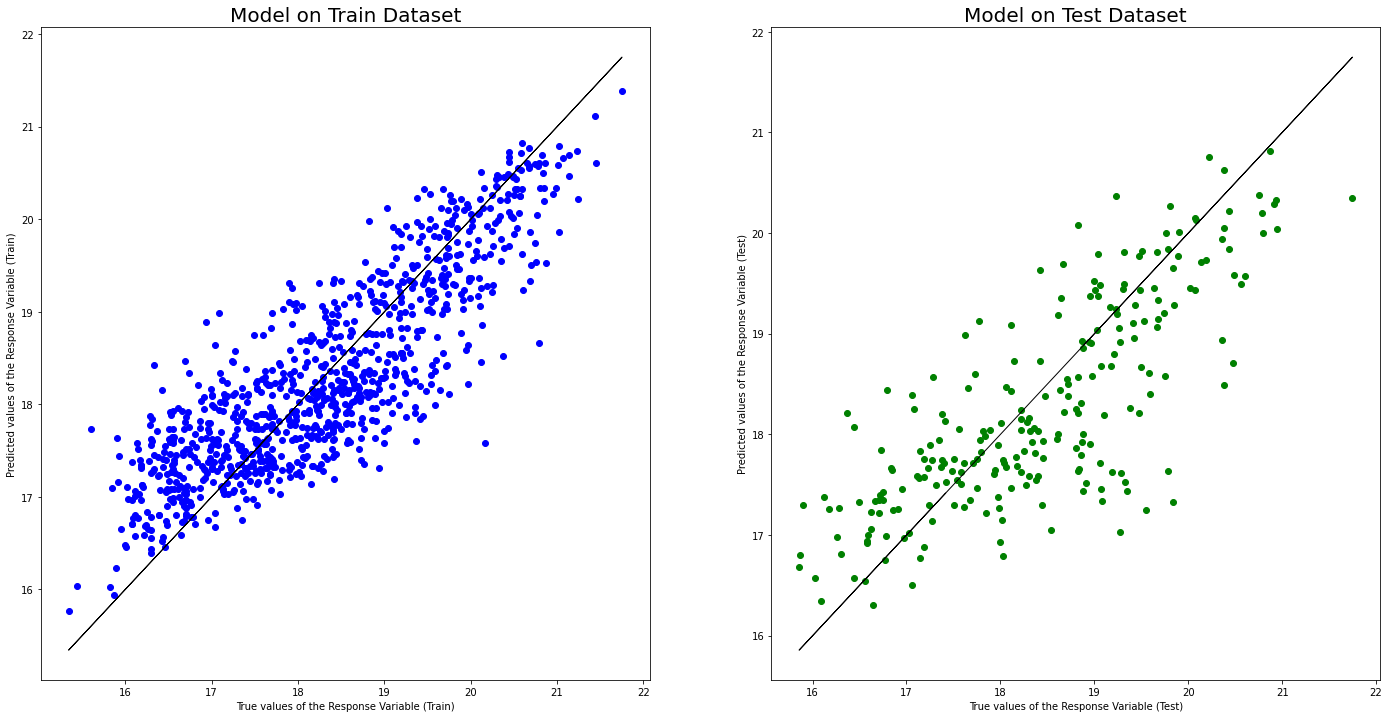

Goodness of Fit of Model 	Train Dataset
Explained Variance (R^2) 	: 0.7265451957764096
Mean Squared Error (MSE) 	: 0.4628160148097029

Goodness of Fit of Model 	Test Dataset
Explained Variance (R^2) 	: 0.5985160510566905
Mean Squared Error (MSE) 	: 0.6209161271157934



In [5]:
# Predict the Total values from Predictors with CatBoost
y_train_pred = catreg.predict(X_train)
y_test_pred = catreg.predict(X_test)

# Plot the Predictions vs the True values
f, axes = plt.subplots(1, 2, figsize=(24, 12))
axes[0].set_title('Model on Train Dataset',fontsize=20)
axes[1].set_title('Model on Test Dataset',fontsize=20)
axes[0].scatter(y_train, y_train_pred, color = "blue")
axes[0].plot(y_train, y_train, 'w-', linewidth = 1, color = "black")
axes[0].set_xlabel("True values of the Response Variable (Train)")
axes[0].set_ylabel("Predicted values of the Response Variable (Train)")
axes[1].scatter(y_test, y_test_pred, color = "green")
axes[1].plot(y_test, y_test, 'w-', linewidth = 1, color = "black")
axes[1].set_xlabel("True values of the Response Variable (Test)")
axes[1].set_ylabel("Predicted values of the Response Variable (Test)")
plt.show()

# Import mean_squared_error from sklearn
from sklearn.metrics import mean_squared_error

# Store in score_list
score2.append(r2_score(y_train, y_train_pred, sample_weight=None))
score1.append(r2_score(y_test, y_test_pred, sample_weight=None))
scoreM.append(metrics.mean_squared_error(y_test, y_test_pred))

# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print("Explained Variance (R^2) \t:", r2_score(y_train, y_train_pred, sample_weight=None))
print("Mean Squared Error (MSE) \t:", mean_squared_error(y_train, y_train_pred))
print()

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Explained Variance (R^2) \t:", r2_score(y_test, y_test_pred, sample_weight=None))
print("Mean Squared Error (MSE) \t:", mean_squared_error(y_test, y_test_pred))
print()

# 3.2 CatBoost Variable Importance Plots

Text(0.5, 0, 'CatBoost Feature Importance')

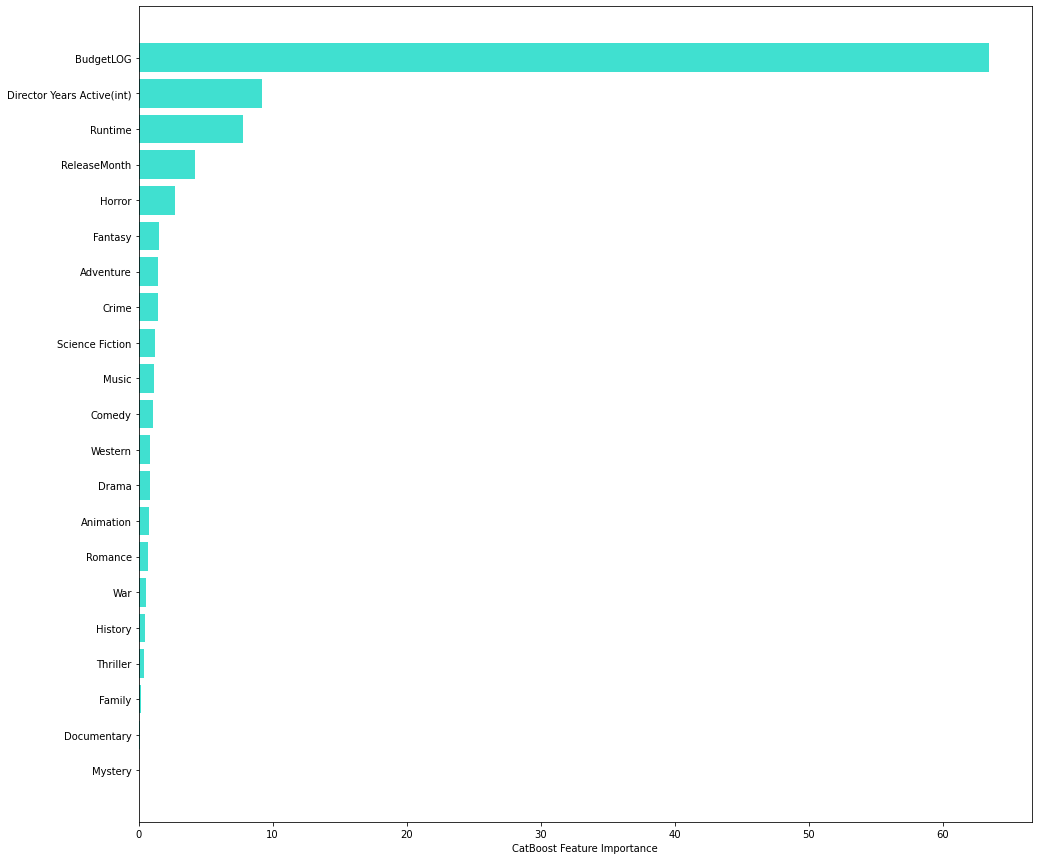

In [6]:
# How important IV are for determining DV
f=plt.figure(figsize=(16,15))
sorted_feature_importance = catreg.feature_importances_.argsort()
sorted_feature_importance = catreg.feature_importances_.argsort()
plt.barh(X.keys()[sorted_feature_importance], 
        catreg.feature_importances_[sorted_feature_importance], 
        color='turquoise')
plt.xlabel("CatBoost Feature Importance")

# 4. Neural Network

First, we import necessary libraries. We will be using Keras from TensorFlow API.

In [7]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
print(tf.__version__)

2.4.1


We then create a new dataframe called X that contains dependent variable and all the independent variables

In [8]:
X=movieGenre.iloc[:,3:]
X=X.join(movieMonth)
X=workDF[['RevenueLOG','BudgetLOG','Director Years Active(int)','Runtime']].join(X)

Next, we split our dataframe X into two datasets, train and test datasets. This is followed by initialising the .describe method of the dataframe transposed

In [9]:
train_dataset = X.sample(frac = 0.8, random_state = 0)
test_dataset = X.drop(train_dataset.index)

train_stats = train_dataset.describe()
train_stats = train_stats.transpose()

We pop RevenueLOG from train and test datasets because we will be predicting RevenueLOG using the independent variables. The popped RevenueLOG column is placed into new dataframe called train_labels and test_labels

In [10]:
train_labels = train_dataset.pop('RevenueLOG')
test_labels = test_dataset.pop('RevenueLOG')

Deep learning neural network models learn from a mapping from input variables to output variables. As such, the scale and distribution of the data drawn from the domain may be different for each variable. Hence, to improve the model stability and performance, we normalised our datasets.

In [11]:
def norm(x):
    return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset).dropna(axis='columns')
normed_test_data = norm(test_dataset).dropna(axis='columns')

Regressor model is then defined and the model is initialised.

In [12]:
def build_model():
    model = keras.Sequential([
        layers.Dense(64, activation = tf.nn.relu, input_shape=[len(train_dataset.keys())]),
        layers.Dense(64, activation = tf.nn.relu),
        layers.Dense(1)
    ])
    
    optimizer = tf.keras.optimizers.RMSprop(0.001)
    
    model.compile(loss = 'mse',
                 optimizer=optimizer,
                 metrics = ['mae', 'mse'])
    return model
model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                2112      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 6,337
Trainable params: 6,337
Non-trainable params: 0
_________________________________________________________________


Machine learning process may take up to weeks, depending on the size of the dataset. In order to make sure that machine learning is taking place, we visualise the process by printing dots. 

Maximum EPOCH value of 1000 is assigned.

In [13]:
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end = '')


EPOCHS = 1000


history = model.fit(
    normed_train_data, train_labels, epochs = EPOCHS, validation_split = 0.2, verbose = 0,
    callbacks = [PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

Printing the last 5 rows of history of regression,

In [14]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
995,0.046730,0.171582,0.046730,1.849076,1.076256,1.849076,995
996,0.057886,0.193612,0.057886,1.724954,1.039828,1.724954,996
997,0.070052,0.213727,0.070052,1.797882,1.057329,1.797882,997
998,0.045505,0.162737,0.045505,1.803077,1.044434,1.803077,998
999,0.073705,0.207194,0.073705,1.873468,1.053853,1.873468,999


In order to visualise the learning progress, we plot the learning curve using the statistics stored in the history object

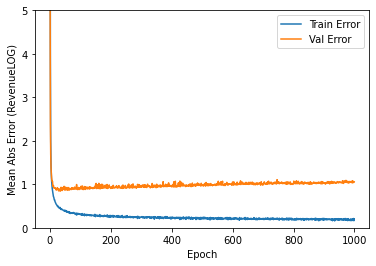

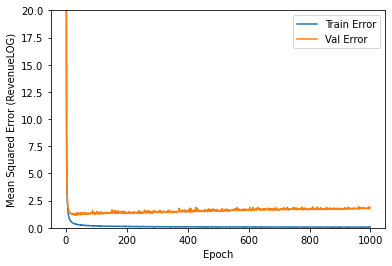

In [15]:
def plot_history(history):    
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error (RevenueLOG)')
    plt.plot(hist['epoch'], hist['mae'],
            label = 'Train Error')
    plt.plot(hist['epoch'], hist['val_mae'],
            label = 'Val Error')
    plt.legend()
    plt.ylim([0,5])

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Squared Error (RevenueLOG)')
    plt.plot(hist['epoch'], hist['mse'],
            label = 'Train Error')
    plt.plot(hist['epoch'], hist['val_mse'],
            label = 'Val Error')
    plt.legend()
    plt.ylim([0,20])
    
plot_history(history)

Given the maximum EPOCH value was 1000, overfitting could have occurred. We therefore implement early stop by monitoring the validation lost.


..............................................................................................

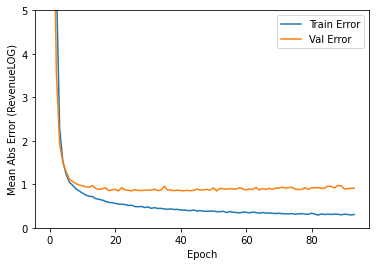

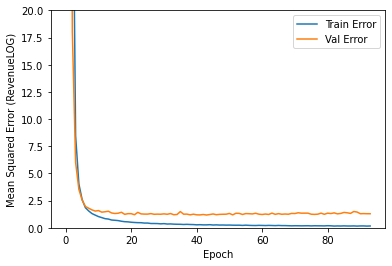

In [16]:
#Implementing early stop to prevent overfitting
model = build_model()

early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 50)

history = model.fit(normed_train_data, train_labels, epochs = EPOCHS,
                   validation_split = 0.2, verbose = 0, callbacks = [early_stop, PrintDot()])

plot_history(history)

In [17]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose = 0)

print("Testing set Mean Abs Error: {:5.2f} RevenueLOG".format(mae))

Testing set Mean Abs Error:  0.88 RevenueLOG


Making predictions,

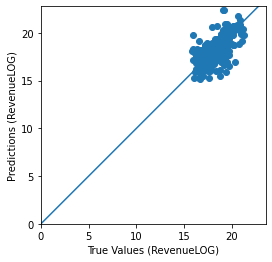

In [18]:
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values (RevenueLOG)')
plt.ylabel('Predictions (RevenueLOG)')
plt.axis('equal')
plt.axis('square')
plt.xlim(0, plt.xlim()[1])
plt.ylim(0, plt.ylim()[1])
_ = plt.plot([-100, 100], [-100, 100])

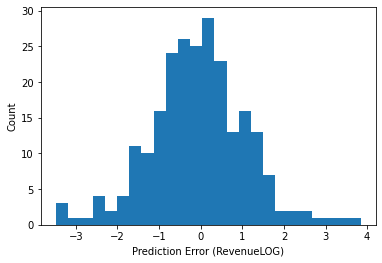

In [19]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error (RevenueLOG)")
_ = plt.ylabel("Count")

We then predict y_train_pred and y_test_pred, then plot the predictions against the true values.

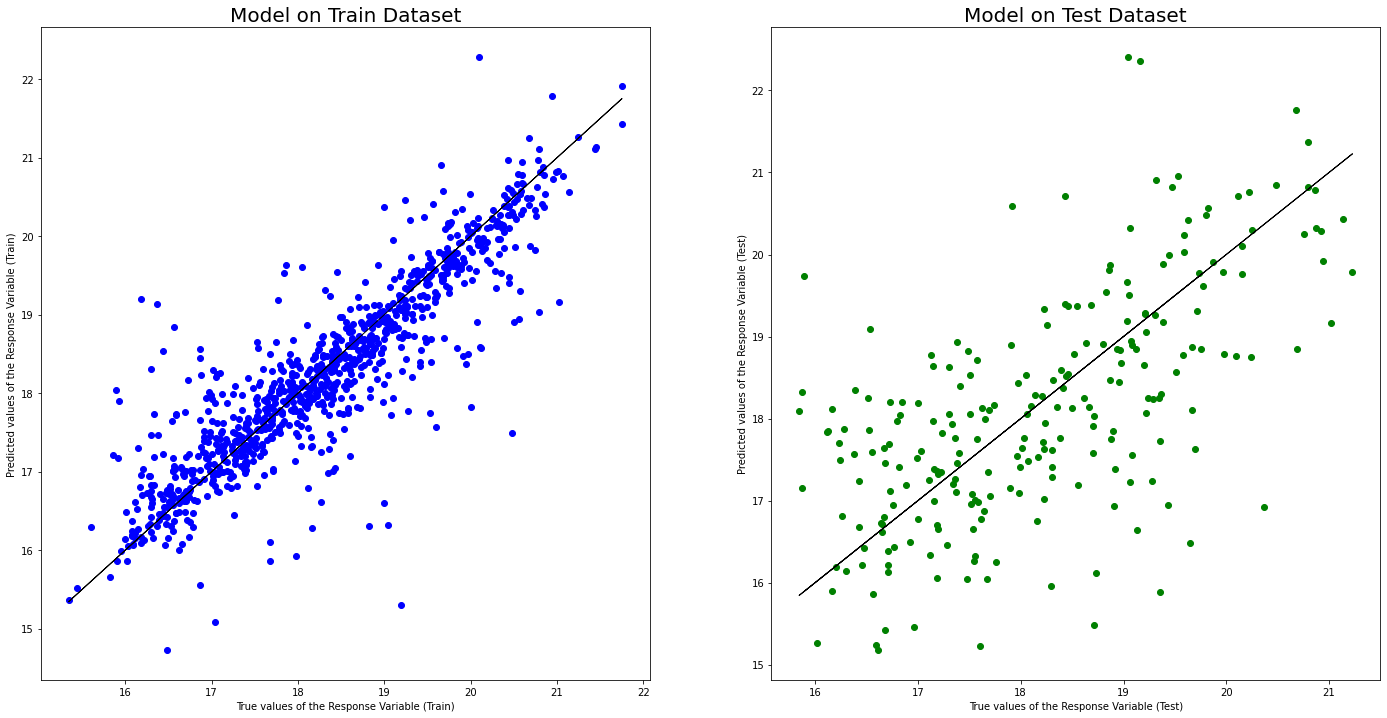

Goodness of Fit of Model 	Train Dataset
Mean Absolute Error: 0.3754126516461261
Mean Squared Error: 0.34660461638195994
Explained Variance (R^2): 0.7909593226409946

Goodness of Fit of Model 	Test Dataset
Mean Absolute Error: 0.8815874335512424
Mean Squared Error: 1.342619434360506
Explained Variance (R^2): 0.20104437919513685


In [20]:
y_train_pred = model.predict(normed_train_data)
y_test_pred = model.predict(normed_test_data)

f, axes = plt.subplots(1, 2, figsize=(24, 12))
axes[0].set_title('Model on Train Dataset',fontsize=20)
axes[1].set_title('Model on Test Dataset',fontsize=20)
axes[0].scatter(train_labels, y_train_pred, color = "blue")
axes[0].plot(train_labels, train_labels, 'w-', linewidth = 1,color='black')
axes[0].set_xlabel("True values of the Response Variable (Train)")
axes[0].set_ylabel("Predicted values of the Response Variable (Train)")
axes[1].scatter(test_labels, y_test_pred, color = "green")
axes[1].plot(test_labels, test_labels, 'w-', linewidth = 1,color='black')
axes[1].set_xlabel("True values of the Response Variable (Test)")
axes[1].set_ylabel("Predicted values of the Response Variable (Test)")
plt.show()

    
score2.append(r2_score(train_labels, y_train_pred, sample_weight=None))
score1.append(r2_score(test_labels, y_test_pred, sample_weight=None))
scoreM.append(metrics.mean_squared_error(test_labels, y_test_pred))

# MAE/MSE/RMSE/R^2 for train data
print("Goodness of Fit of Model \tTrain Dataset")
print('Mean Absolute Error:', metrics.mean_absolute_error(train_labels, y_train_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(train_labels, y_train_pred))  
print("Explained Variance (R^2):", r2_score(train_labels, y_train_pred, sample_weight=None))
print()

# MAE/MSE/RMSE/R^2 for test data
print("Goodness of Fit of Model \tTest Dataset")
print('Mean Absolute Error:', metrics.mean_absolute_error(test_labels, y_test_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(test_labels, y_test_pred))  
print("Explained Variance (R^2):", r2_score(test_labels, y_test_pred, sample_weight=None))

# 5. Discussion

## 5.1 Explained Variance between algorithms
### Explained variance of Catboost is highest followed by multivariate regression and Univariate regression.
### Explained variance measures our models ability to explain the variation in our datasets, the models were trained on trained models and the figure below shows the R^2 on the test set.

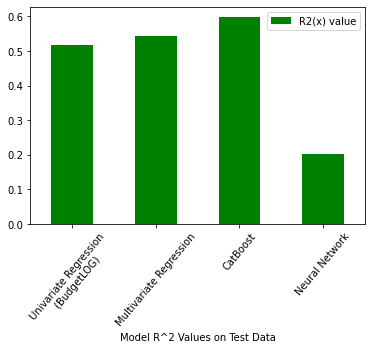

In [21]:
df = pd.DataFrame({"x":['Life Ladder']*4,
                 "R2(x) value":score1,
                   "Model R^2 Values on Test Data": ['Univariate Regression\n (BudgetLOG)', 'Multivariate Regression', "CatBoost", "Neural Network"]})

ax = df[["Model R^2 Values on Test Data", "R2(x) value"]].plot(x='Model R^2 Values on Test Data',
                                 kind = 'bar',
                                 color = ['g'],
                                rot=50)

## 5.2 Mean Squared Error between algorithms

### The Variation between prediction and the actual value
### The lower the better

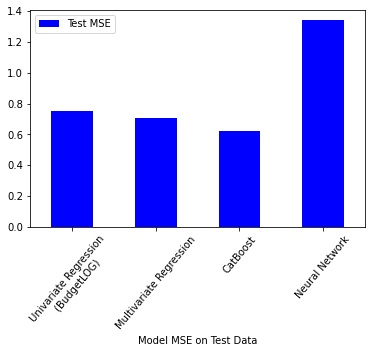

In [22]:
df = pd.DataFrame({"x":['Test MSE']*4,
                 "MSE":scoreM,
                   "Model MSE on Test Data": ['Univariate Regression\n (BudgetLOG)', 'Multivariate Regression', "CatBoost", "Neural Network"]})

ax = df[["Model MSE on Test Data", "MSE"]].plot(x='Model MSE on Test Data',
                                 kind = 'bar',
                                 color = ['b'],
                                rot=50)

ax.legend(['Test MSE']);

## 5.3 Explained Variance between algorithms train and test datasets
### From the plot below, catboost has the best model for predicting our DV. 
### A shocking contrast is our neural network values. With the 2nd highest R^2 for the train datasets while having the lowest R^2 for the test dataset

### An explanation for the low neural network test set R^2 could be a result of overfitting, causing the model to be too used to the train set. Or the algorithm is not compatible with our data structure.

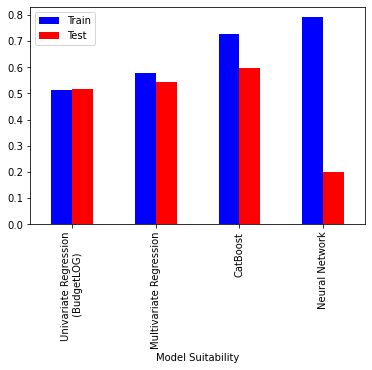

In [23]:
df = pd.DataFrame({"x":['Train']*4,
                 "R2(x) value":score2,
                   "Model Suitability": ['Univariate Regression\n (BudgetLOG)', 'Multivariate Regression', "CatBoost", "Neural Network"],
                   "y": ['Test']*4,
                   "R2(y) value": score1})

ax = df[["Model Suitability", "R2(x) value", "R2(y) value"]].plot(x='Model Suitability',
                                 kind = 'bar',
                                 color = ['b','r'])

ax.legend(['Train', 'Test']);